In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os, sys
import re
import pandas as pd
import hist
import matplotlib as mpl
import mplhep
import utils
from pathlib import Path
import mplhep

sys.path.append("../../../analysisTools/")
import plotTools as ptools

In [2]:
def add_signal_info_to_df(df):
    m1_list = []
    delta_list = []
    ctau_list = []
    
    for point in df.index.values:
        sig_dict = ptools.signalPoint(point)
        m1_list.append(sig_dict['m1'])
        delta_list.append(sig_dict['delta'])
        ctau_list.append(sig_dict['ctau'])
    
    df['m1'] = m1_list
    df['delta'] = delta_list
    df['ctau'] = ctau_list
    
    df = df.sort_values(by=['m1']) # sort by m1

    return df

In [3]:
def save_df_to_csv(df, outdir, outname, isSignal = False):
    Path(outdir).mkdir(parents=True, exist_ok=True)

    if isSignal:
        df = add_signal_info_to_df(df)
    
    df.to_csv(f'{outdir}/{outname}.csv')

    print(f'Saved: {outdir}/{outname}.csv')

# Plot 1D: True Best vertex vs. False Best vertex in gen-ee reconstructed events

In [4]:
prefix = './coffea/skimmed/'

In [5]:
# Signal
sig_histo = util.load(f'{prefix}/SR_Lxy_BestVertex_fewMass.coffea')[0]

In [6]:
prefix = './coffea/skimmed/'
suffix = '_SR_Lxy_BestVertex'

In [7]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]

# Cutflow

In [8]:
# weighted event count
pd.options.display.float_format = '{:,.2f}'.format
bkg_cts_df = utils.get_bkg_cutflow_df(bkg_histos, 'cutflow_cts')

bkg_cts_df

Preselections  0 < n(jet) < 3 & n(good vertex) > 0  \
QCD           38,039.83                             1,882.67   
Top            5,667.49                               559.22   
DY            14,495.72                               671.44   
Diboson        4,424.20                               307.91   
Triboson          53.00                                 4.32   
W+jets       227,212.60                            17,009.81   
Z+jets       142,220.15                             8,524.55   
Total        432,113.00                            28,959.92   

          computing BDT score  No b-tagged jets  Leading jet |eta| < 2.4  \
QCD                  1,882.67          1,326.86                 1,319.01   
Top                    559.22            349.76                   314.03   
DY                     671.44            623.25                   623.25   
Diboson                307.91            227.24                   213.36   
Triboson                 4.32              2.85                     2.51   
W+jets              17,009.81         13,645.63                12,937.21   
Z+jets               8,524.55          6,957.67                 6,625.48   
Total               28,959.92         23,133.27                22,034.86   

          Leading jet pT > 80 GeV  dPhi(MET,leading jet) > 1.5  \
QCD                      1,319.01                     1,318.41   
Top                        312.99                       312.95   
DY                         623.25                       623.25   
Diboson                    211.27                       210.33   
Triboson                     2.51                         2.50   
W+jets                  12,911.49                    12,907.15   
Z+jets                   6,613.11                     6,612.30   
Total                   21,993.63                    21,986.91   

          dPhi(MET,all jets) > 0.75    BDT  dR < 0.5  
QCD                          632.25   0.00      0.00  
Top                          294.00   1.50      0.36  
DY                           455.65 143.51      0.00  
Diboson                      189.35   2.30      0.29  
Triboson                       2.09   0.00      0.00  
W+jets                    11,204.39  77.39     15.36  
Z+jets                     6,256.76  15.11      5.19  
Total                     19,034.50 239.81     21.21

### sel_vtx_vxy

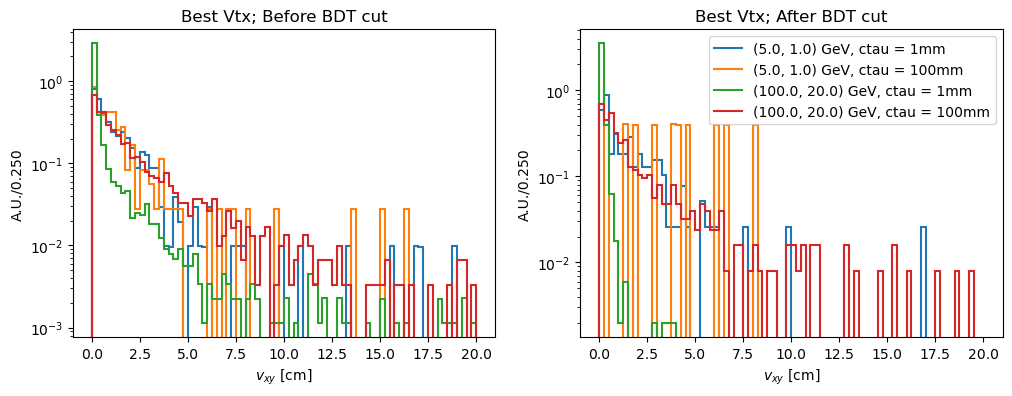

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy',
}

style_dict = {
    'rebin': 10j,
    'xlim': [0,20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
plot_dict['cut'] = 'cut9'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[0], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[0].set_title('Best Vtx; Before BDT cut')

# Plot for variables signal points
plot_dict['cut'] = 'cut10'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[1], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[1].set_title('Best Vtx; After BDT cut')

plt.legend()
plt.show()

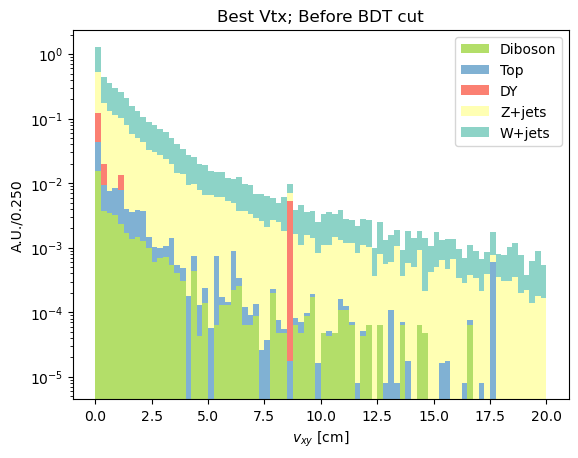

In [10]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

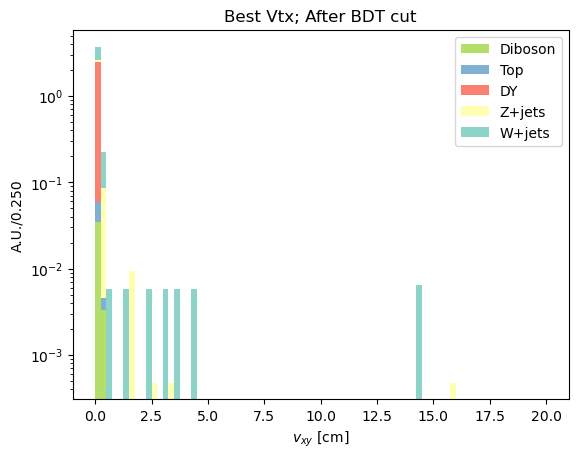

In [11]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

### sel_vtx_pt_e1_over_pt_e2

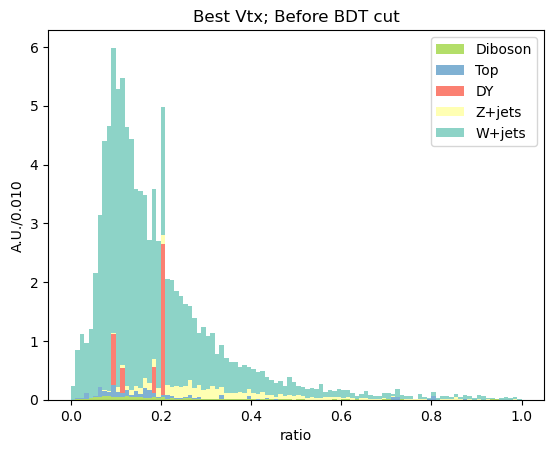

In [12]:

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_pt_e1_over_pt_e2',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

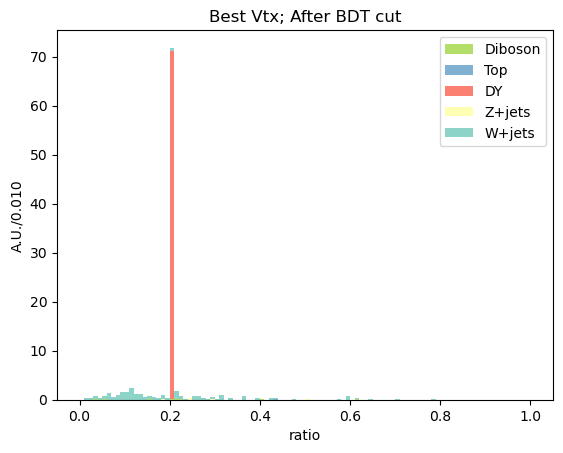

In [13]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

### sel_vtx_minDxy

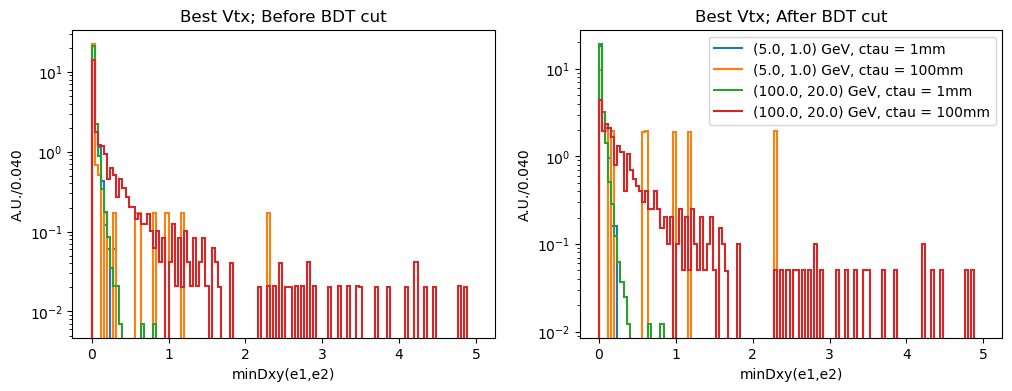

In [41]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_minDxy',
}

style_dict = {
    'rebin': 40j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': 'minDxy(e1,e2)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
plot_dict['cut'] = 'cut9'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[0], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[0].set_title('Best Vtx; Before BDT cut')

# Plot for variables signal points
plot_dict['cut'] = 'cut10'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[1], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[1].set_title('Best Vtx; After BDT cut')

plt.legend()
plt.show()

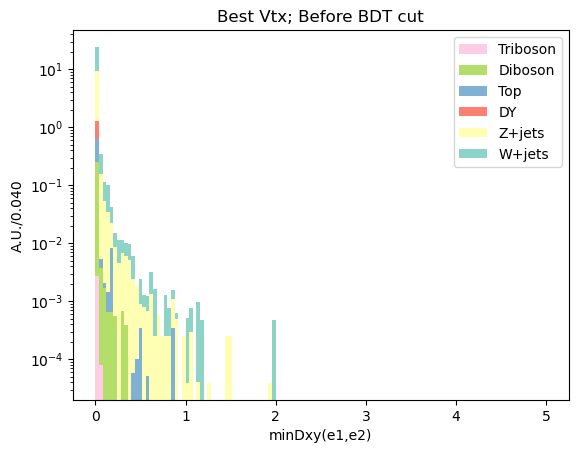

In [42]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'Triboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

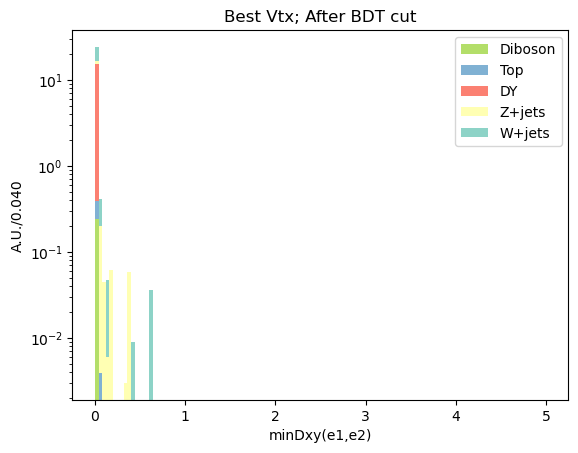

In [43]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

### sel_vtx_vxySignif

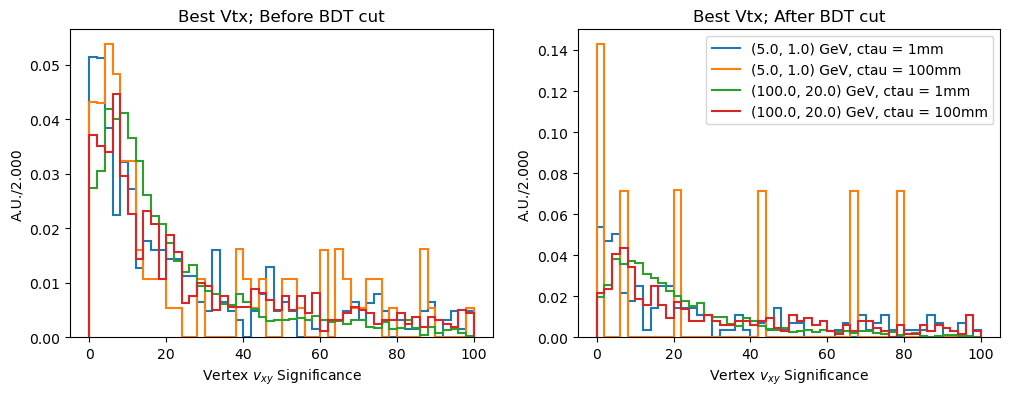

In [44]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxySignif',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
plot_dict['cut'] = 'cut9'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[0], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[0].set_title('Best Vtx; Before BDT cut')

# Plot for variables signal points
plot_dict['cut'] = 'cut10'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[1], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[1].set_title('Best Vtx; After BDT cut')

plt.legend()
plt.show()

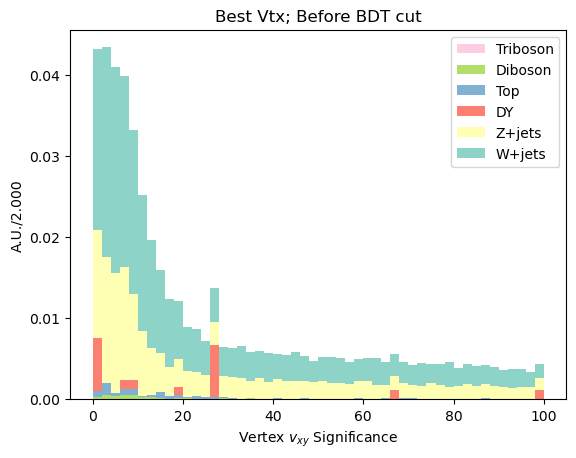

In [45]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'Triboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

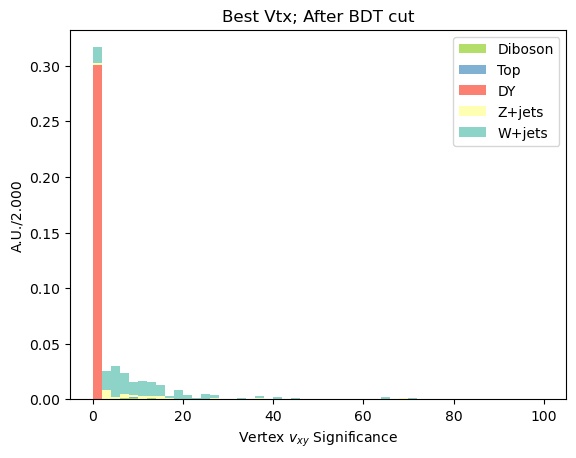

In [46]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

### sel_vtx_chi2

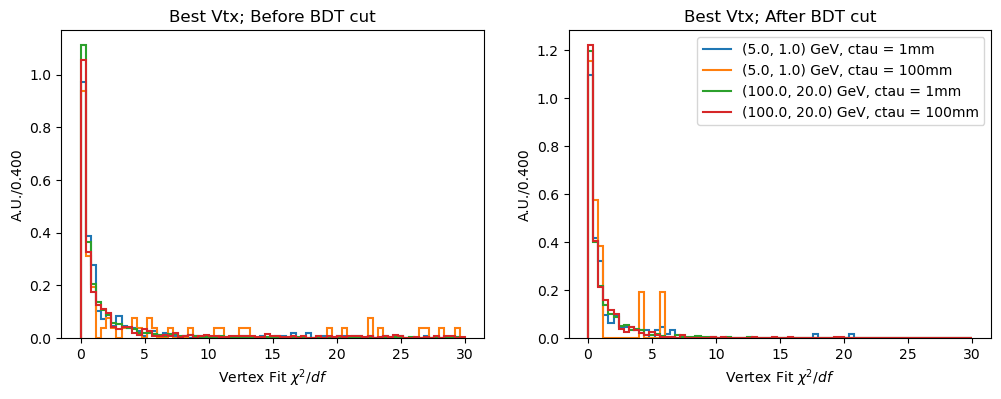

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_chi2',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
plot_dict['cut'] = 'cut9'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[0], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[0].set_title('Best Vtx; Before BDT cut')

# Plot for variables signal points
plot_dict['cut'] = 'cut10'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[1], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[1].set_title('Best Vtx; After BDT cut')

plt.legend()
plt.show()

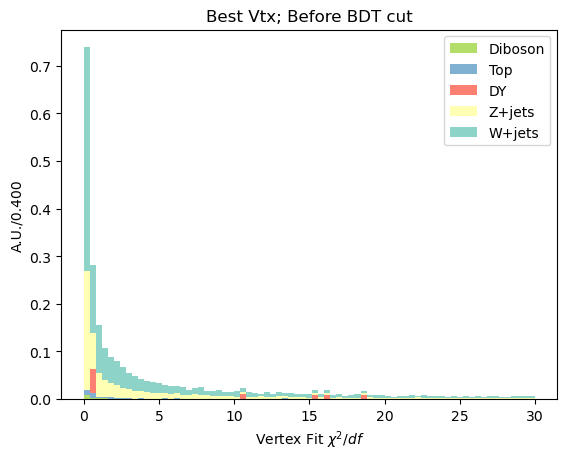

In [22]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

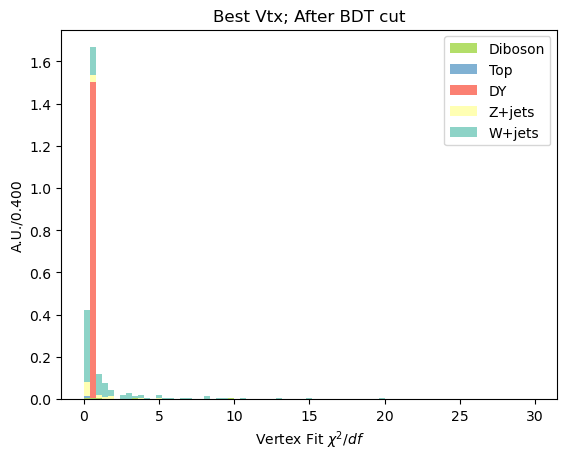

In [23]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

### sel_vtx_dR

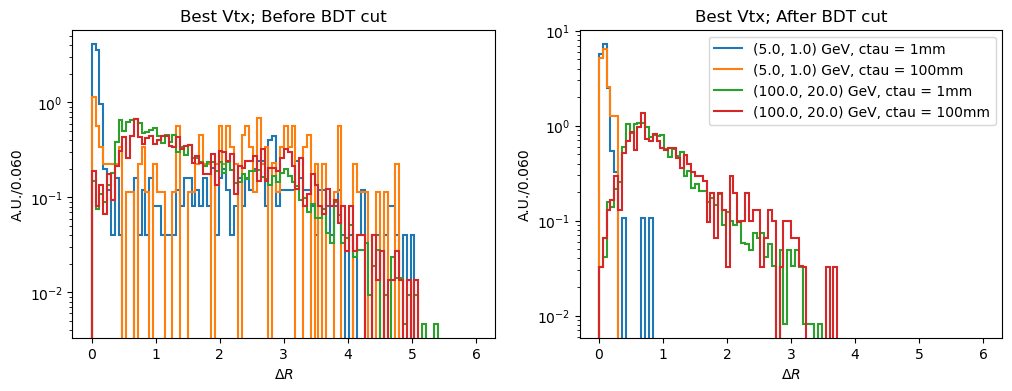

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
plot_dict['cut'] = 'cut9'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[0], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[0].set_title('Best Vtx; Before BDT cut')

# Plot for variables signal points
plot_dict['cut'] = 'cut10'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[1], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[1].set_title('Best Vtx; After BDT cut')

plt.legend()
plt.show()

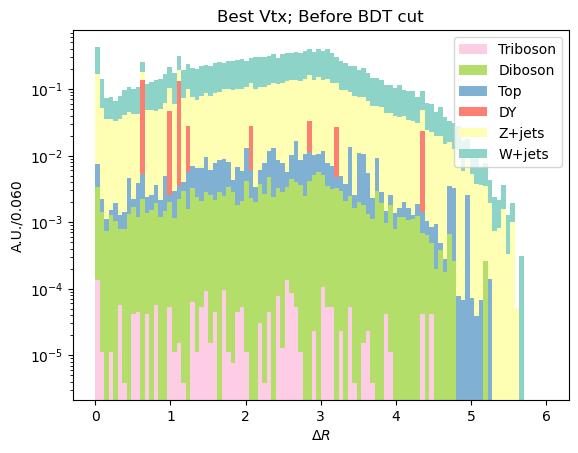

In [39]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'Triboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

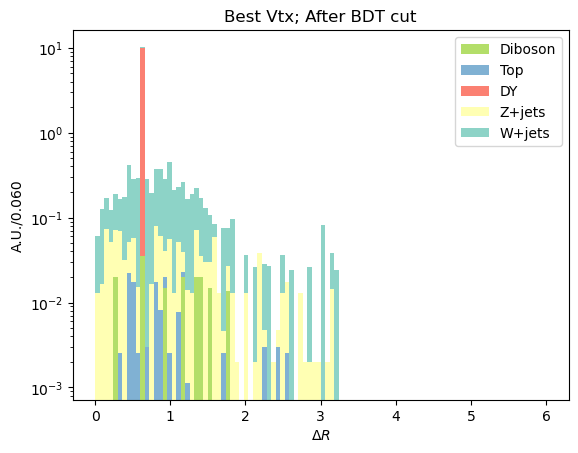

In [40]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

/uscms/home/kyungmip/nobackup/miniconda3/envs/coffea/lib/python3.8/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


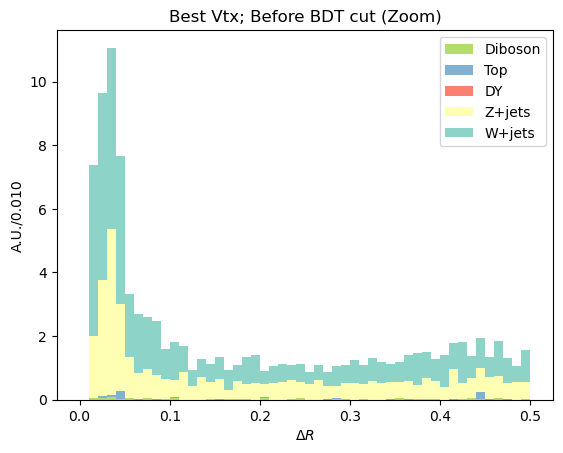

In [27]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom',
    'cut': 'cut9'
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; Before BDT cut (Zoom)')
plt.legend()
plt.show()

### sel_vtx_mass

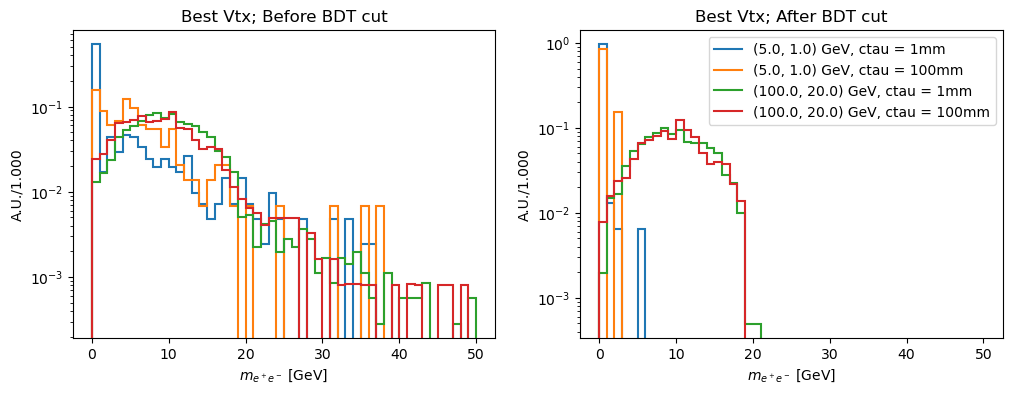

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_mass',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
plot_dict['cut'] = 'cut9'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[0], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[0].set_title('Best Vtx; Before BDT cut')

# Plot for variables signal points
plot_dict['cut'] = 'cut10'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[1], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[1].set_title('Best Vtx; After BDT cut')

plt.legend()
plt.show()

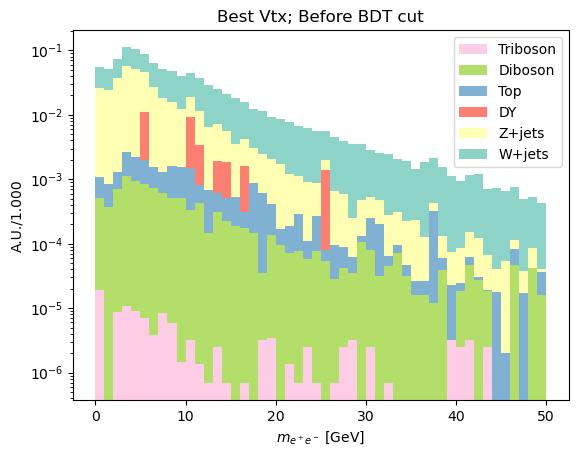

In [29]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'Triboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

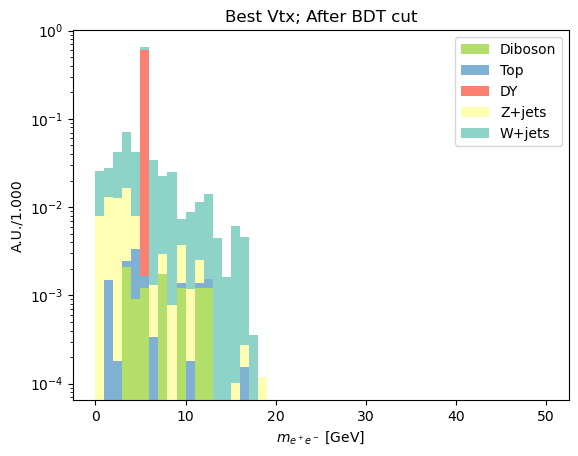

In [31]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

### sel_vtx_METdPhi

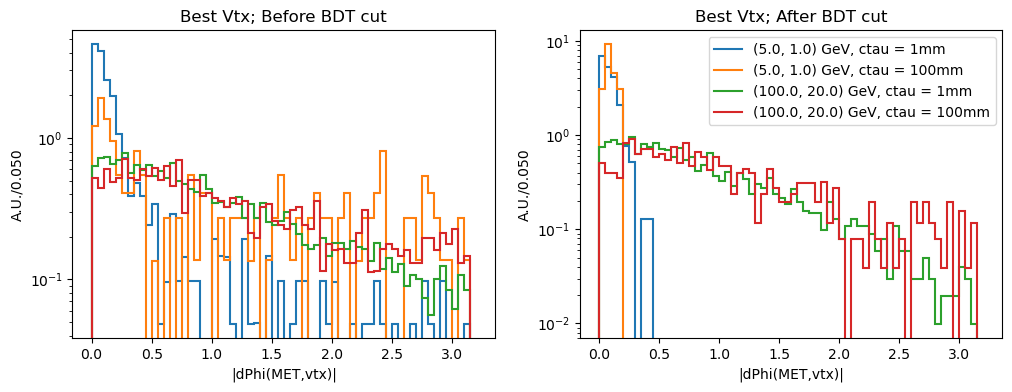

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_METdPhi',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': '|dPhi(MET,vtx)|',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
plot_dict['cut'] = 'cut9'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[0], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[0].set_title('Best Vtx; Before BDT cut')

# Plot for variables signal points
plot_dict['cut'] = 'cut10'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[1], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[1].set_title('Best Vtx; After BDT cut')

plt.legend()
plt.show()

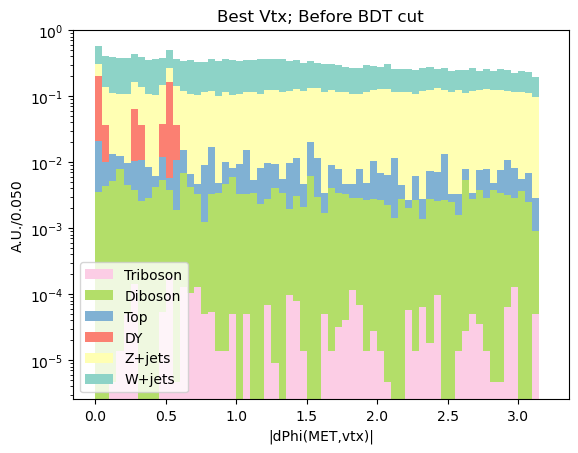

In [51]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'Triboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

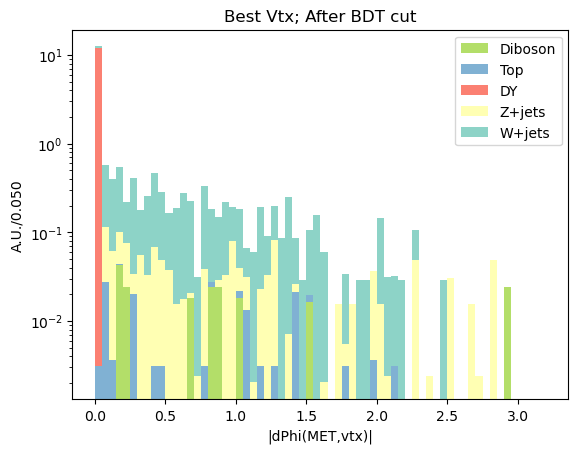

In [52]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets', 'DY'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

### sel_vtx_type

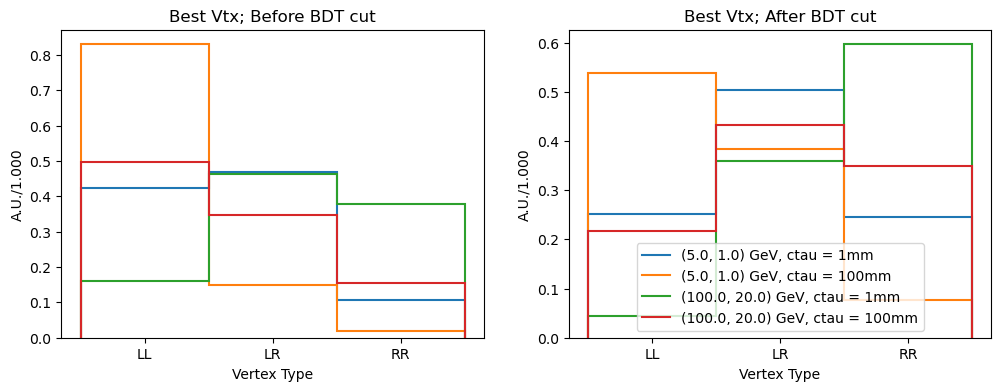

In [46]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_type',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
plot_dict['cut'] = 'cut9'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[0], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[0].set_title('Best Vtx; Before BDT cut')

# Plot for variables signal points
plot_dict['cut'] = 'cut10'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[1], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[1].set_title('Best Vtx; After BDT cut')

plt.legend()
plt.show()

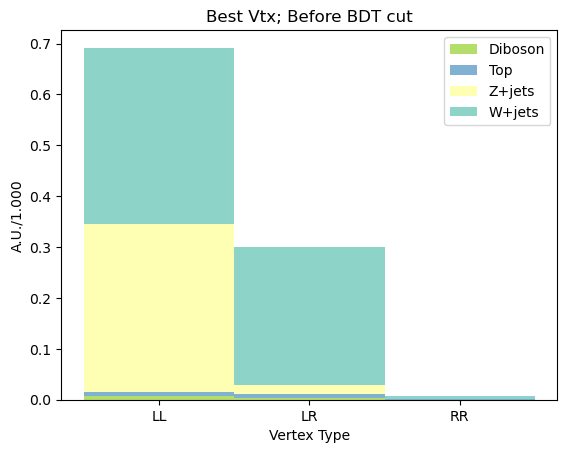

In [47]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

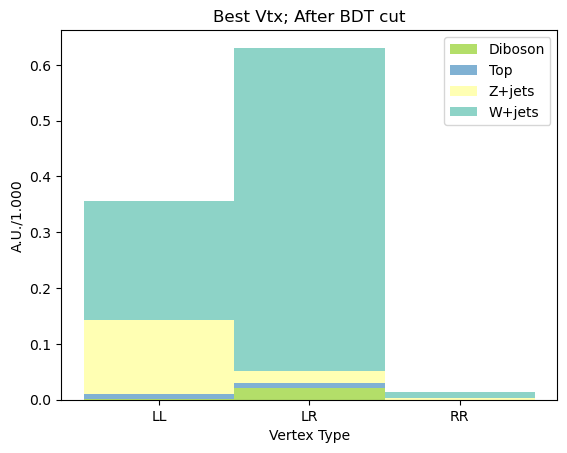

In [48]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

### bdt_score

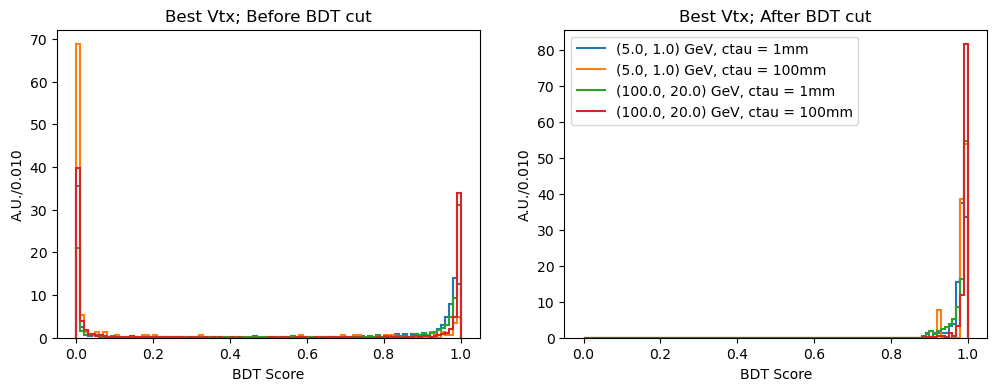

In [39]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot settings
plot_dict = {
    'variable': 'bdt_score',
}

style_dict = {
    'rebin': 5j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
plot_dict['cut'] = 'cut9'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[0], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[0].set_title('Best Vtx; Before BDT cut')

# Plot for variables signal points
plot_dict['cut'] = 'cut10'
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax[1], sig_histo, m1, delta, ctau, plot_dict, style_dict)

ax[1].set_title('Best Vtx; After BDT cut')

plt.legend()
plt.show()

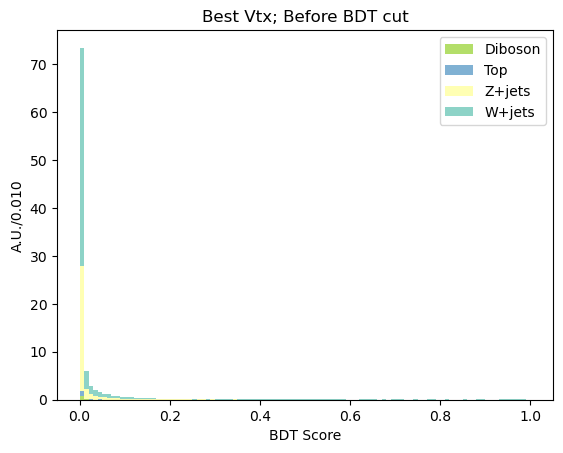

In [40]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut9'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets'])

plt.title('Best Vtx; Before BDT cut')
plt.legend()
plt.show()

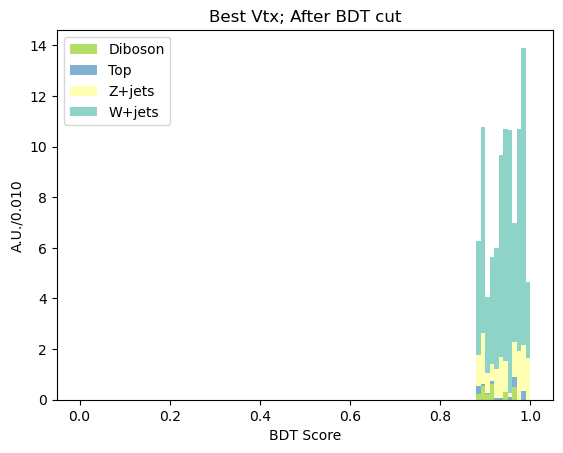

In [41]:
fig, ax = plt.subplots()

# bkg
plot_dict['cut'] = 'cut10'
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'Diboson', 'W+jets', 'Z+jets'])

plt.title('Best Vtx; After BDT cut')
plt.legend()
plt.show()

### sel_vtx_dR_vs_sel_vtx_vxy | sel_vtx_dR_zoom_vs_sel_vtx_vxy

Text(0.5, 1.0, 'All Background')

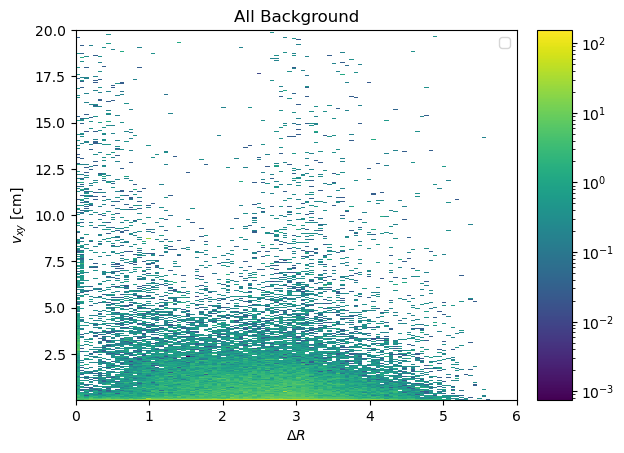

In [42]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_sel_vtx_vxy',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0,20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

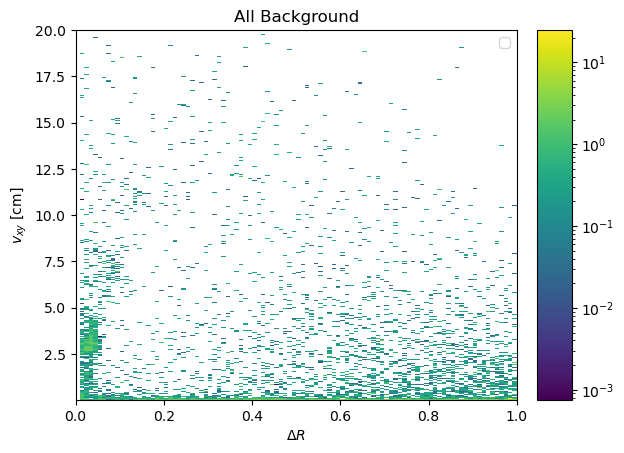

In [43]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_sel_vtx_vxy',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0,20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

### sel_vtx_dR_vs_sel_vtx_pt_e1_over_pt_e2

Text(0.5, 1.0, 'All Background')

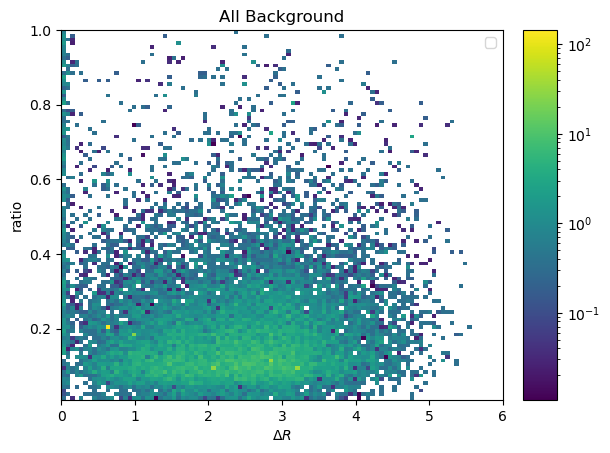

In [44]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_sel_vtx_pt_e1_over_pt_e2',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0,20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

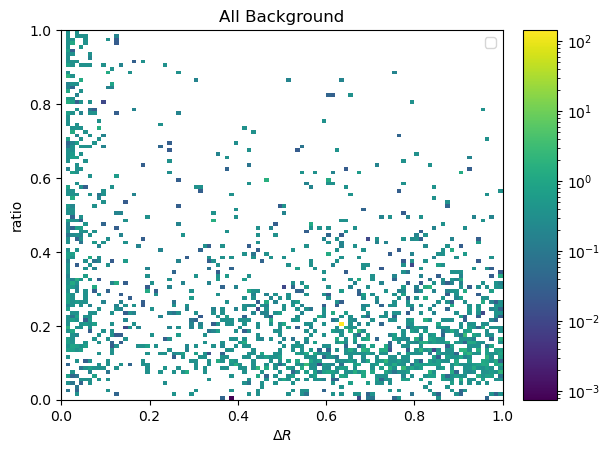

In [52]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_sel_vtx_pt_e1_over_pt_e2',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

### sel_vtx_dR_vs_sel_vtx_type

Text(0.5, 1.0, 'All Background')

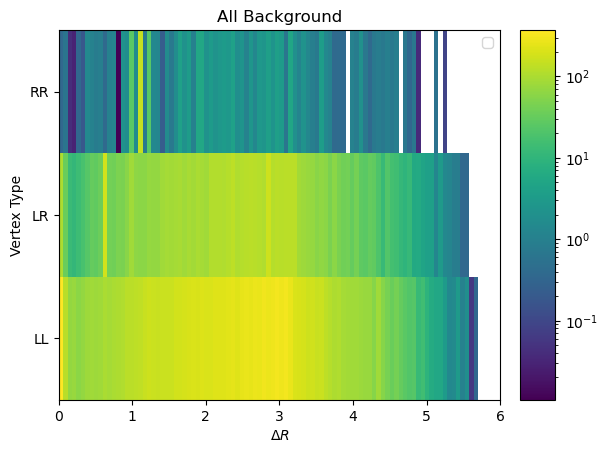

In [49]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_sel_vtx_type',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

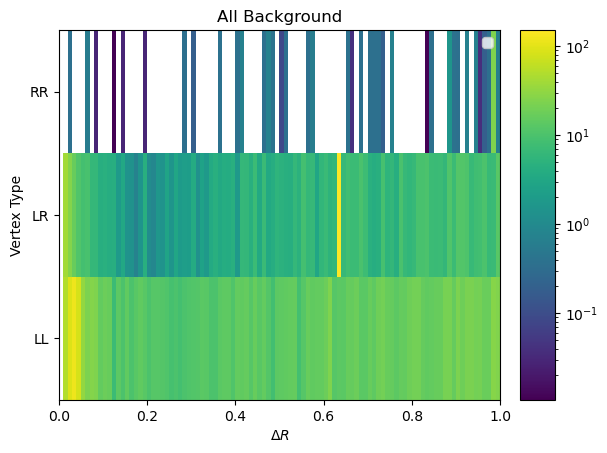

In [50]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_sel_vtx_type',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

### sel_vtx_dR_vs_sel_vtx_mass | sel_vtx_dR_zoom_vs_sel_vtx_mass

Text(0.5, 1.0, 'All Background')

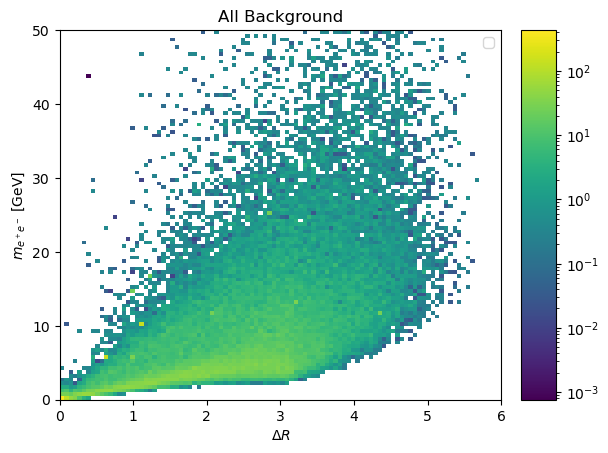

In [137]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_sel_vtx_mass',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

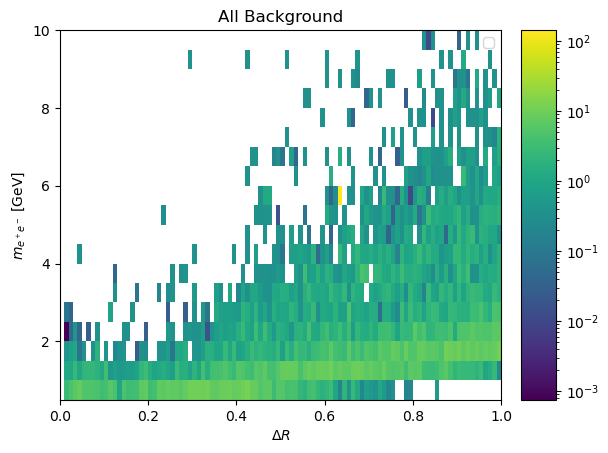

In [138]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_sel_vtx_mass',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0,10],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

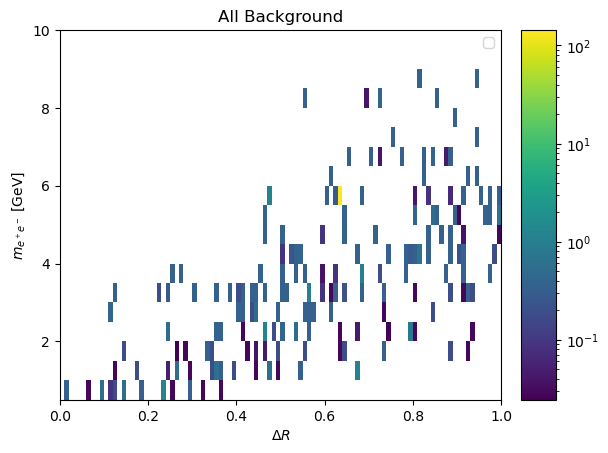

In [139]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_sel_vtx_mass',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0,10],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

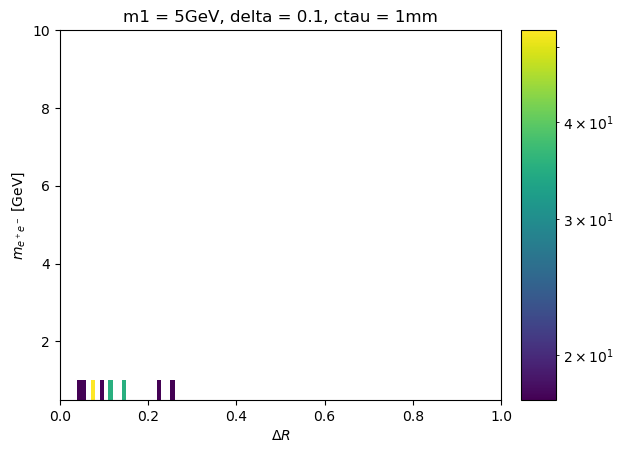

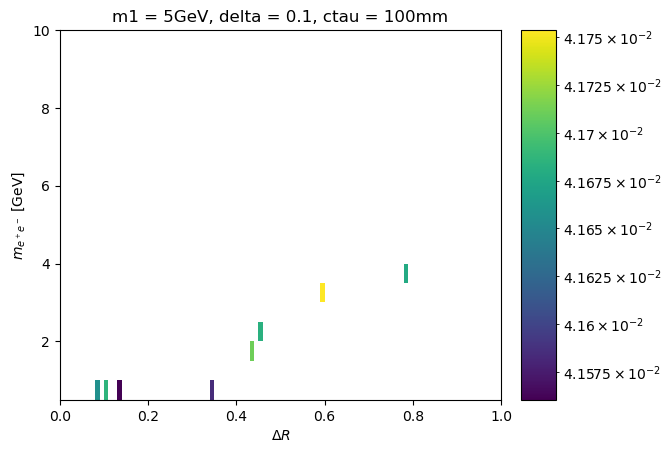

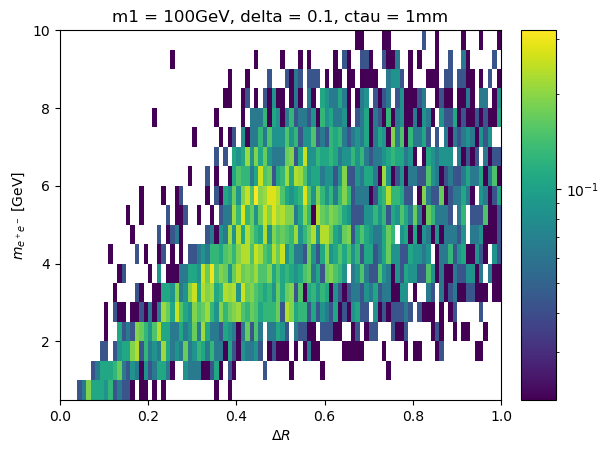

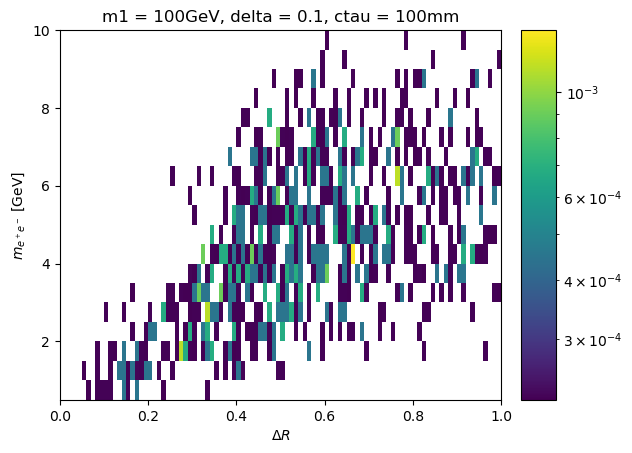

In [140]:
m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_dR_vs_sel_vtx_minDxy | sel_vtx_dR_zoom_vs_sel_vtx_minDxy

Text(0.5, 1.0, 'All Background')

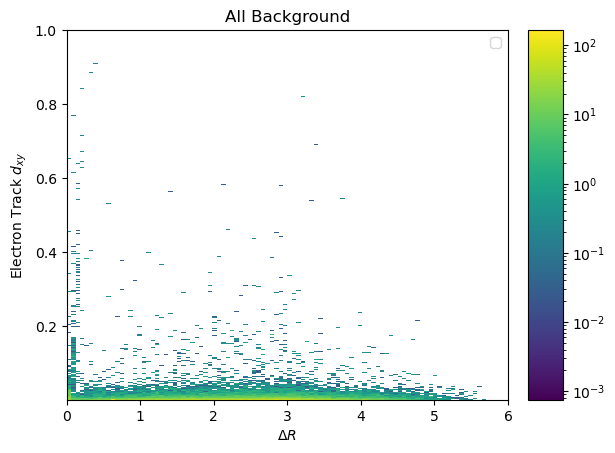

In [146]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_sel_vtx_minDxy',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0,1],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

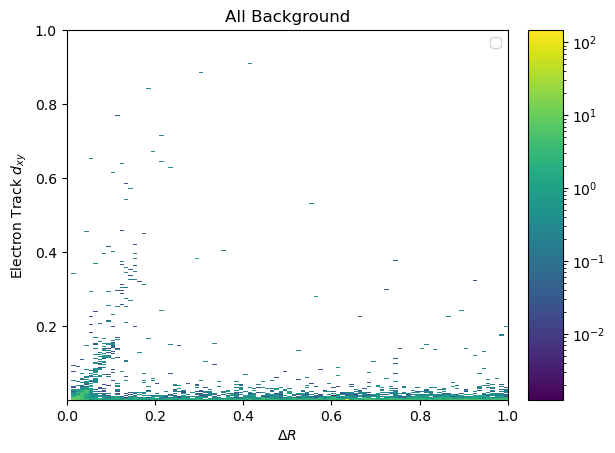

In [147]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_sel_vtx_minDxy',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0,1],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

### sel_vtx_dR_vs_sel_vtx_chi2 | sel_vtx_dR_zoom_vs_sel_vtx_chi2

Text(0.5, 1.0, 'All Background')

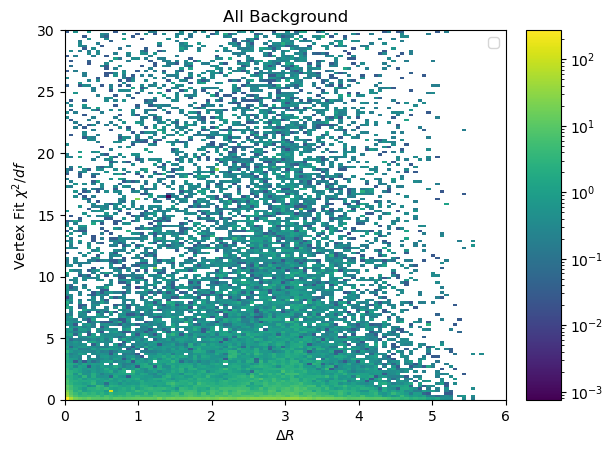

In [149]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_sel_vtx_chi2',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

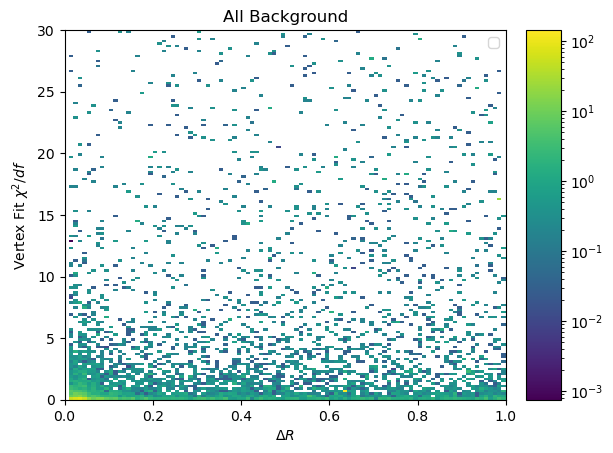

In [150]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_sel_vtx_chi2',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

### sel_vtx_dR_vs_sel_vtx_vxySignif | sel_vtx_dR_zoom_vs_sel_vtx_vxySignif

Text(0.5, 1.0, 'All Background')

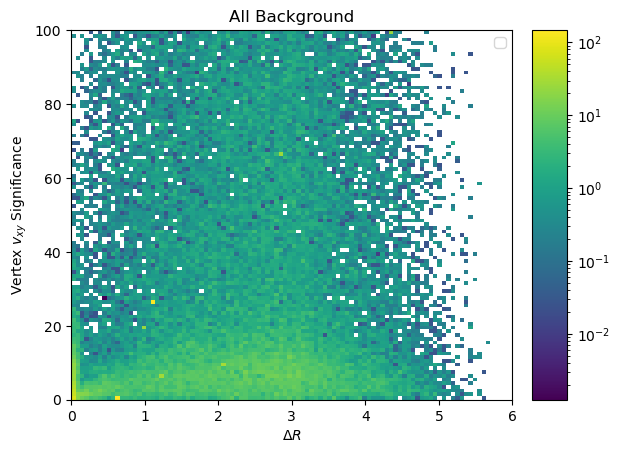

In [152]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_sel_vtx_vxySignif',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

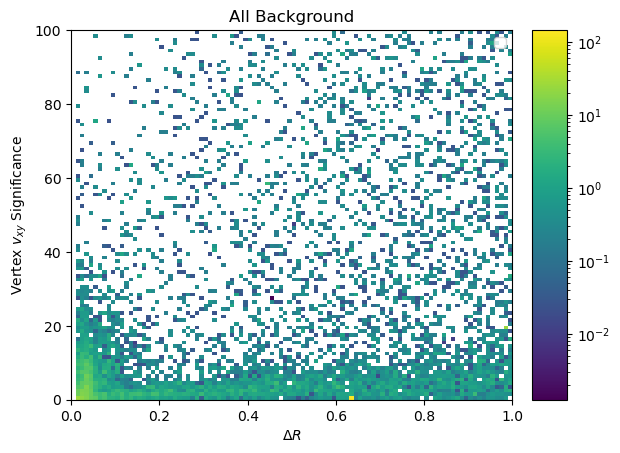

In [153]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_sel_vtx_vxySignif',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

### sel_vtx_dR_vs_sel_vtx_METdPhi | sel_vtx_dR_zoom_vs_sel_vtx_METdPhi

Text(0.5, 1.0, 'All Background')

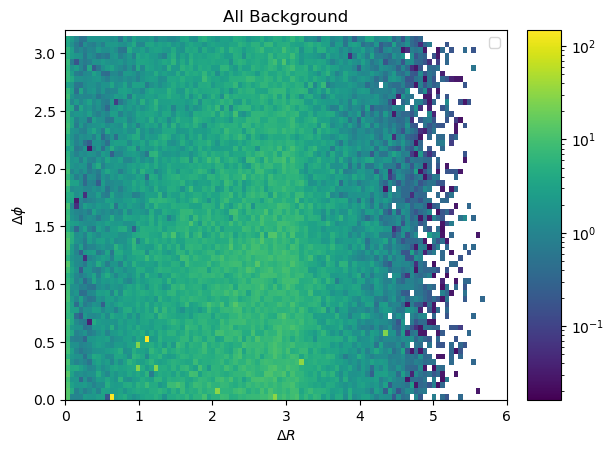

In [154]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_sel_vtx_METdPhi',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

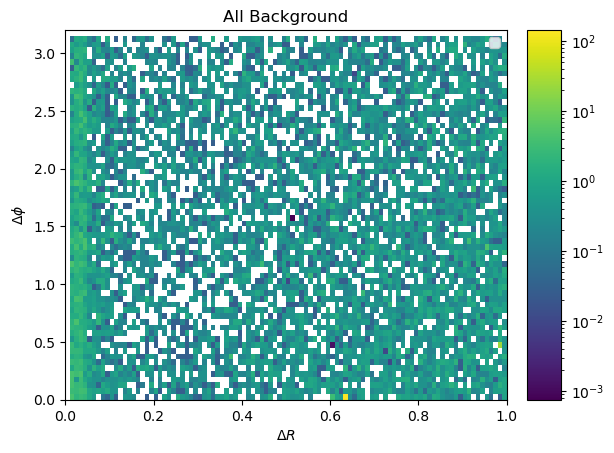

In [155]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_sel_vtx_METdPhi',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

### sel_vtx_dR_vs_bdt_score | sel_vtx_dR_zoom_vs_bdt_score

Text(0.5, 1.0, 'All Background')

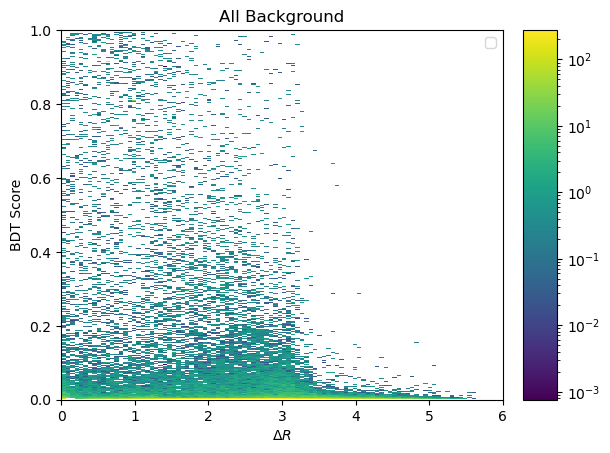

In [156]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_bdt_score',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

Text(0.5, 1.0, 'All Background')

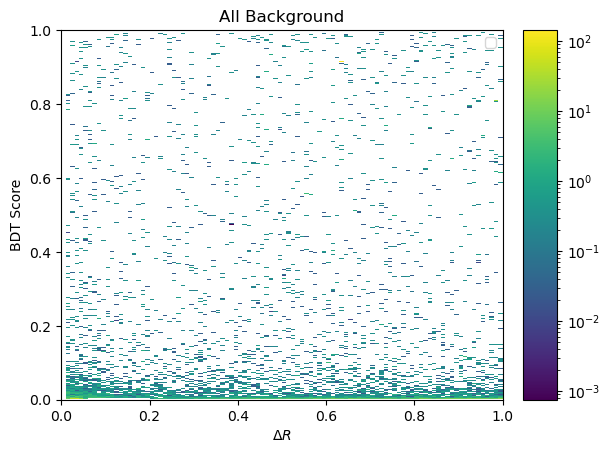

In [157]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_zoom_vs_bdt_score',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'Top', 'Diboson', 'DY'])

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])

### ctau

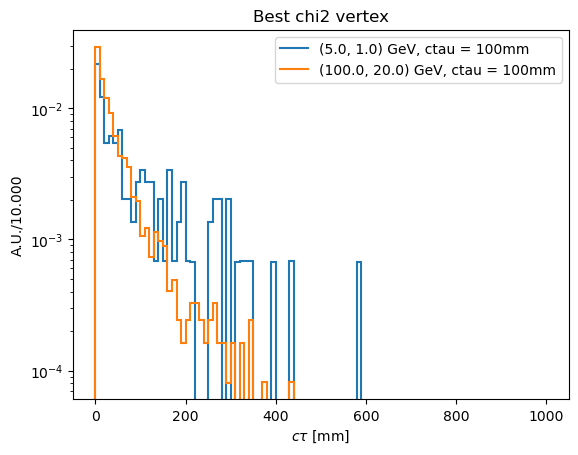

In [42]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'ctau',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 100j,
    'xlim': [0,1000],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 vertex')
plt.legend()
plt.show()

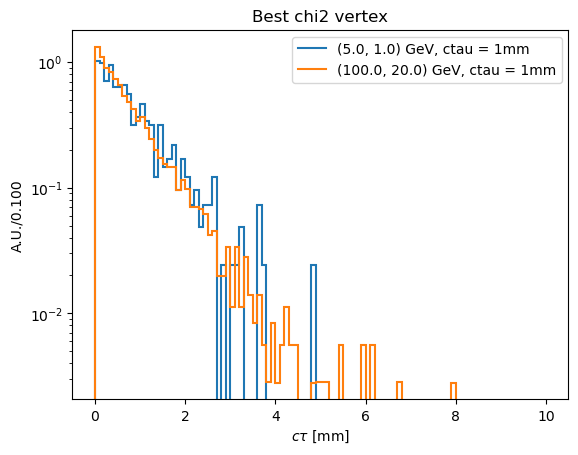

In [43]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'ctau',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,10],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 vertex')
plt.legend()
plt.show()

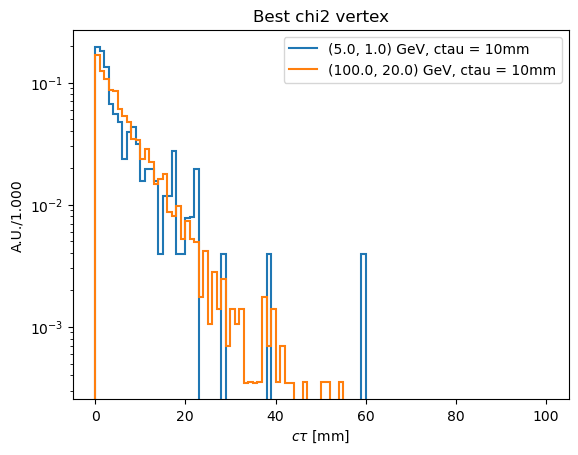

In [44]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'ctau',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 10j,
    'xlim': [0,100],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow

}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [10]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 vertex')
plt.legend()
plt.show()

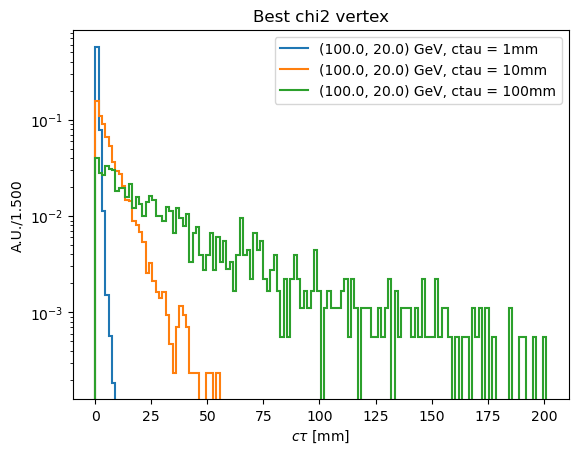

In [45]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'ctau',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 15j,
    'xlim': [0,200],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow

}

# signal points
m1s = [100]
deltas = [0.2]
ctaus = [1,10,100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 vertex')
plt.legend()
plt.show()

### cos_collinear

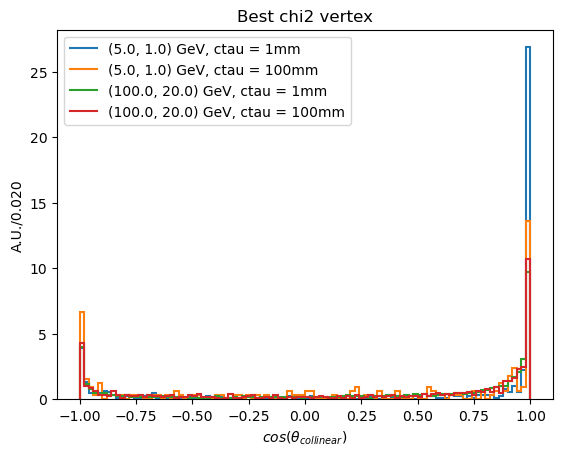

In [46]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'cos_collinear',
    'cut': 'cut5',
}

style_dict = {
    'rebin': 10j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow

}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 vertex')
plt.legend()
plt.show()

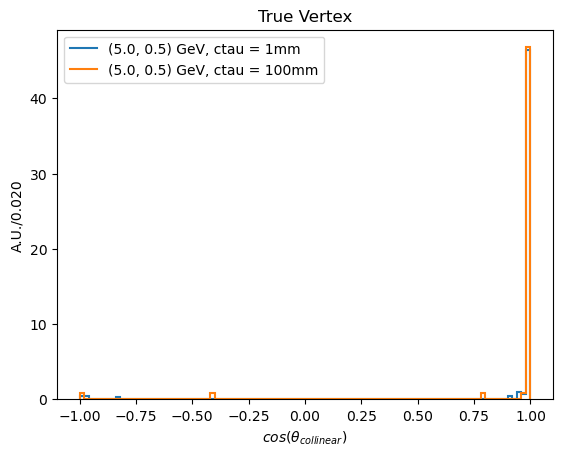

In [47]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'cos_collinear',
    'cut': 'cut5',
}

style_dict = {
    'rebin': 10j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Vertex')
plt.legend()
plt.show()

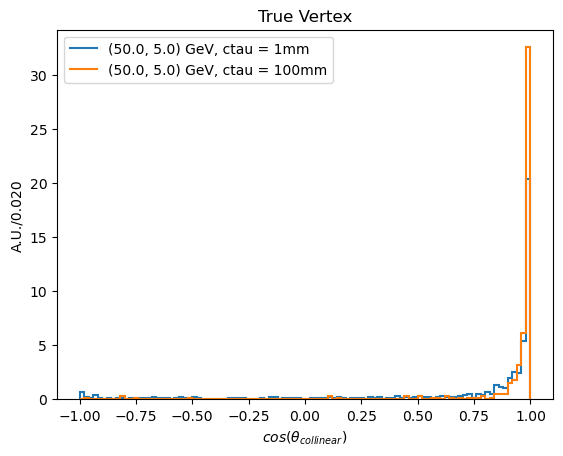

In [48]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'cos_collinear',
    'cut': 'cut5',
}

style_dict = {
    'rebin': 10j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [50]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Vertex')
plt.legend()
plt.show()

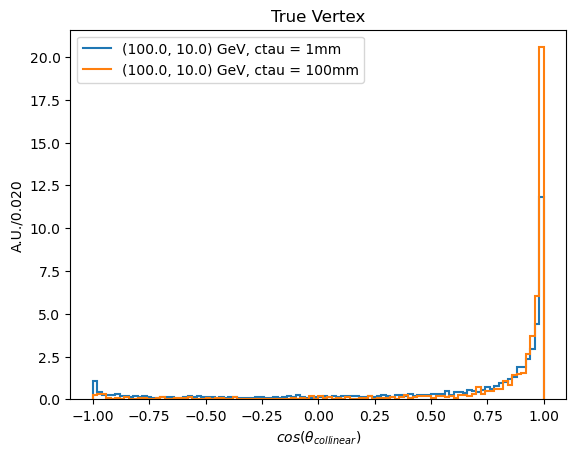

In [49]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'cos_collinear',
    'cut': 'cut5',
}

style_dict = {
    'rebin': 10j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [100]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Vertex')
plt.legend()
plt.show()

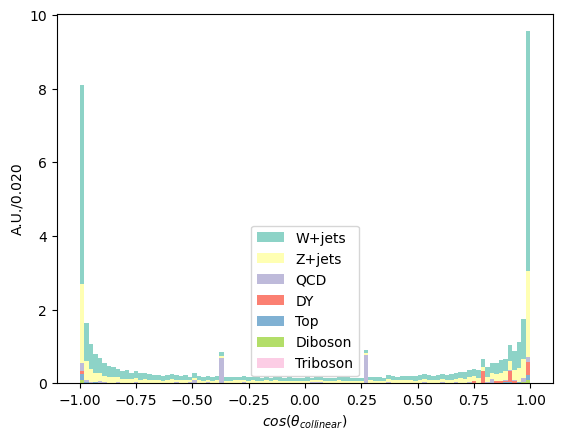

In [50]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'cos_collinear',
    'cut': 'cut5',
}

style_dict = {
    'rebin': 10j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### gen_cos_collinear

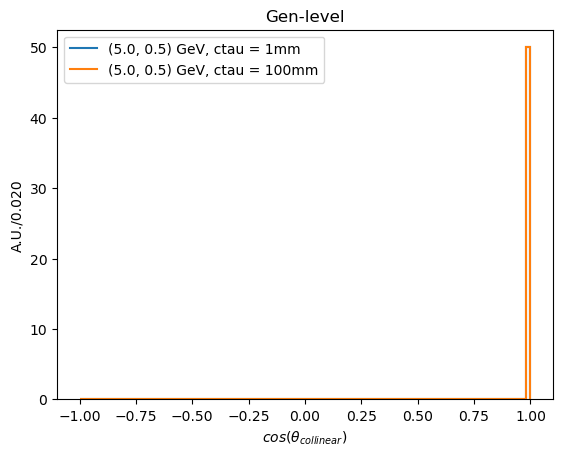

In [51]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'gen_cos_collinear',
    'cut': 'cut5',
}

style_dict = {
    'rebin': 10j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('Gen-level')
plt.legend()
plt.show()

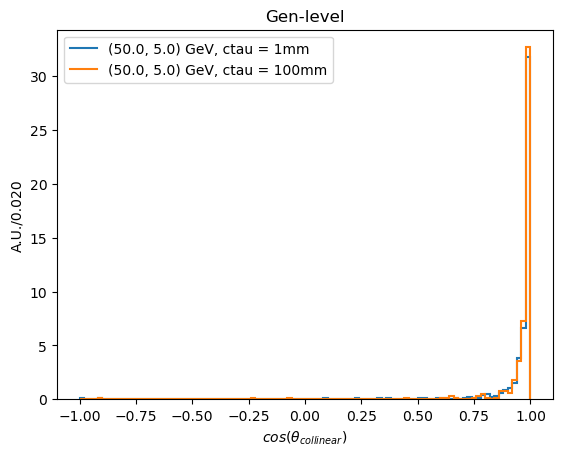

In [52]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'gen_cos_collinear',
    'cut': 'cut5',
}

style_dict = {
    'rebin': 10j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [50]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('Gen-level')
plt.legend()
plt.show()

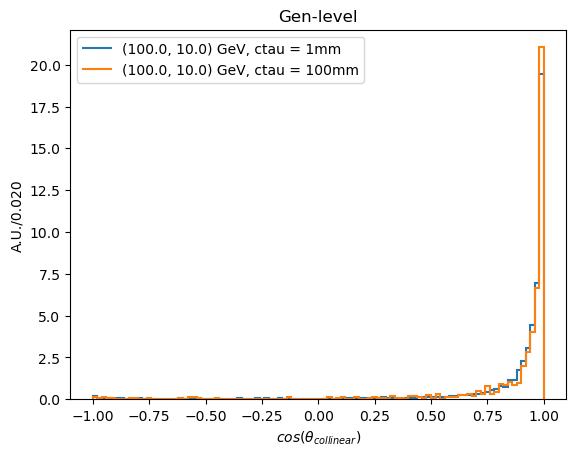

In [53]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'gen_cos_collinear',
    'cut': 'cut5',
}

style_dict = {
    'rebin': 10j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [100]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('Gen-level')
plt.legend()
plt.show()

### projectedLxy

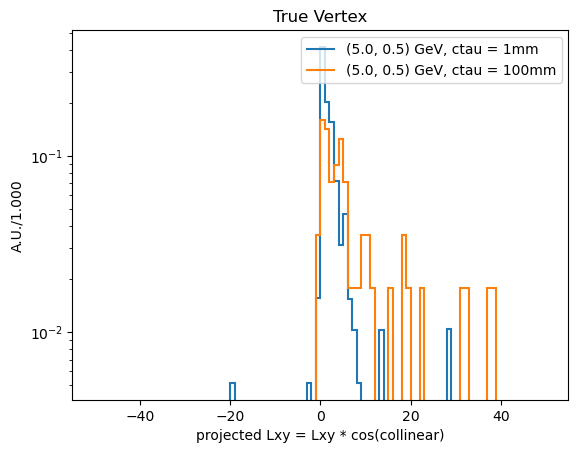

In [54]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_projected',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 40j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': 'projected Lxy = Lxy * cos(collinear)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Vertex')
plt.legend()
plt.show()

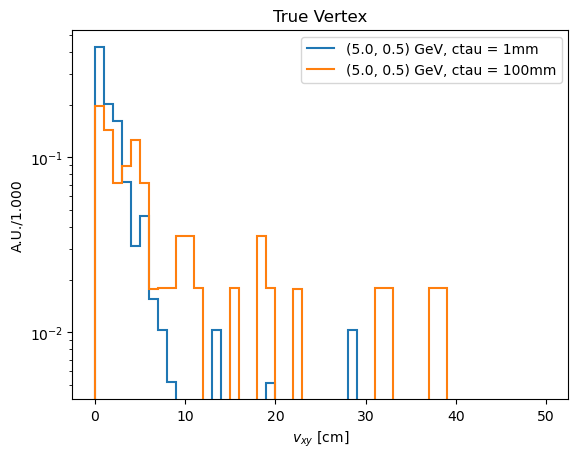

In [55]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 40j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Vertex')
plt.legend()
plt.show()

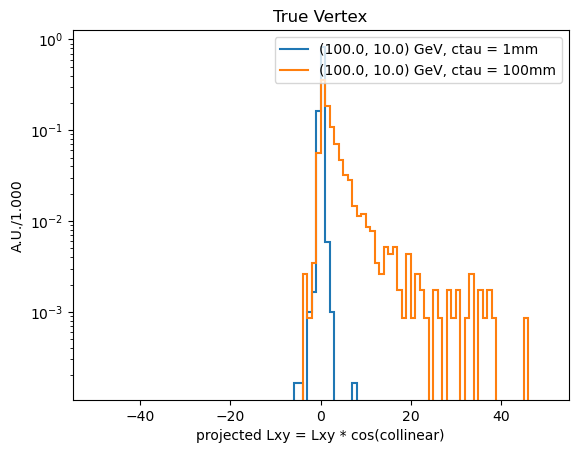

In [56]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_projected',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 40j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': 'projected Lxy = Lxy * cos(collinear)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [100]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Vertex')
plt.legend()
plt.show()

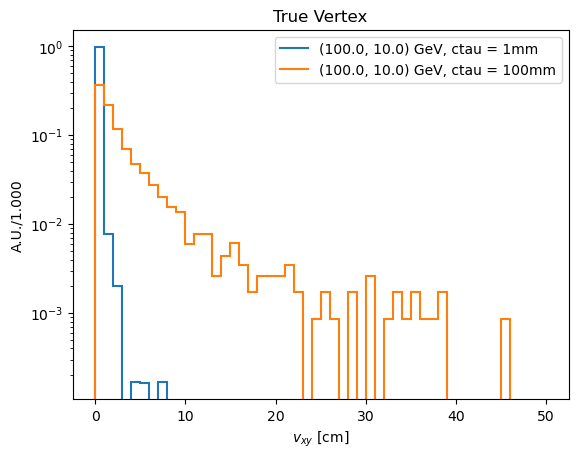

In [57]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 40j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [100]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Vertex')
plt.legend()
plt.show()

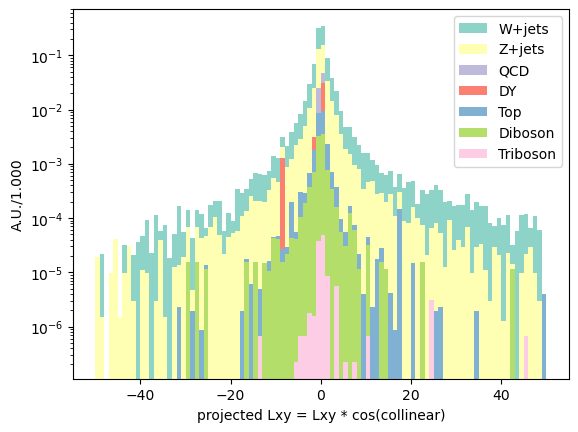

In [58]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_projected',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 40j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': 'projected Lxy = Lxy * cos(collinear)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

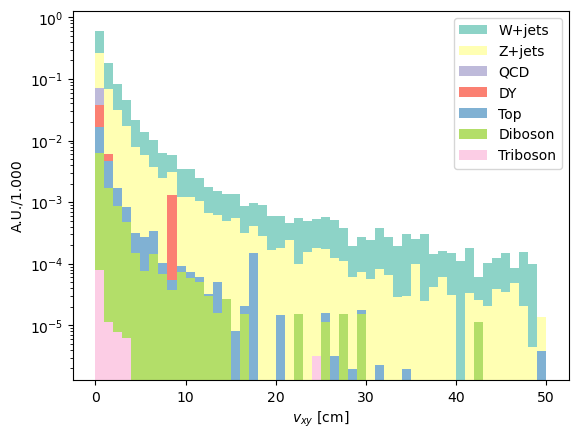

In [59]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 40j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}


# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### gen pT (chi2)

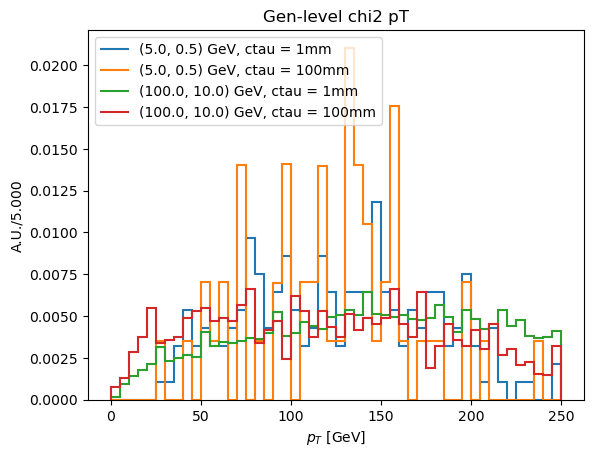

In [60]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'gen_chi2_pt',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 10j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('Gen-level chi2 pT')
plt.legend()
plt.show()

### gen pT (ee)

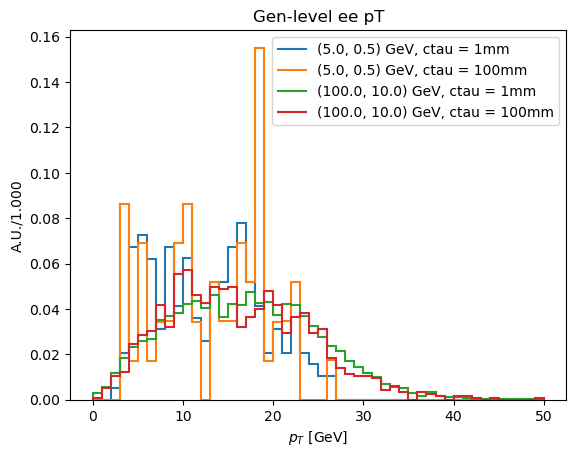

In [61]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'gen_ee_pt',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': [0,50],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('Gen-level ee pT')
plt.legend()
plt.show()

### gen_chi2_ee_pt_ratio

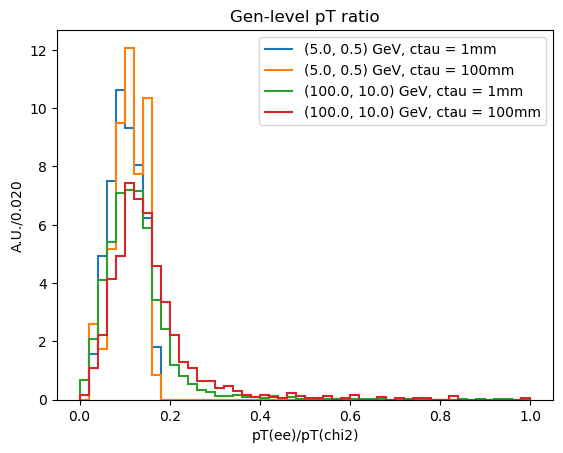

In [62]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'gen_chi2_ee_pt_ratio',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': 'pT(ee)/pT(chi2)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('Gen-level pT ratio')
plt.legend()
plt.show()

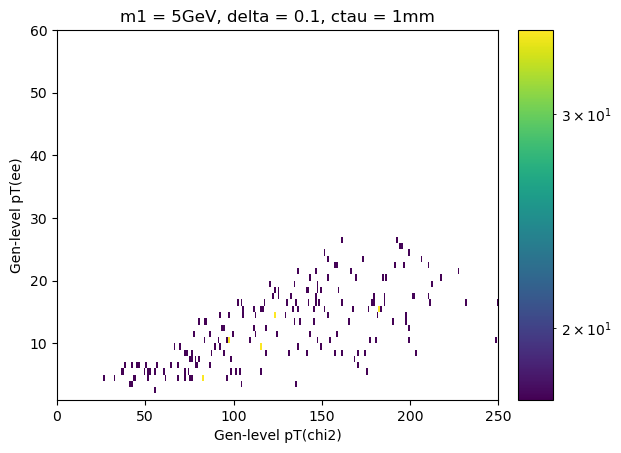

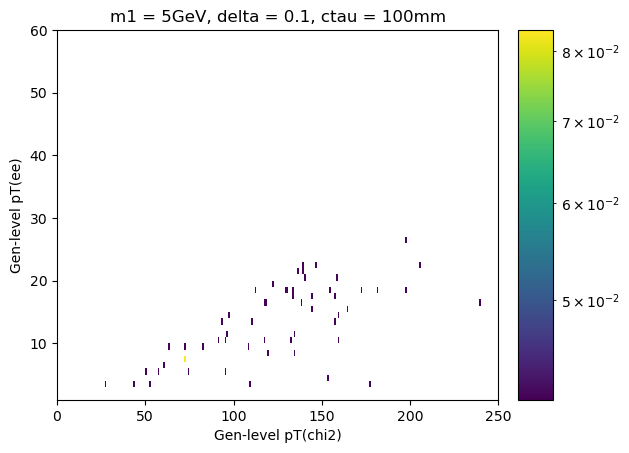

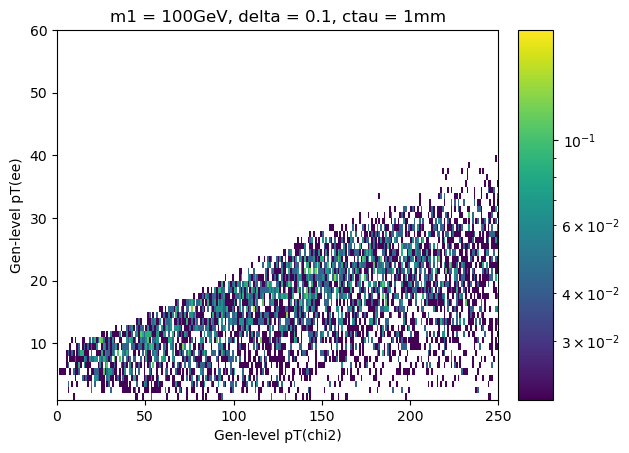

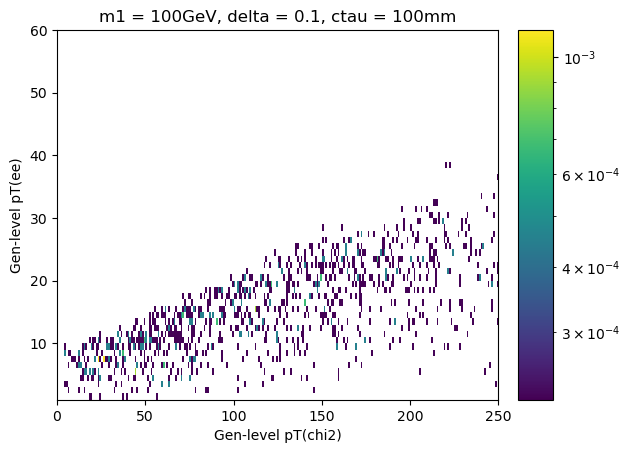

In [30]:
# Plot settings
plot_dict = {
    'variable': 'gen_chi2_pt_vs_gen_ee_pt',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 2j,
    'yrebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0,60],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': 'Gen-level pT(chi2)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': 'Gen-level pT(ee)',   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### abs_cos_collinear

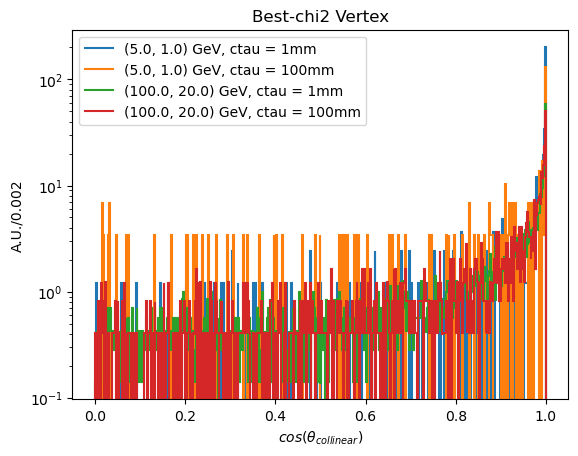

In [31]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'abs_cos_collinear',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,1],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best-chi2 Vertex')
plt.legend()
plt.show()

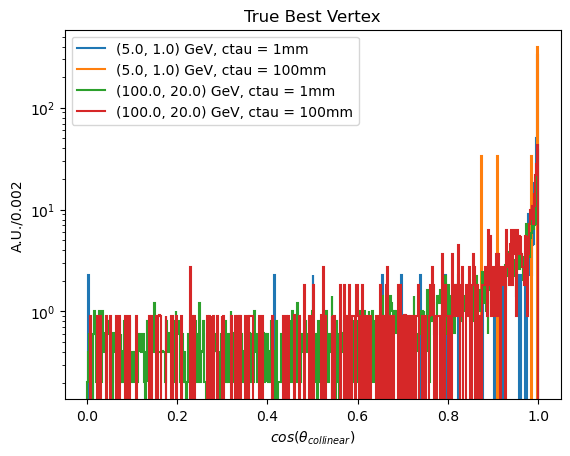

In [32]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'abs_cos_collinear',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,1],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Best Vertex')
plt.legend()
plt.show()

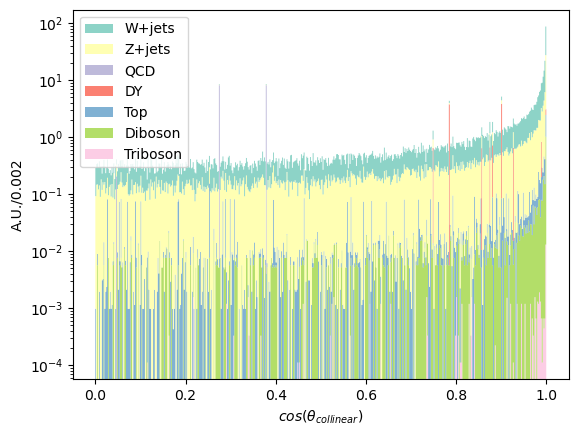

In [33]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_prod_eta

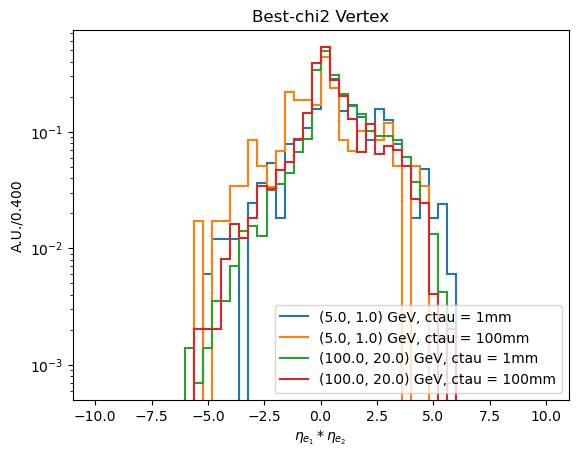

In [60]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_prod_eta',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best-chi2 Vertex')
plt.legend()
plt.show()

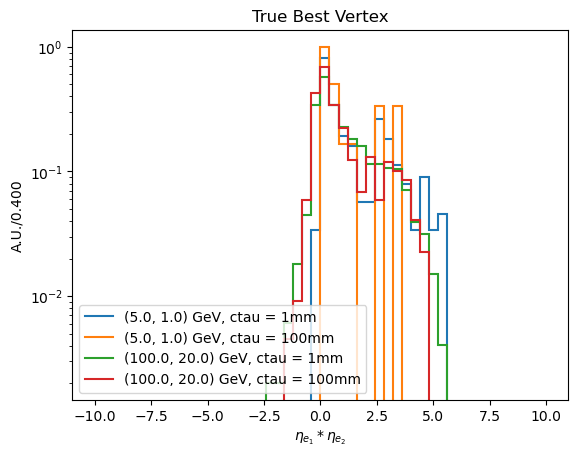

In [61]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_prod_eta',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Best Vertex')
plt.legend()
plt.show()

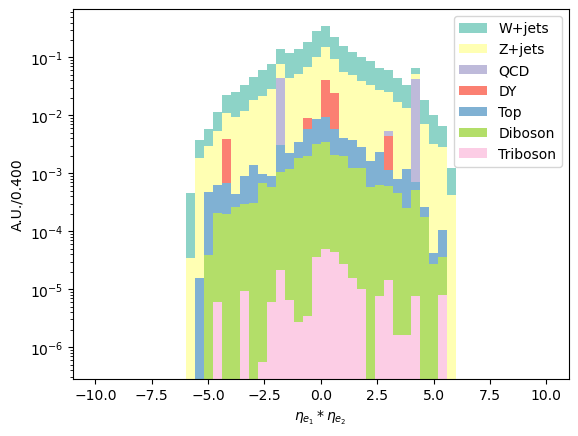

In [62]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_vxy

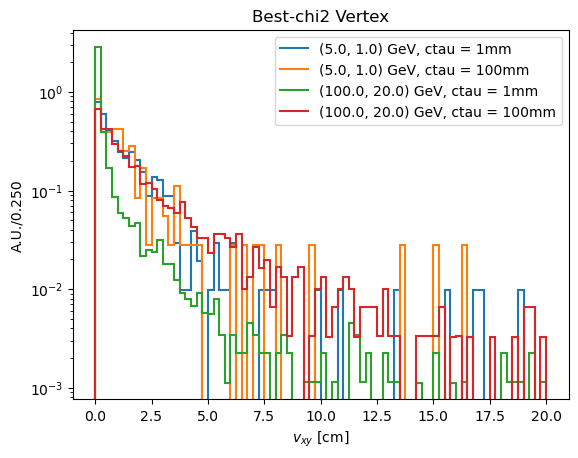

In [63]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 10j,
    'xlim': [0,20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best-chi2 Vertex')
plt.legend()
plt.show()

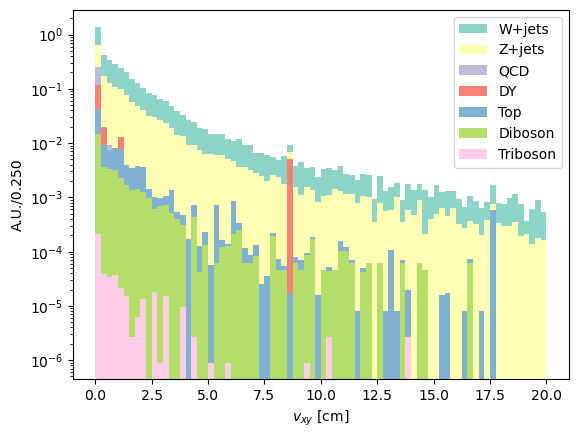

In [64]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

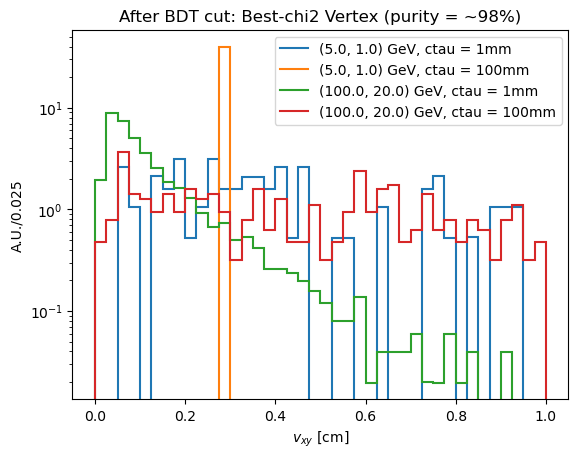

In [65]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy',
    'cut': 'cut10',
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,1],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('After BDT cut: Best-chi2 Vertex (purity = ~98%)')
plt.legend()
plt.show()

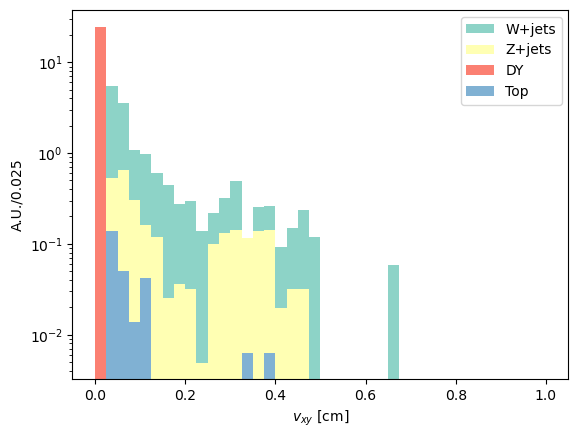

In [66]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy',
    'cut': 'cut10',
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,1],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'W+jets', 'Z+jets', 'DY'])

### dxy1

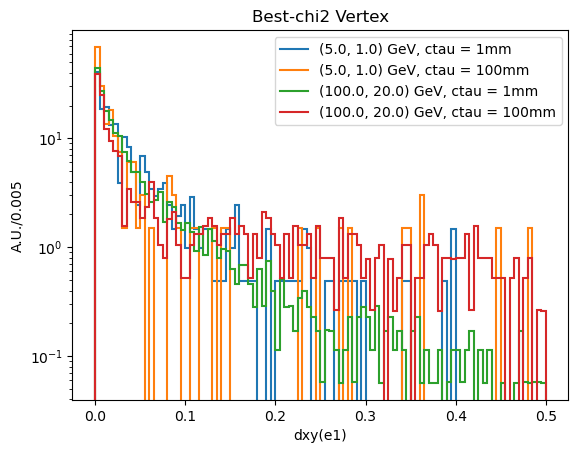

In [68]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dxy1',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 5j,
    'xlim': [0,0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': 'dxy(e1)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best-chi2 Vertex')
plt.legend()
plt.show()

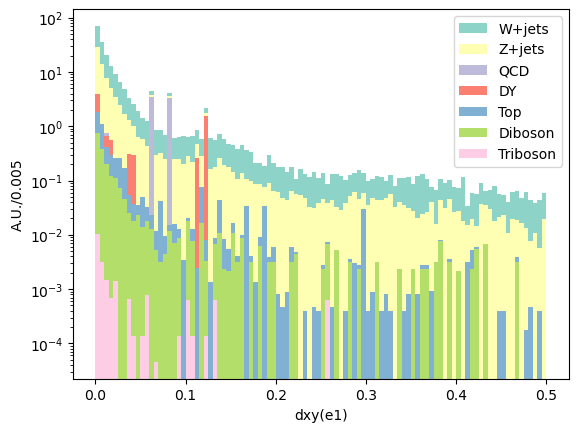

In [69]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

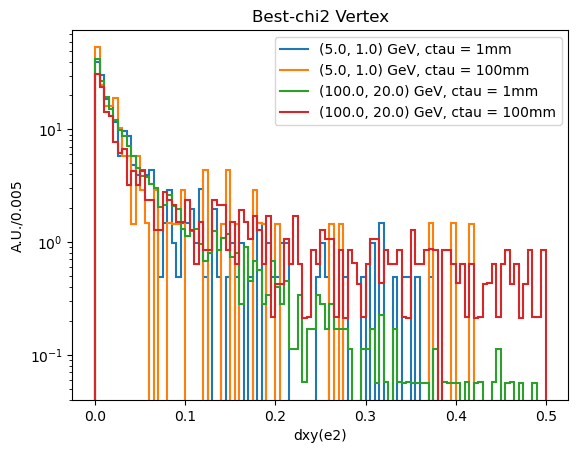

In [70]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dxy2',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 5j,
    'xlim': [0,0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': 'dxy(e2)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best-chi2 Vertex')
plt.legend()
plt.show()

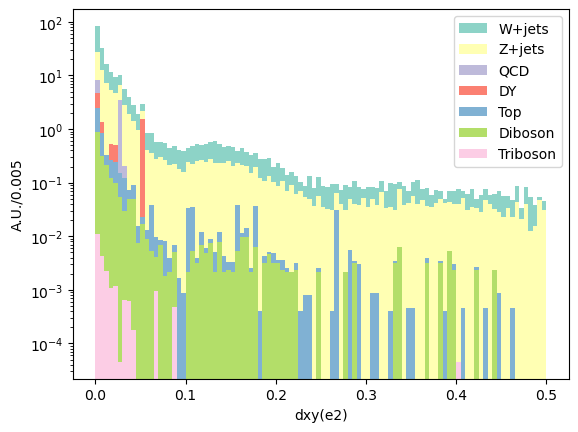

In [71]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_minDxy

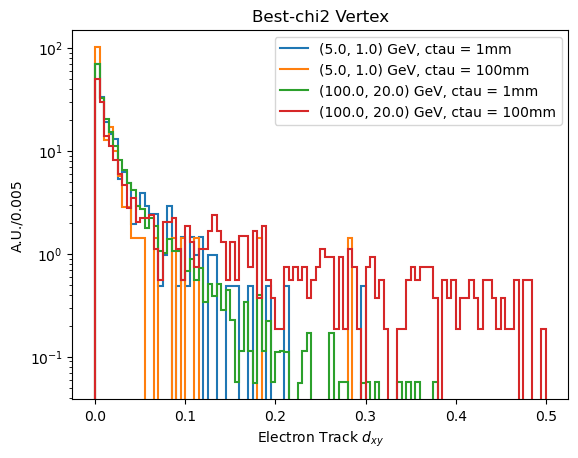

In [73]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_minDxy',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 5j,
    'xlim': [0,0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best-chi2 Vertex')
plt.legend()
plt.show()

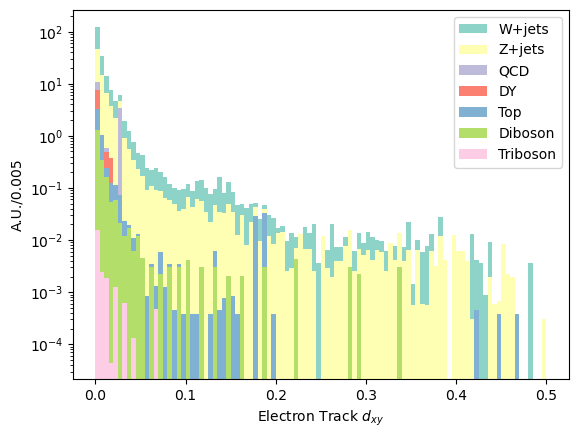

In [74]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

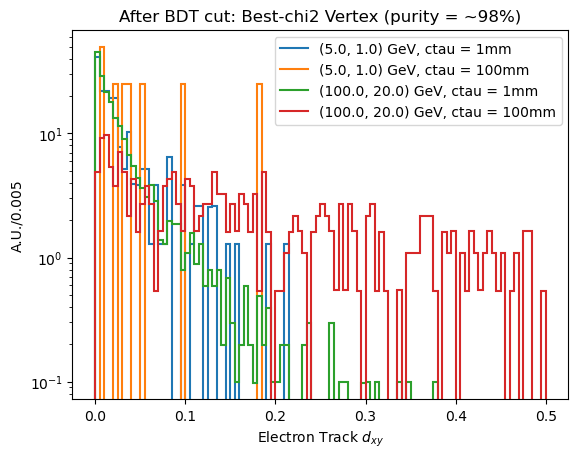

In [75]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_minDxy',
    'cut': 'cut10',
}

style_dict = {
    'rebin': 5j,
    'xlim': [0,0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('After BDT cut: Best-chi2 Vertex (purity = ~98%)')
plt.legend()
plt.show()

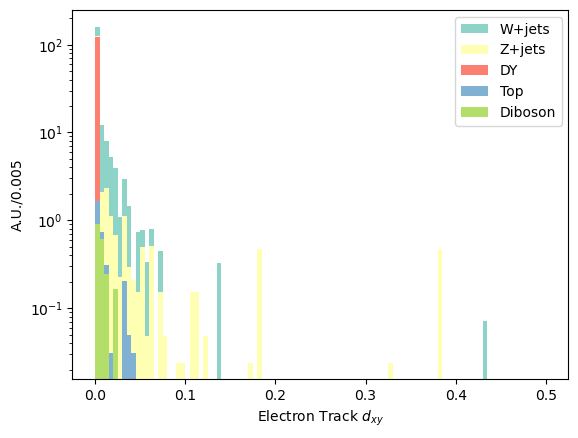

In [76]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_minDxy',
    'cut': 'cut10',
}

style_dict = {
    'rebin': 5j,
    'xlim': [0,0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'W+jets', 'Z+jets', 'DY', 'Diboson'])

### sel_vtx_minDz

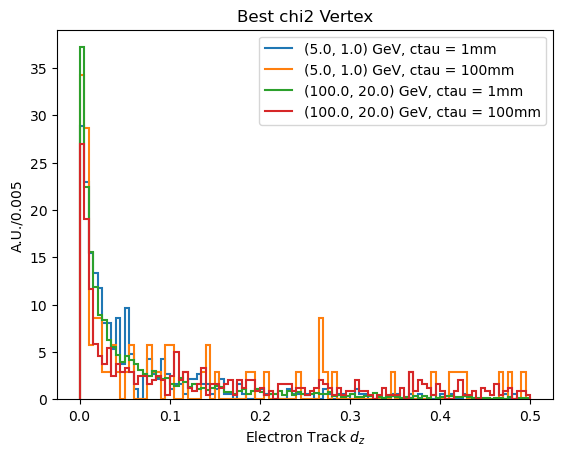

In [77]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_minDz',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 5j,
    'xlim': [0,0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

/uscms/home/kyungmip/nobackup/miniconda3/envs/coffea/lib/python3.8/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


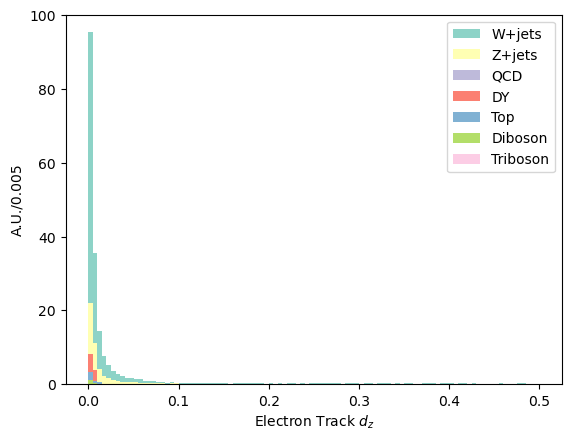

In [78]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_deltaDxy

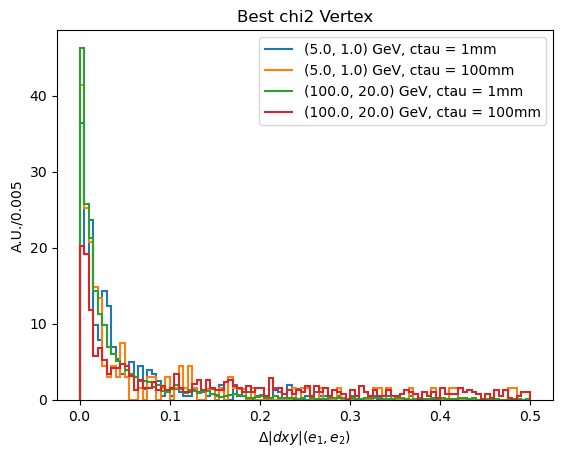

In [79]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_deltaDxy',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 5j,
    'xlim': [0,0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': r'$\Delta |dxy|(e_{1},e_{2})$',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

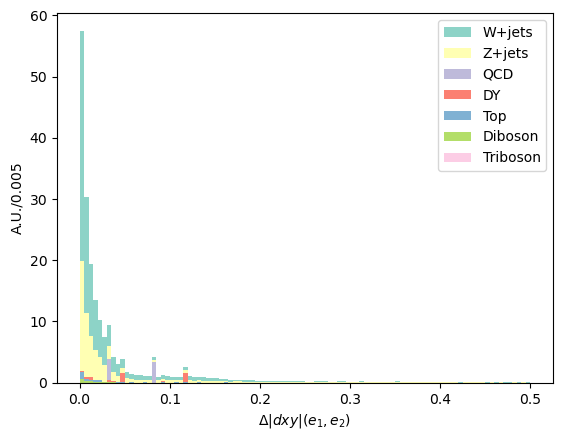

In [80]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_deltaDz

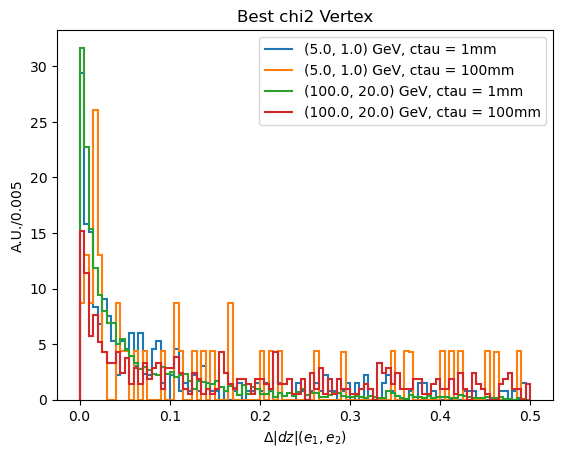

In [81]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_deltaDz',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 5j,
    'xlim': [0,0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': r'$\Delta |dz|(e_{1},e_{2})$',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

/uscms/home/kyungmip/nobackup/miniconda3/envs/coffea/lib/python3.8/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


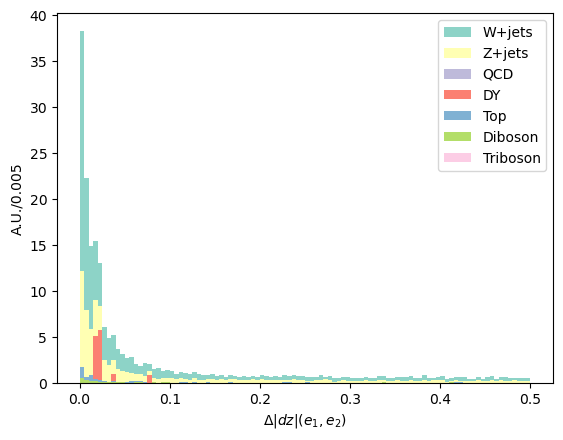

In [82]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_vxySignif

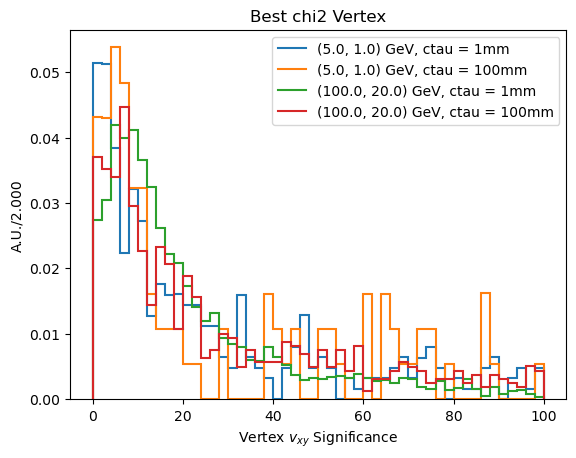

In [83]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxySignif',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

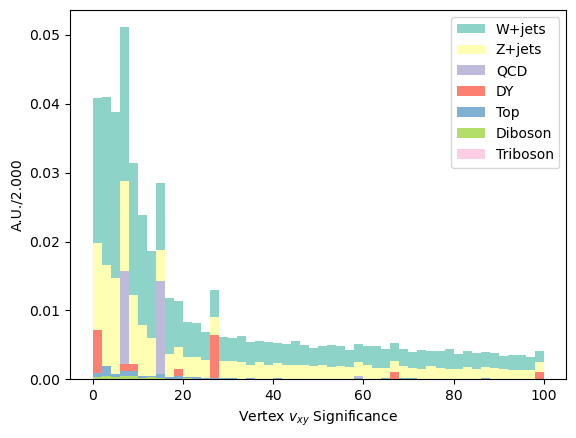

In [84]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

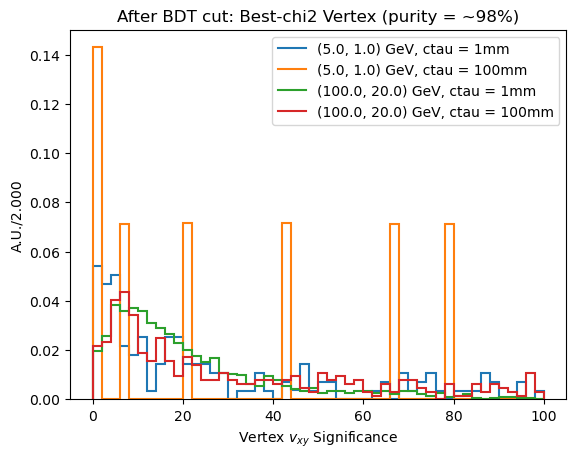

In [85]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxySignif',
    'cut': 'cut10',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('After BDT cut: Best-chi2 Vertex (purity = ~98%)')
plt.legend()
plt.show()

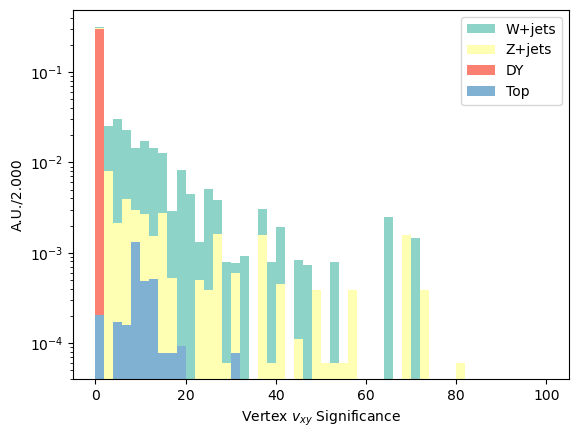

In [86]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxySignif',
    'cut': 'cut10',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'W+jets', 'Z+jets', 'DY'])

### sel_vtx_type

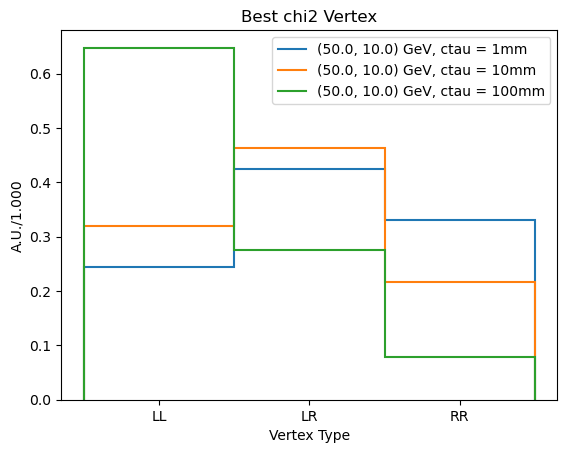

In [87]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_type',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [50]
deltas = [0.2]
ctaus = [1, 10, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

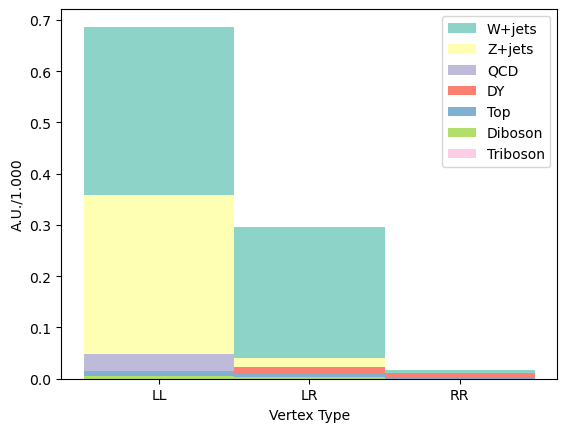

In [88]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_chi2

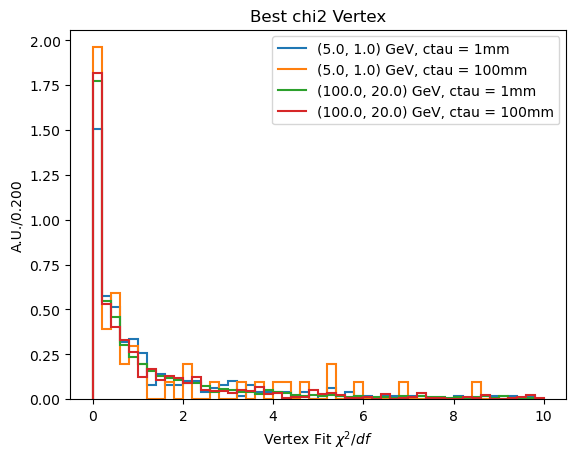

In [89]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_chi2',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,10],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

/uscms/home/kyungmip/nobackup/miniconda3/envs/coffea/lib/python3.8/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


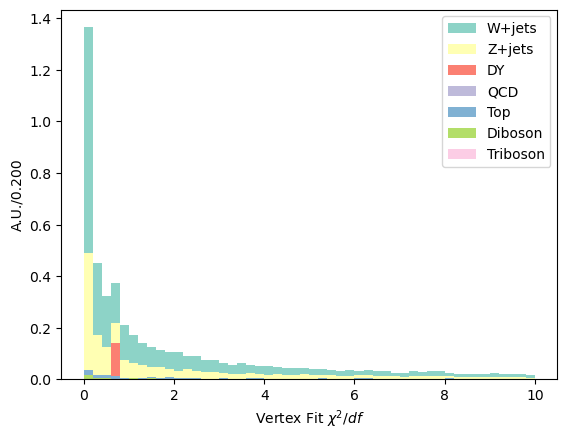

In [90]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

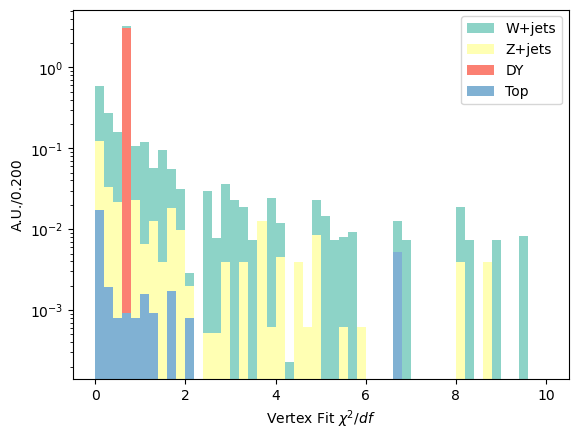

In [91]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_chi2',
    'cut': 'cut10',
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,10],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'W+jets', 'Z+jets', 'DY'])

### sel_vtx_dR

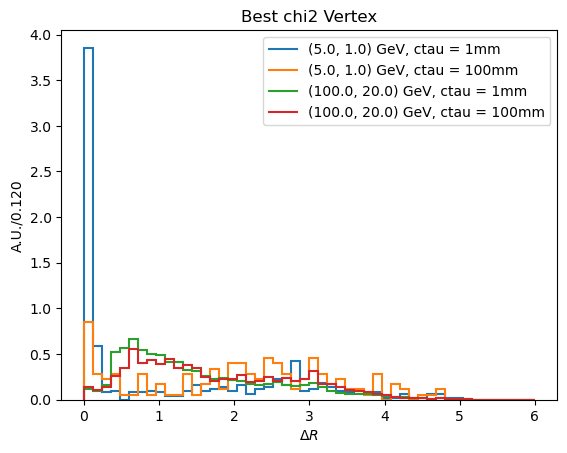

In [92]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

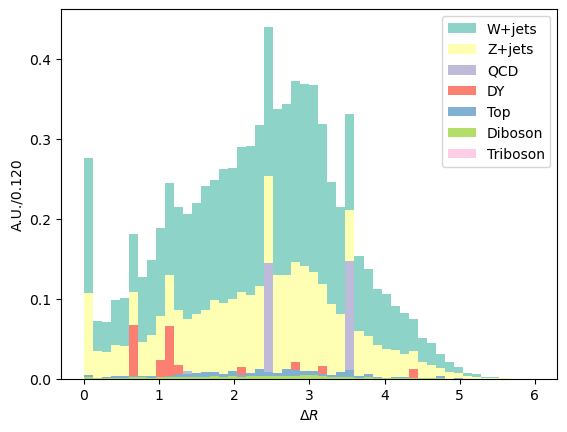

In [93]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

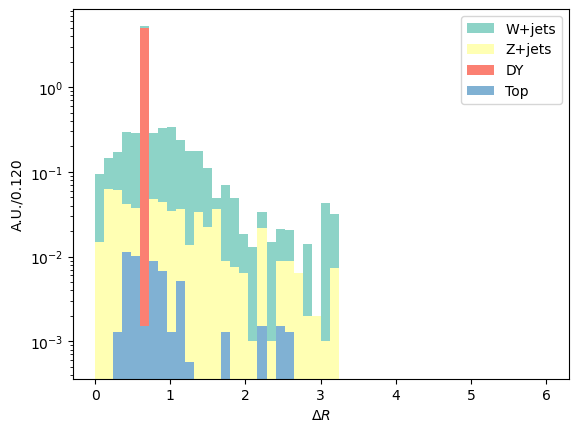

In [94]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR',
    'cut': 'cut10',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'W+jets', 'Z+jets', 'DY'])

### sel_vtx_dEta

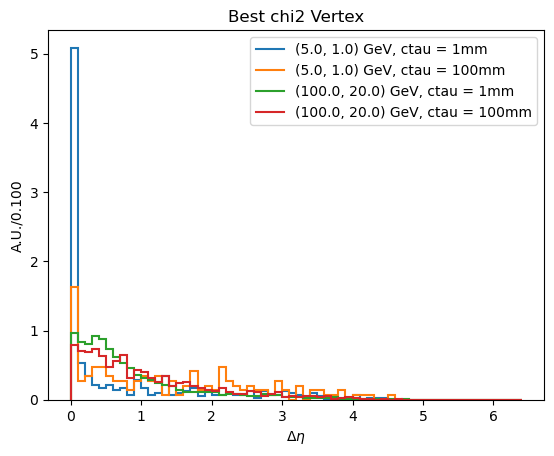

In [95]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dEta',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

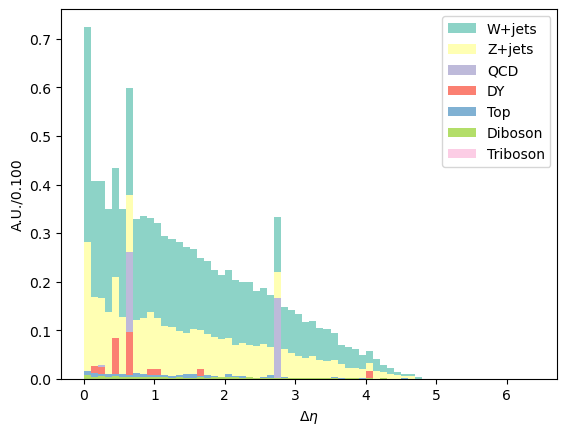

In [96]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_dPhi

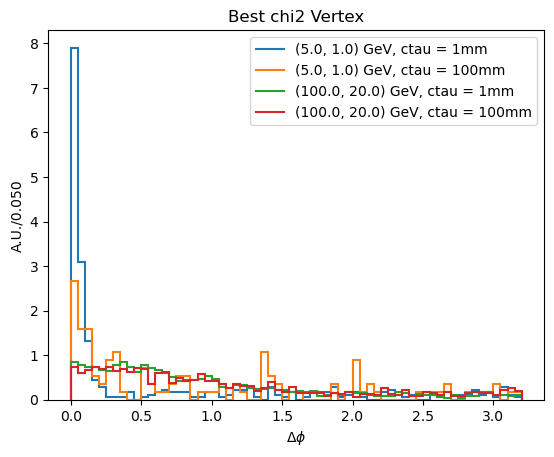

In [97]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dPhi',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

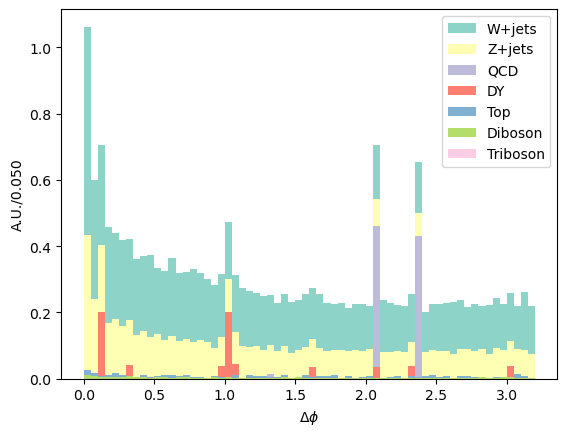

In [98]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_sign_eta

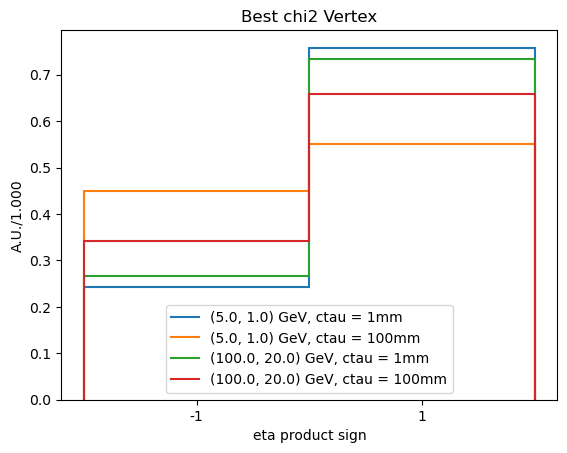

In [99]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_sign_eta',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

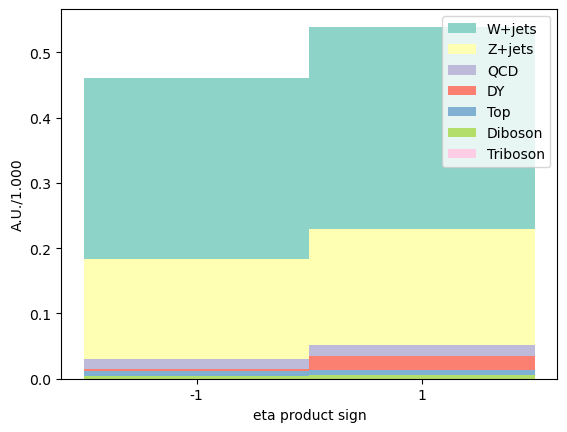

In [100]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_METdPhi

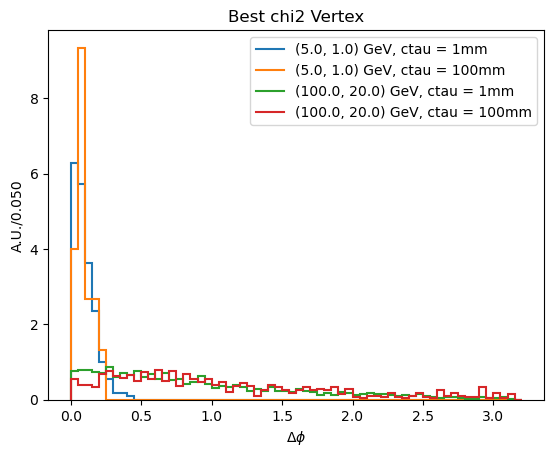

In [101]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_METdPhi',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

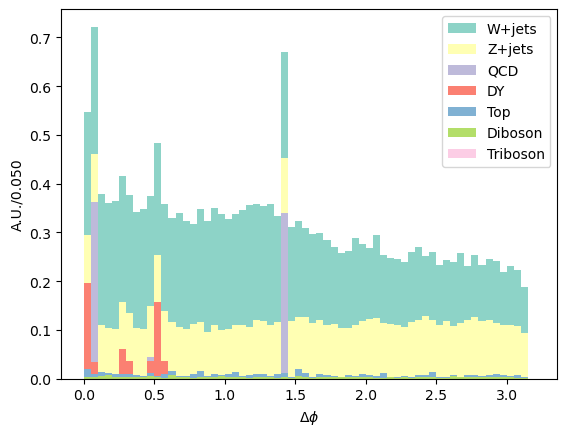

In [102]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_pt

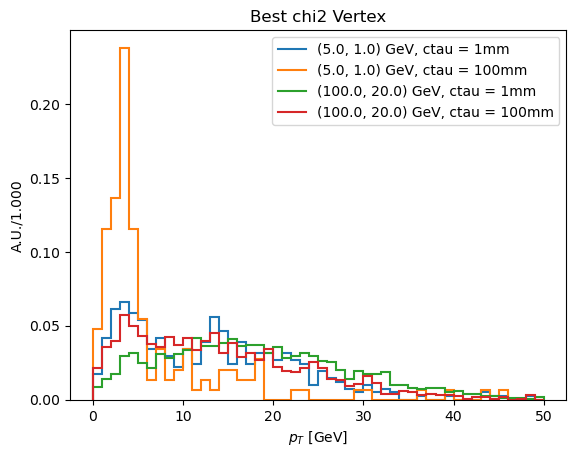

In [103]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_pt',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

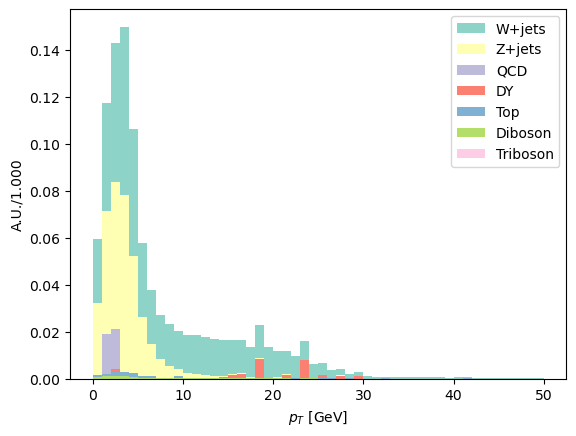

In [104]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_eta

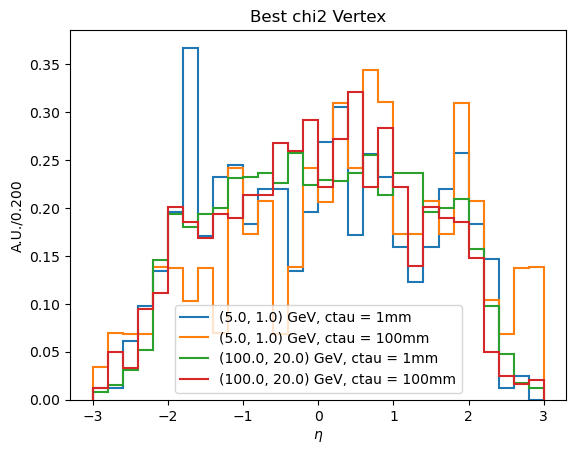

In [105]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_eta',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

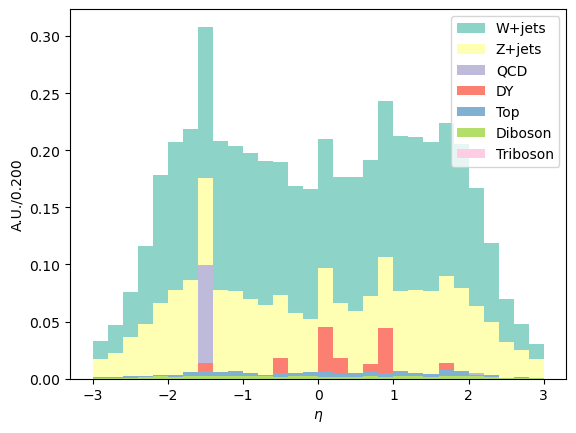

In [106]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_phi

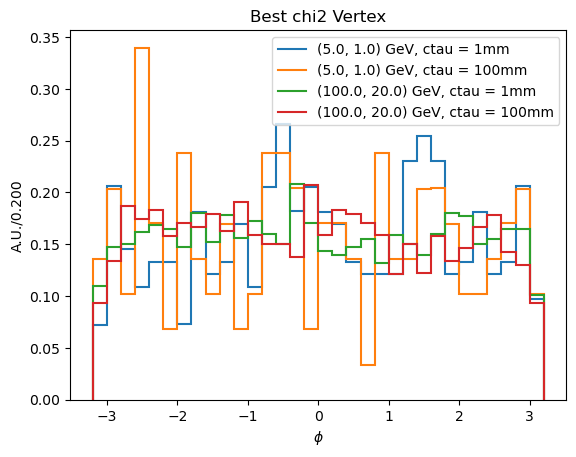

In [107]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_phi',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

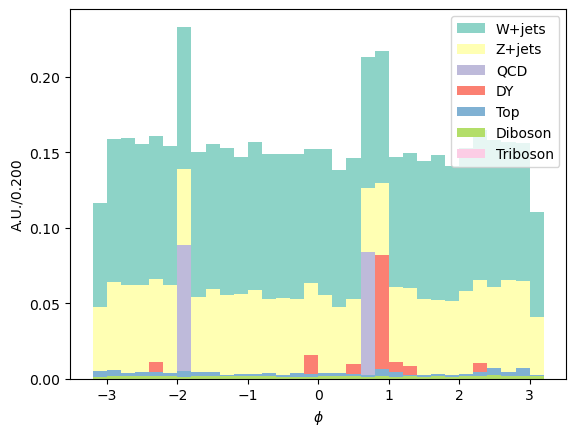

In [108]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### sel_vtx_mass

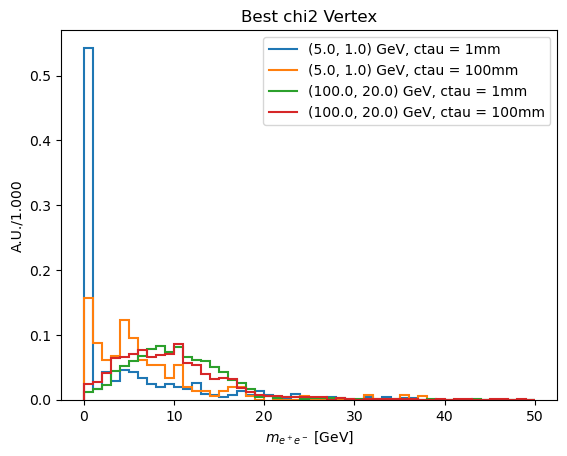

In [109]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_mass',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

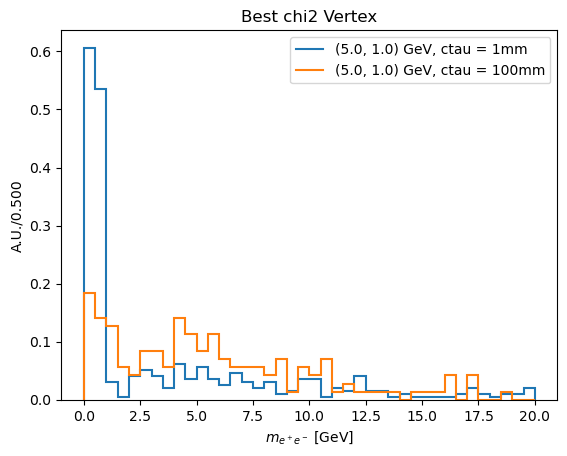

In [110]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_mass',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

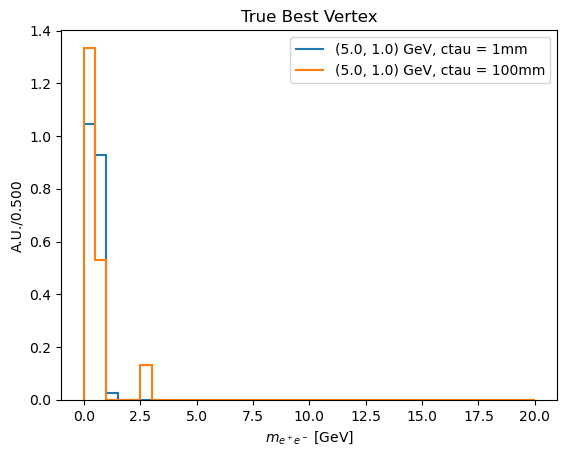

In [111]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_mass',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': [0,20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_dict)

plt.title('True Best Vertex')
plt.legend()
plt.show()

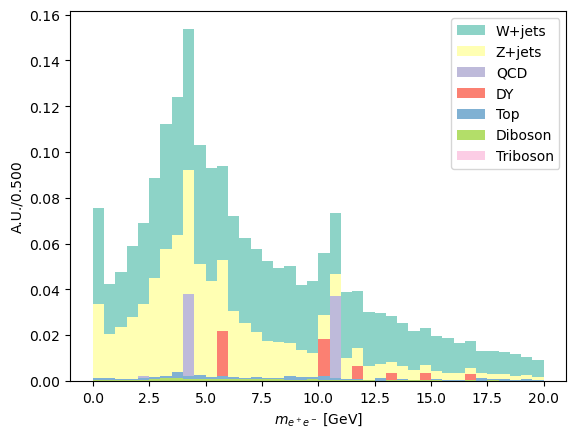

In [112]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

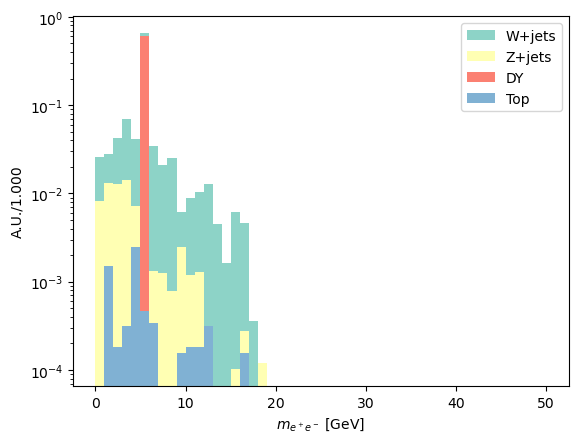

In [113]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'sel_vtx_mass',
    'cut': 'cut10',
}

style_dict = {
    'rebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': True, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict, processes=['Top', 'W+jets', 'Z+jets', 'DY'])

### nLpt_Electron

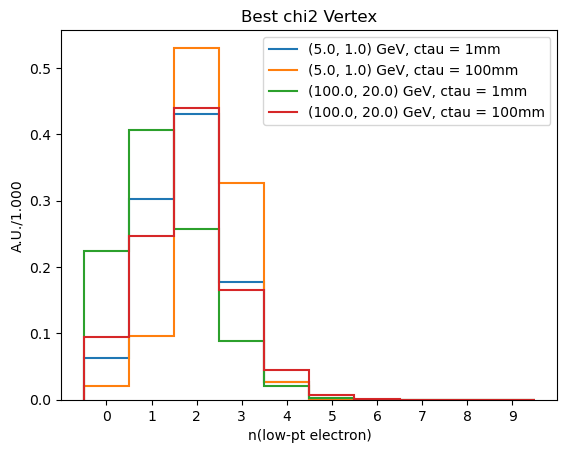

In [114]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'nLpt_Electron',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': 'n(low-pt electron)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

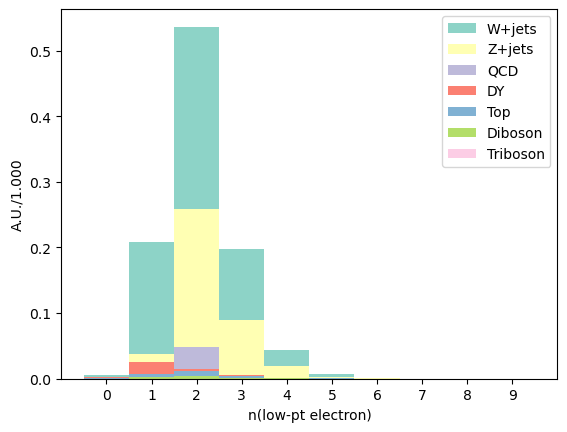

In [115]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### nPF_Electron

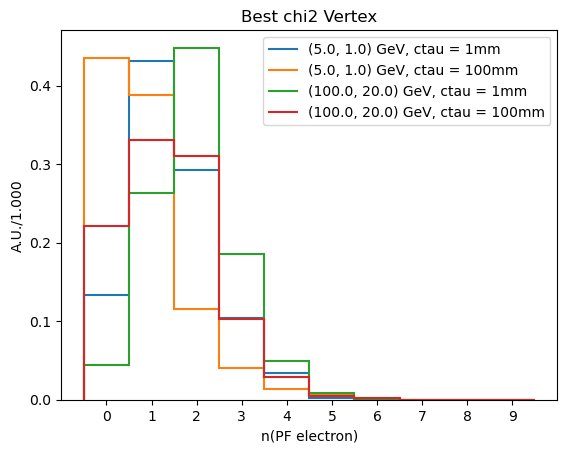

In [116]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'nPF_Electron',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': 'n(PF electron)',   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

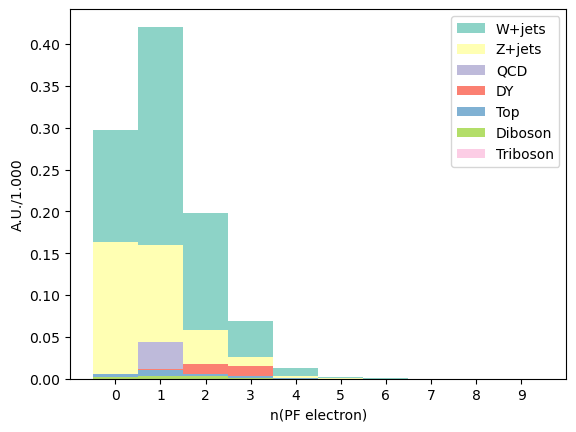

In [117]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### nElectron

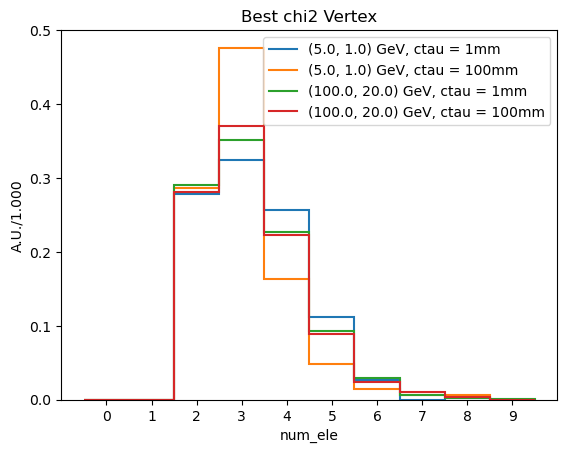

In [118]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'nElectron',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

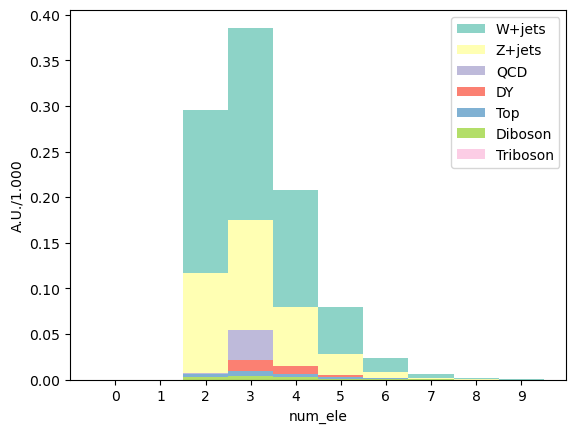

In [119]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

### nGoodVtx

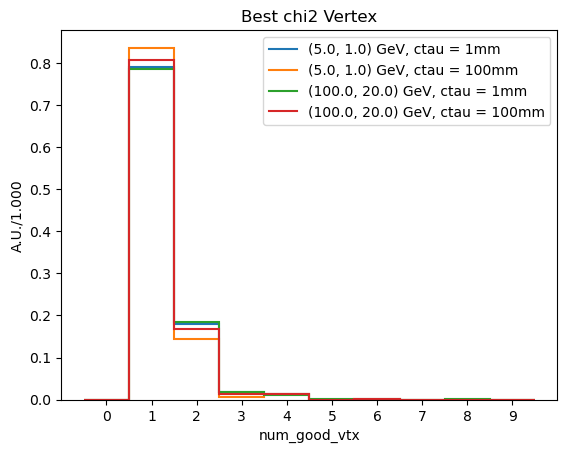

In [120]:
fig, ax = plt.subplots()

# Plot settings
plot_dict = {
    'variable': 'nGoodVtx',
    'cut': 'cut9',
}

style_dict = {
    'rebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doDensity': True,
    'doYerr': False, 
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'label': None,    # if None, the default will show up; otherwise give as a string, i.e. 'Highest ctau signal samples'
    'flow': None,     # overflow
}

# signal points
m1s = [5, 100]
deltas = [0.2]
ctaus = [1, 100]

# Plot for variables signal points
for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            utils.plot_signal_1D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_dict)

plt.title('Best chi2 Vertex')
plt.legend()
plt.show()

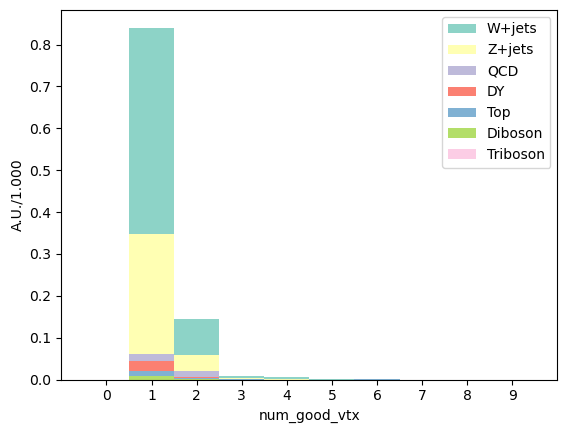

In [121]:
fig, ax = plt.subplots()

# bkg
utils.plot_bkg_1d(ax, bkg_histos, plot_dict, style_dict)

# Plot 2D

Text(0.5, 1.0, 'All Background')

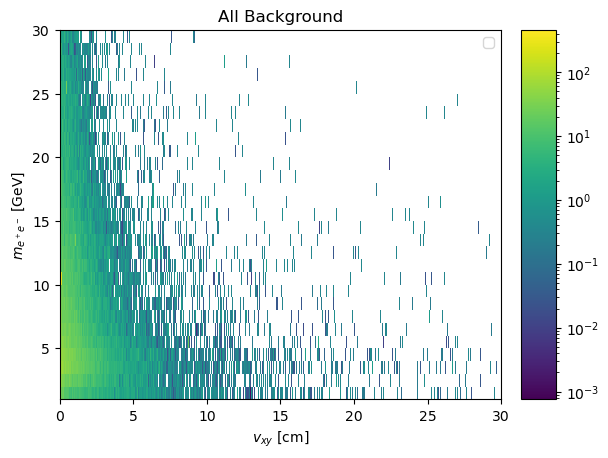

In [122]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_mass',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 2j,
    'yrebin': 2j,
    'xlim': [0,30],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0,30],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

fig, ax = plt.subplots()

utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict)

plt.title('All Background')
#utils.plot_bkg_2D(ax, bkg_histos, plot_dict, style_2d_dict, processes = ['Z+jets', 'W+jets', 'DY'])


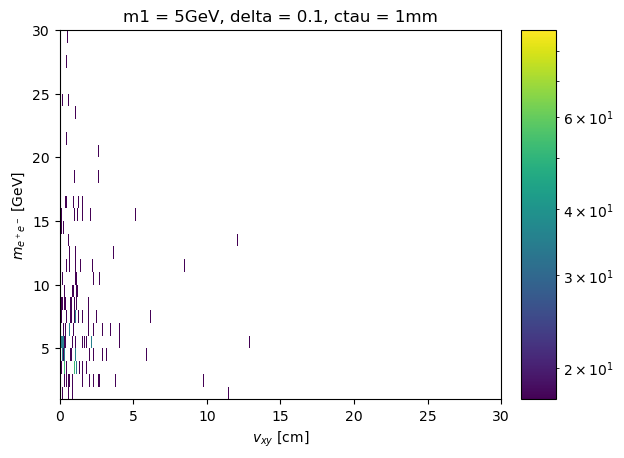

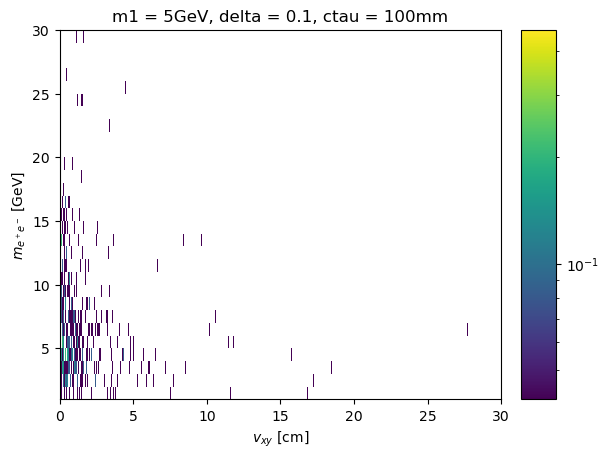

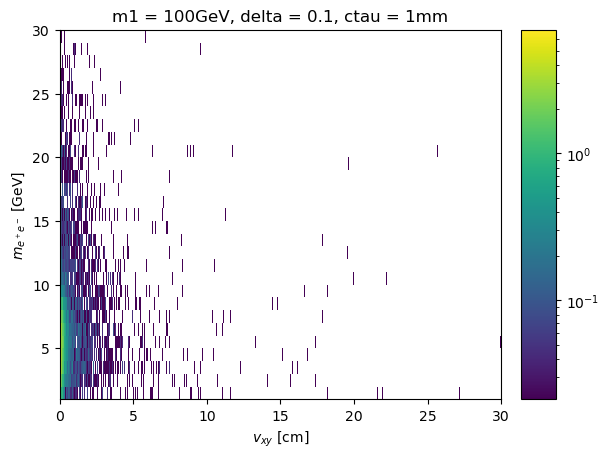

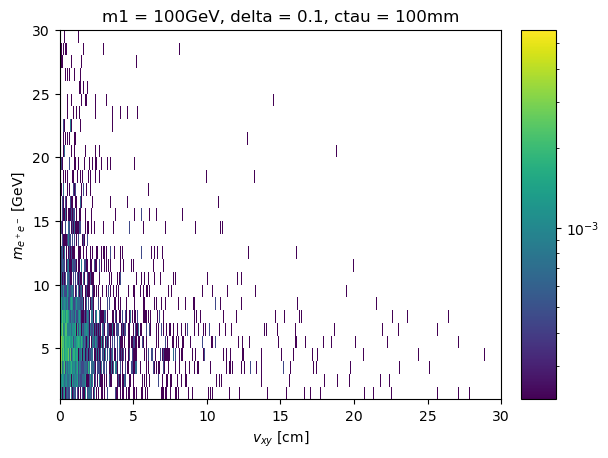

In [123]:

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

In [124]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_mass',
    'cut': 'cut9',
}

style_dict = {
    'xrebin': 2j,
    'yrebin': 2j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}


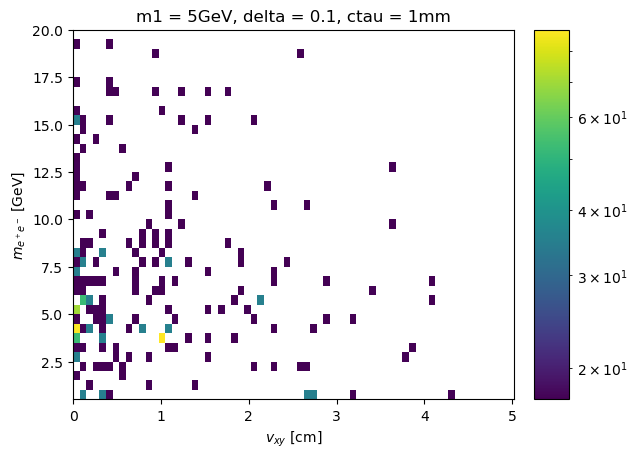

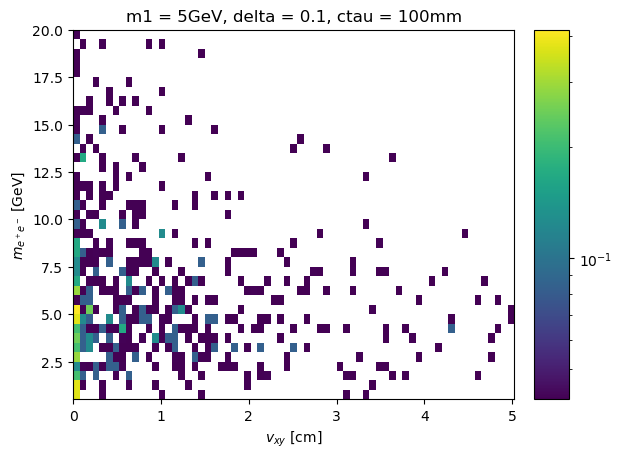

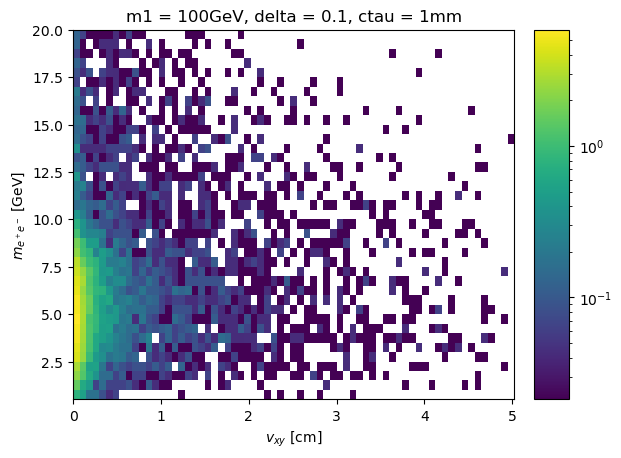

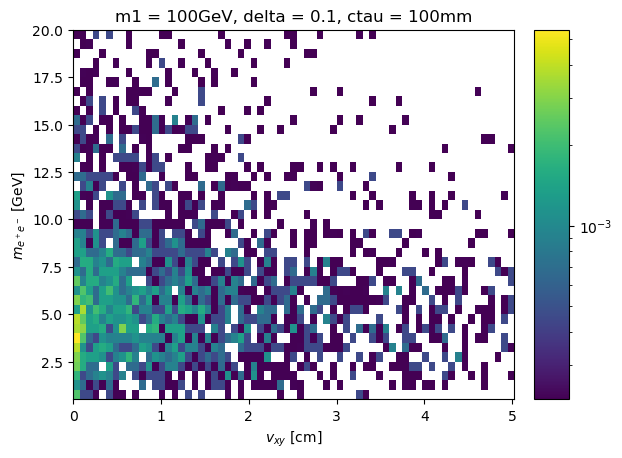

In [125]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_mass',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 3j,
    'yrebin': 1j,
    'xlim': [0, 5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': True,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}


m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### dxy1_vs_dxy2

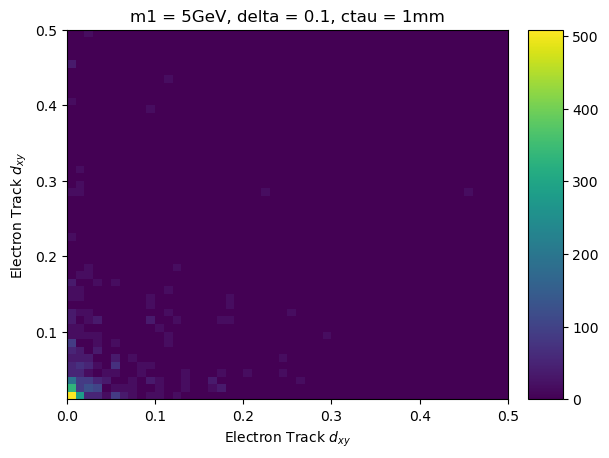

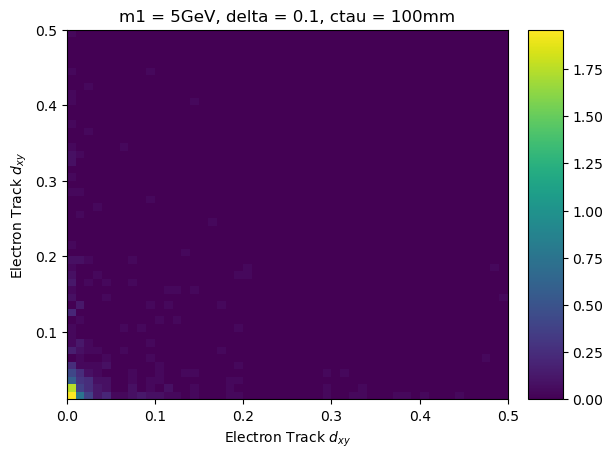

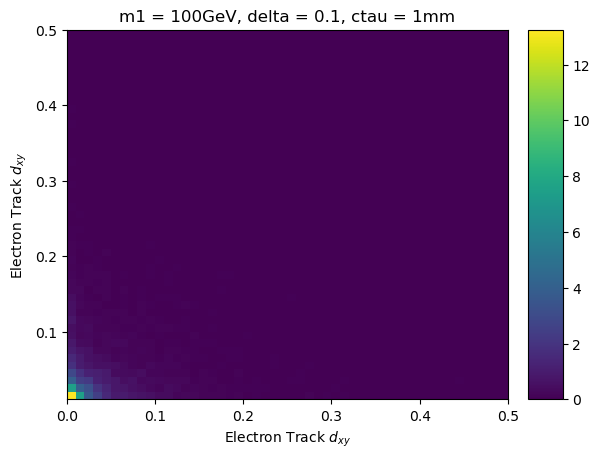

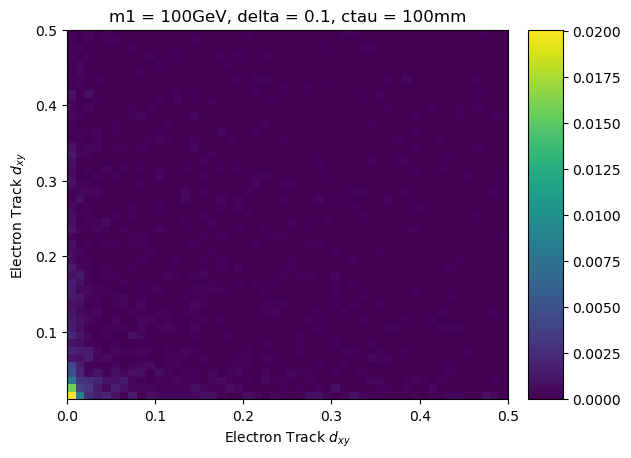

In [126]:
# Plot settings
plot_dict = {
    'variable': 'dxy1_vs_dxy2',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': [0, 0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0, 0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}


m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxy_vs_mindxy

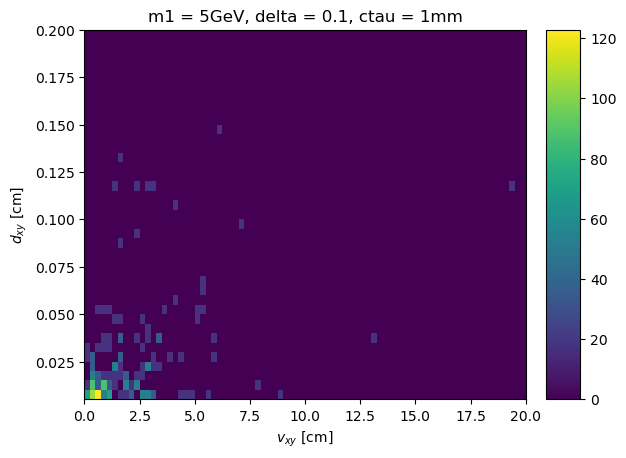

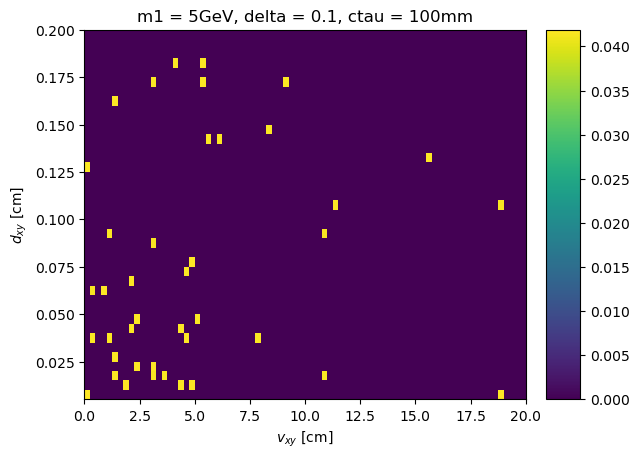

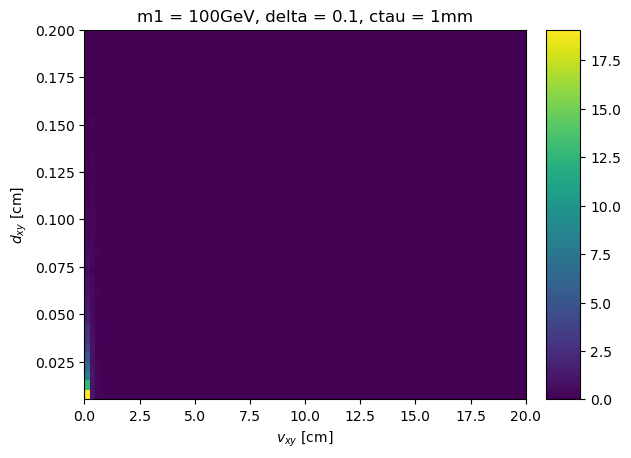

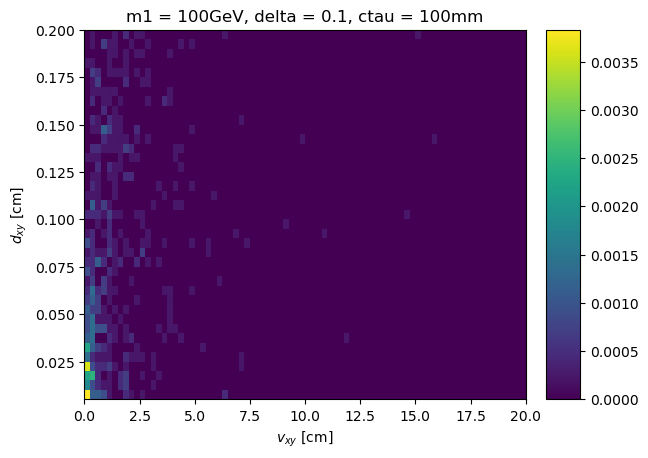

In [127]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_mindxy',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0, 0.5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxy_vs_sel_vtx_chi2

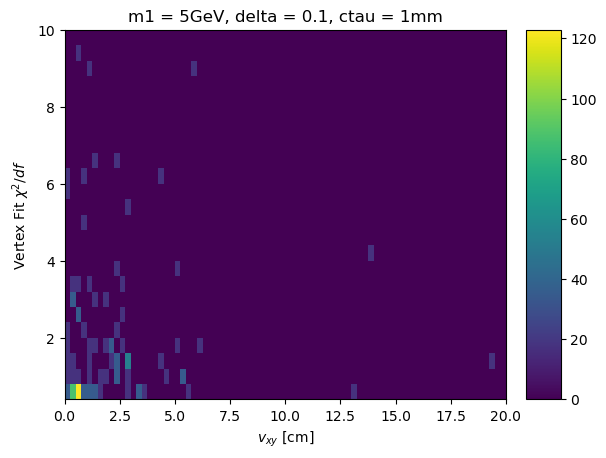

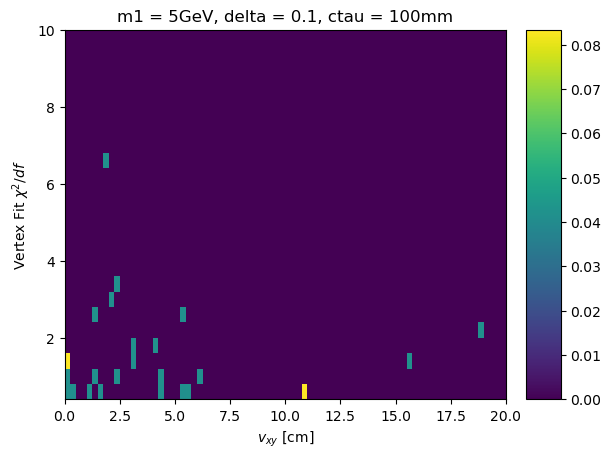

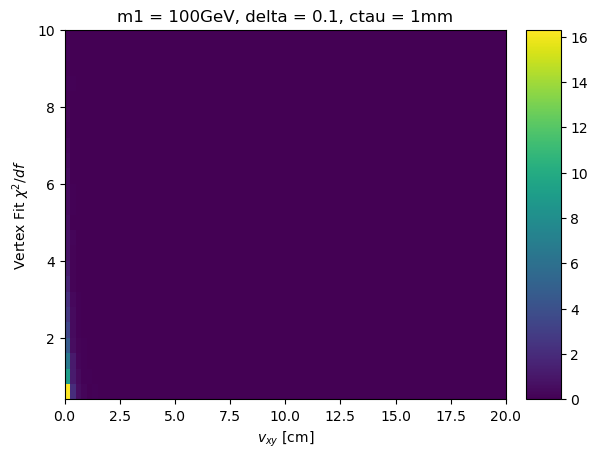

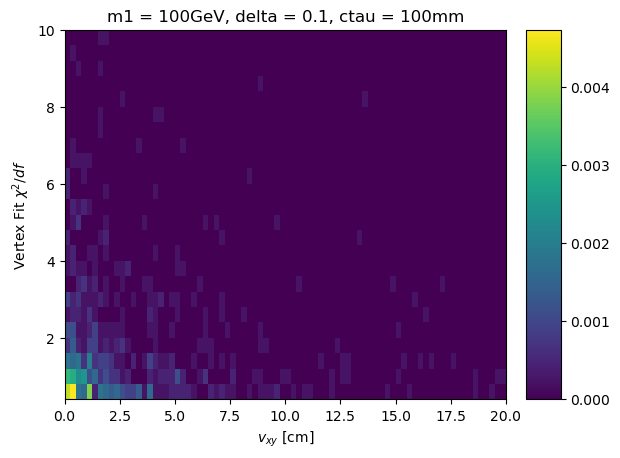

In [128]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_chi2',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 2j,
    'xlim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0, 10],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxy_vs_sel_vtx_dR

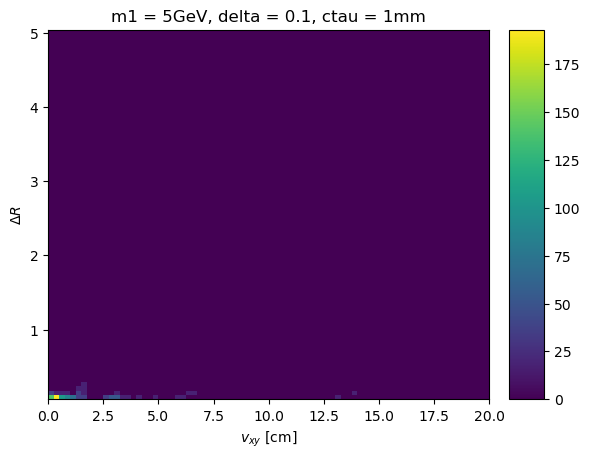

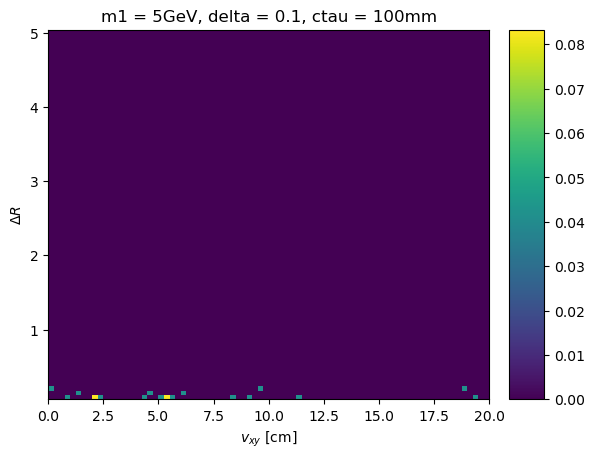

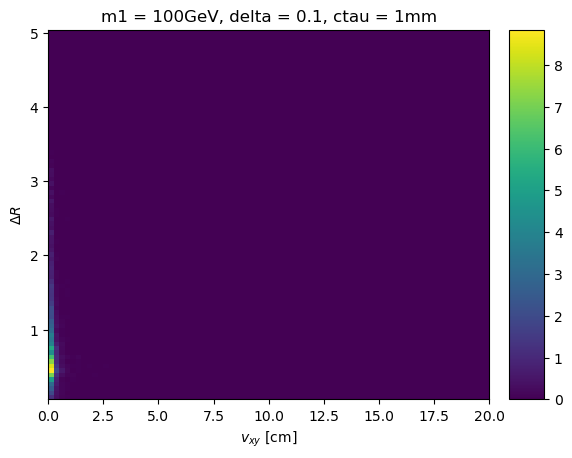

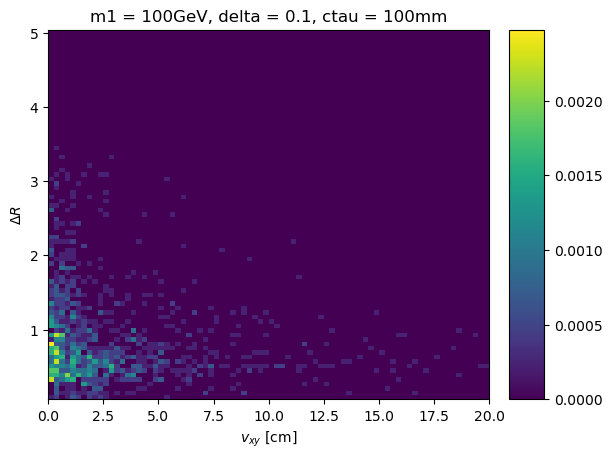

In [129]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_dR',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0, 5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxy_vs_sel_vtx_mass

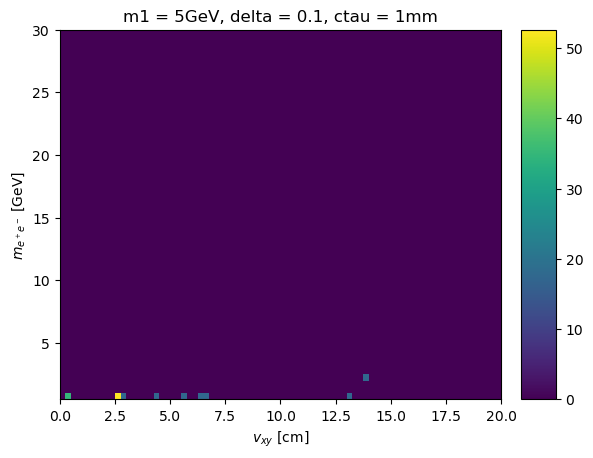

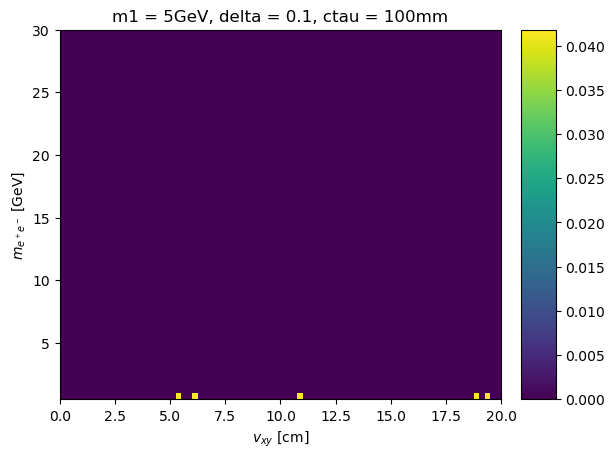

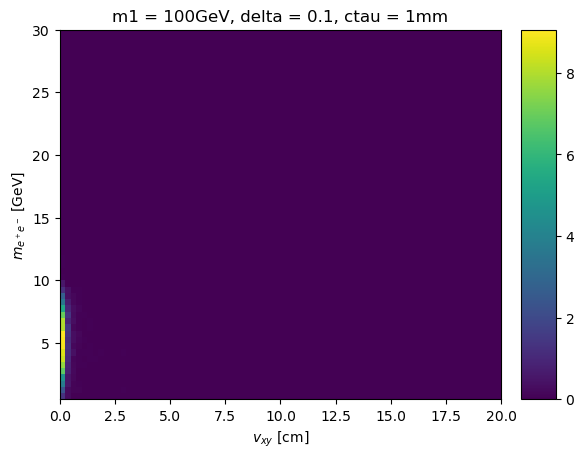

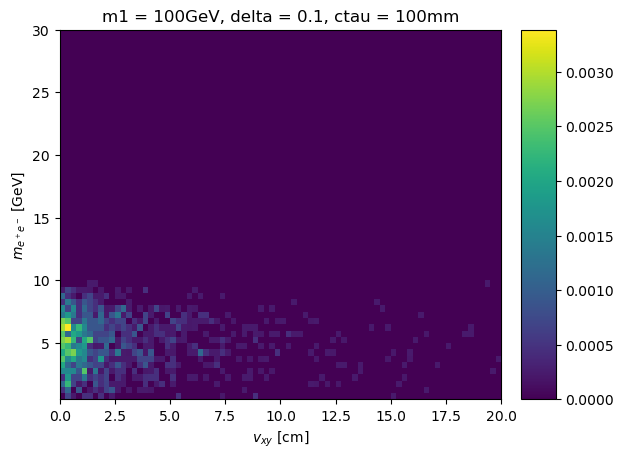

In [130]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_mass',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': [0, 30],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxy_vs_sel_vtx_METdPhi

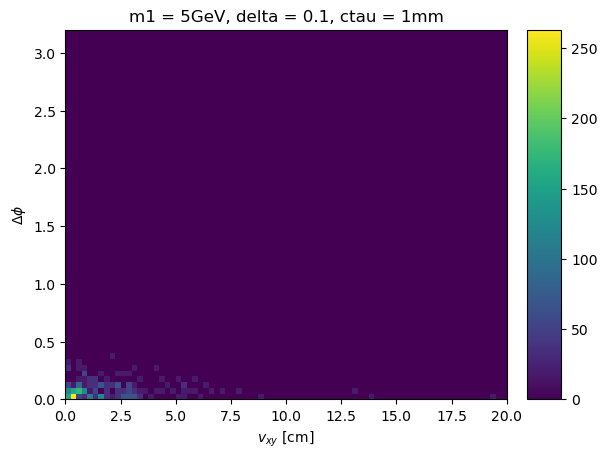

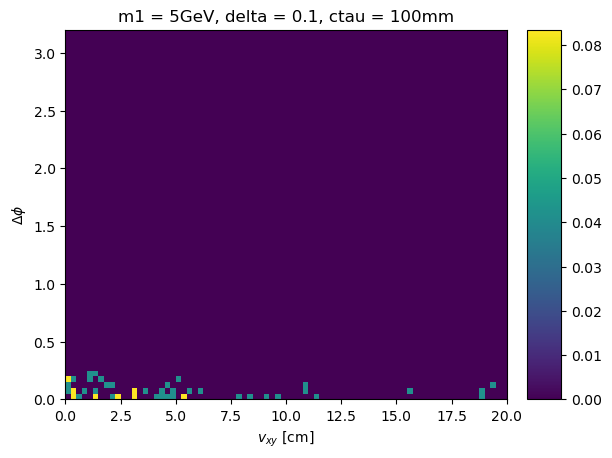

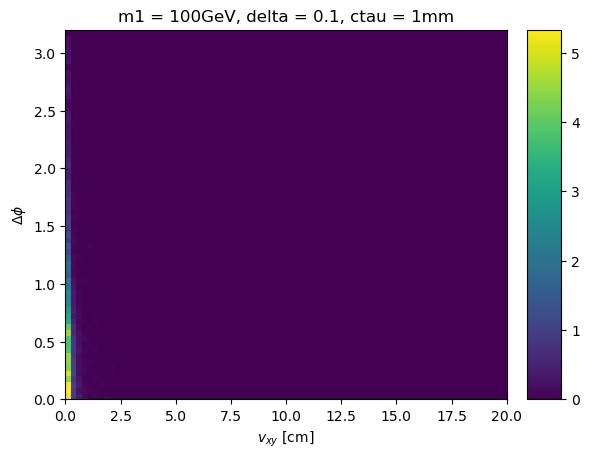

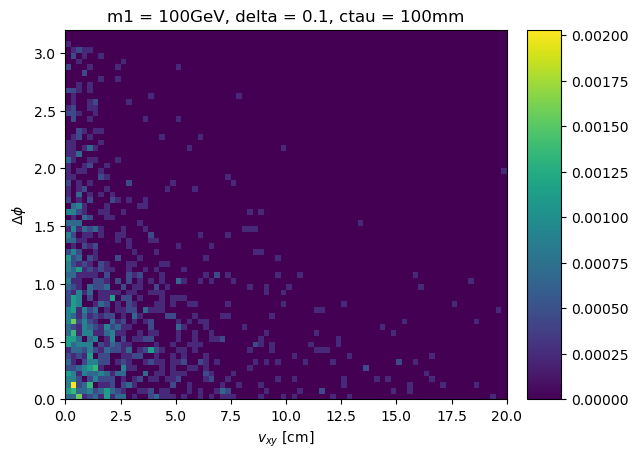

In [131]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_METdPhi',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxy_vs_sel_vtx_vxySignif

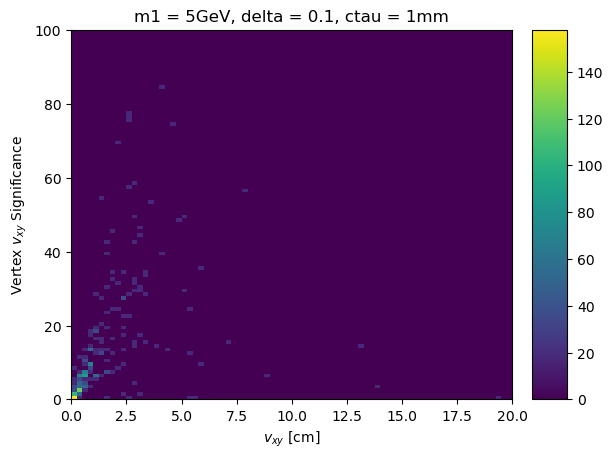

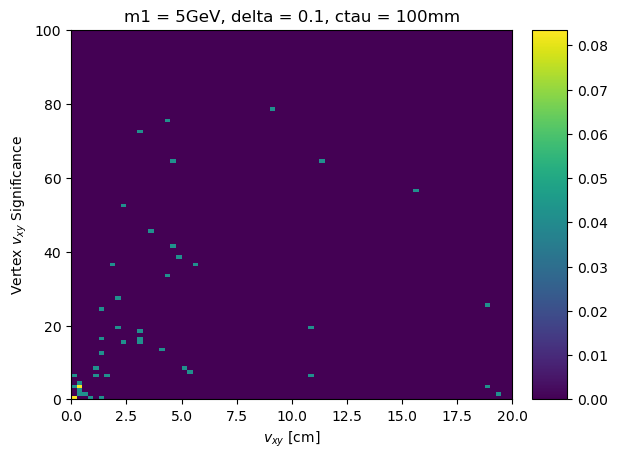

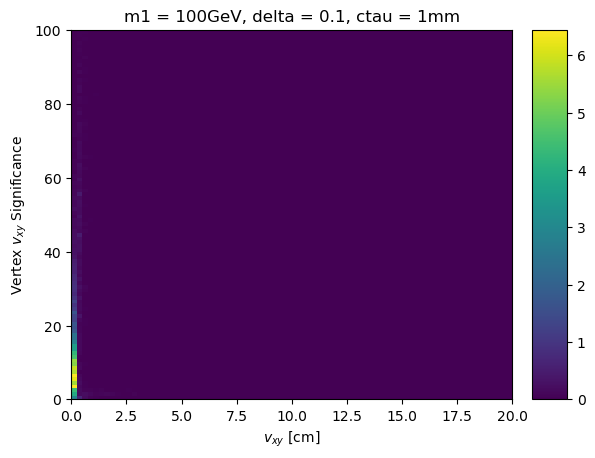

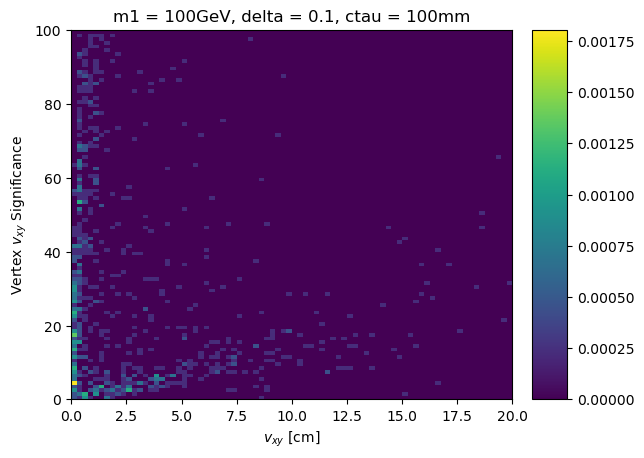

In [132]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_vxySignif',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxy_vs_sel_vtx_pt

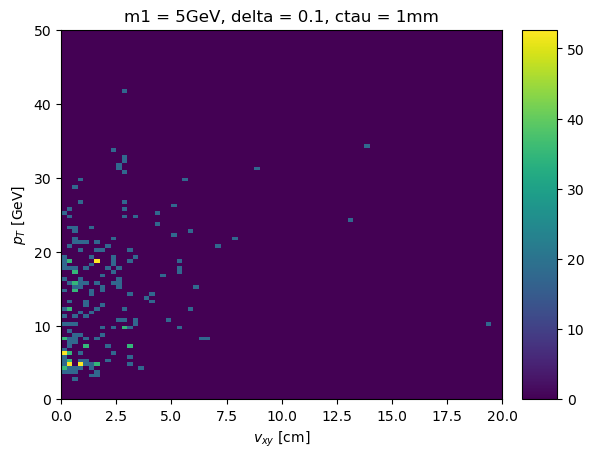

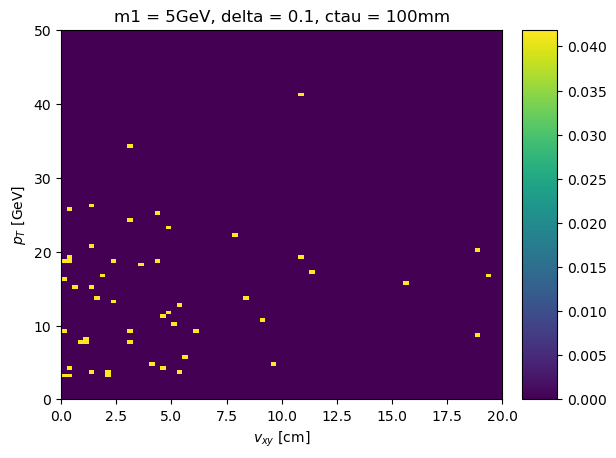

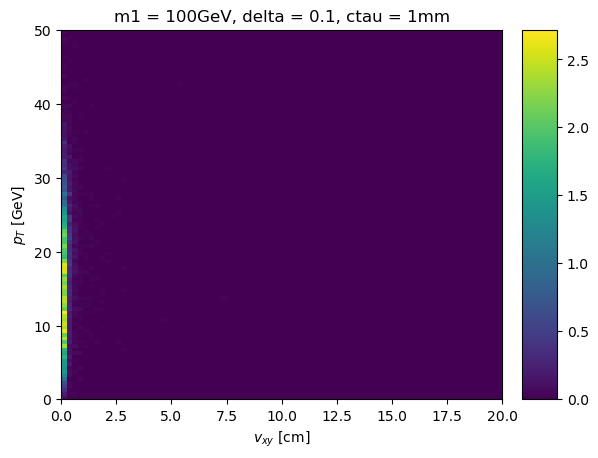

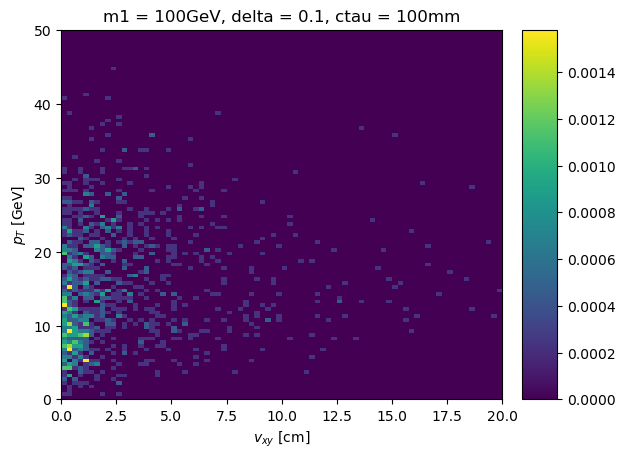

In [133]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_pt',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxy_vs_sel_vtx_sign_eta

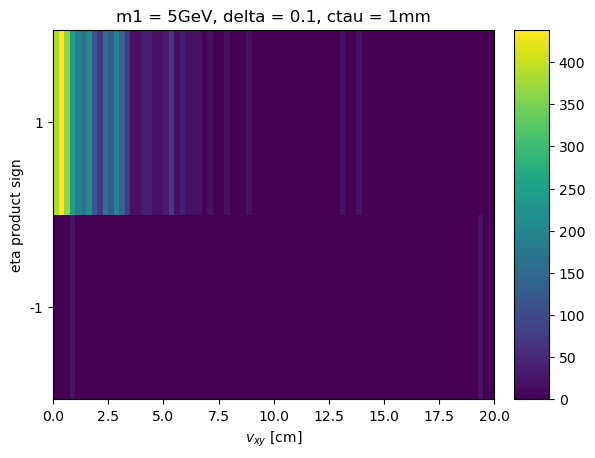

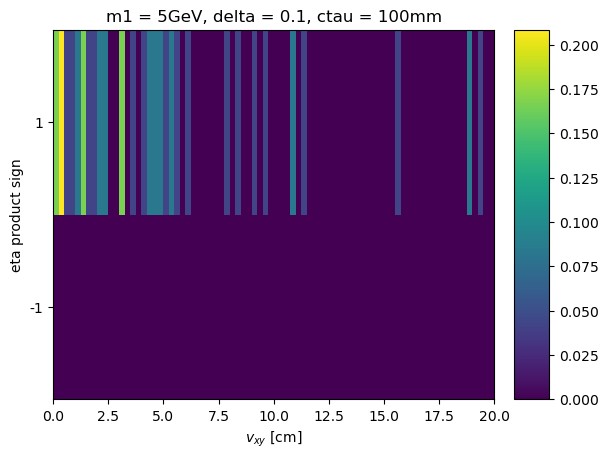

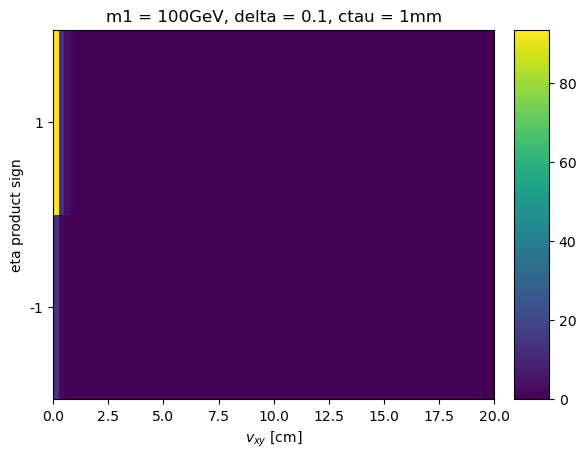

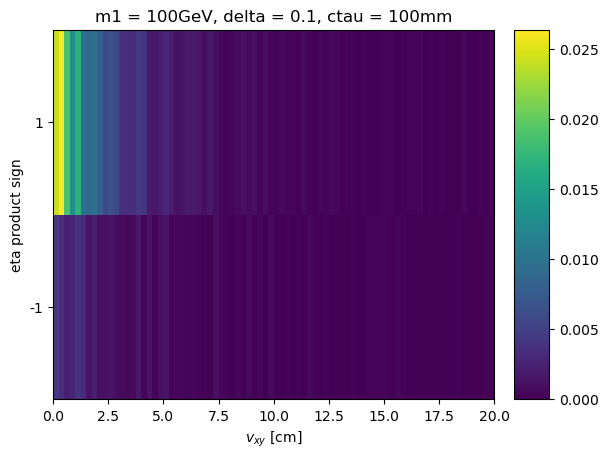

In [134]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_sel_vtx_sign_eta',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_true, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxy_vs_matchType

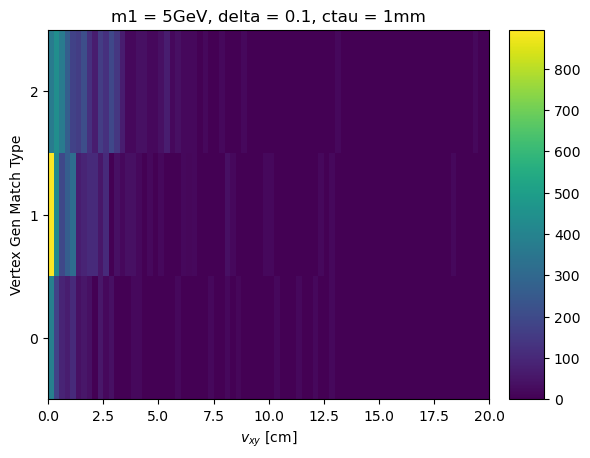

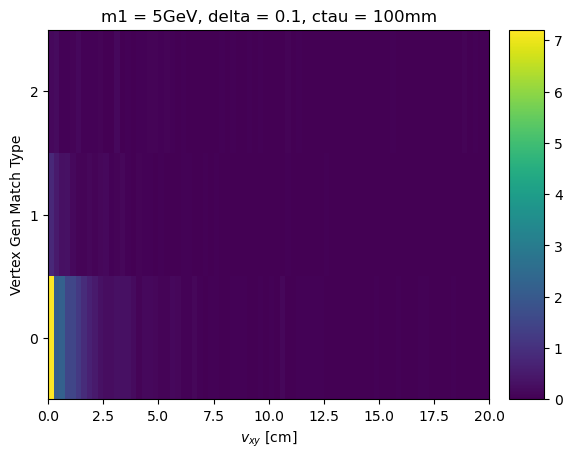

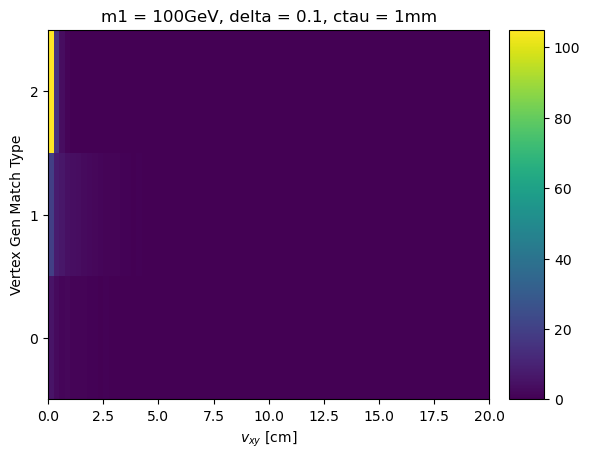

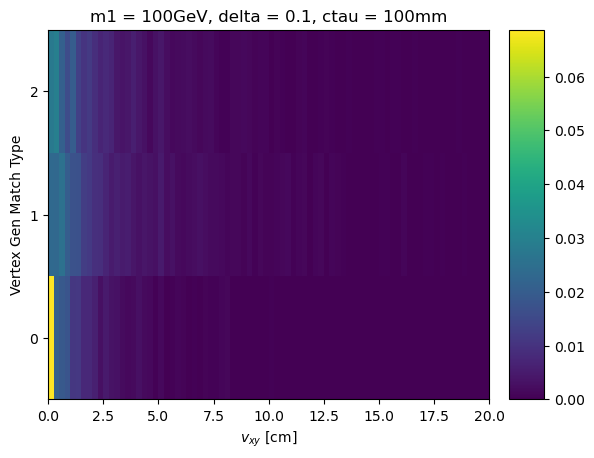

In [135]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxy_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': [0, 20],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_minDxy_vs_matchType

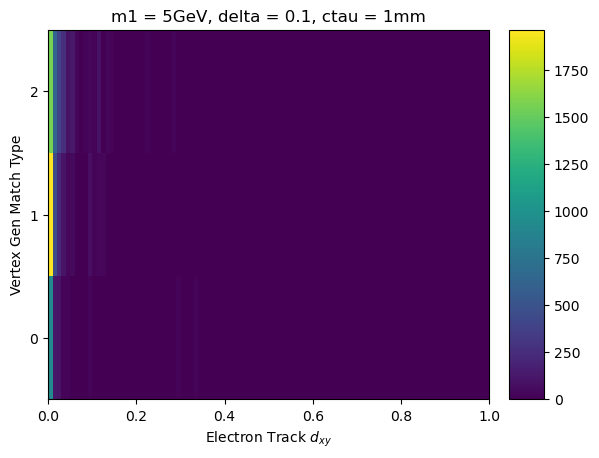

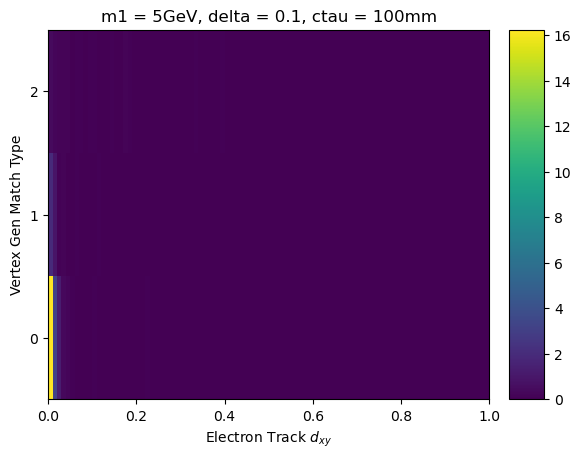

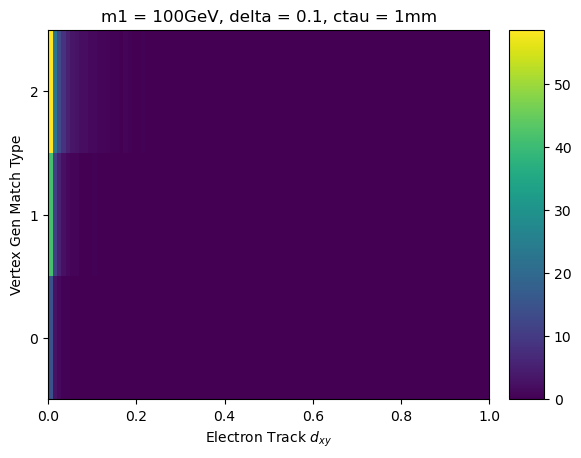

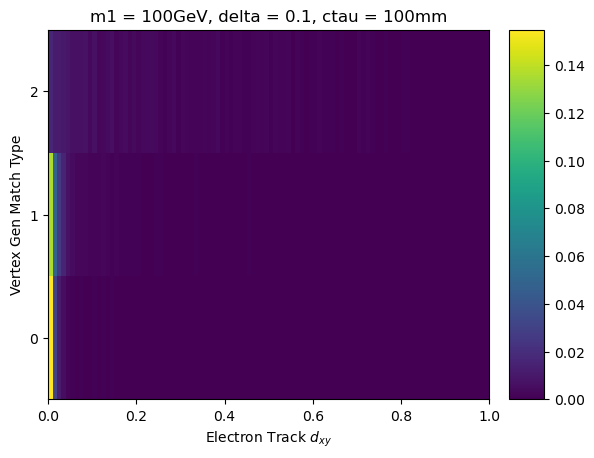

In [136]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_minDxy_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': [0,1],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_minDz_vs_matchType

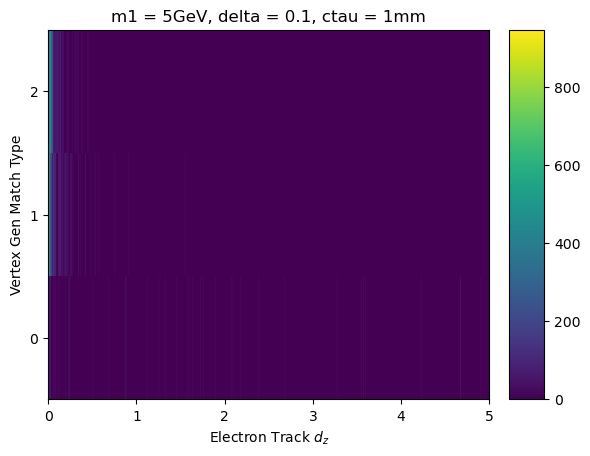

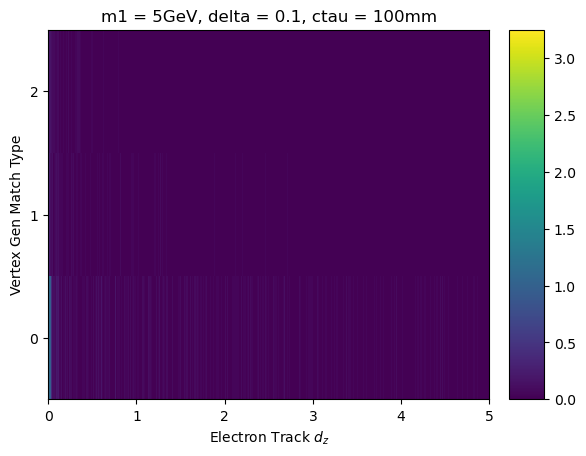

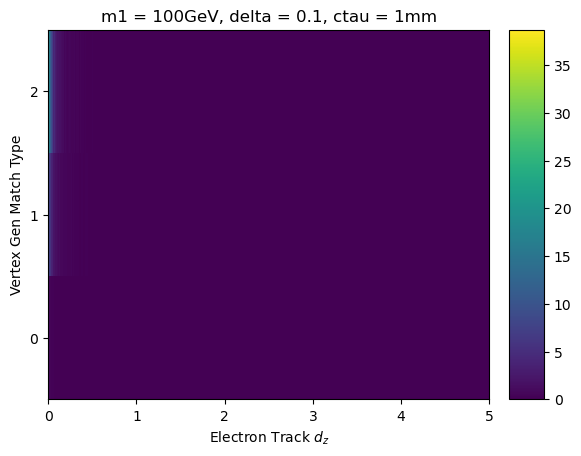

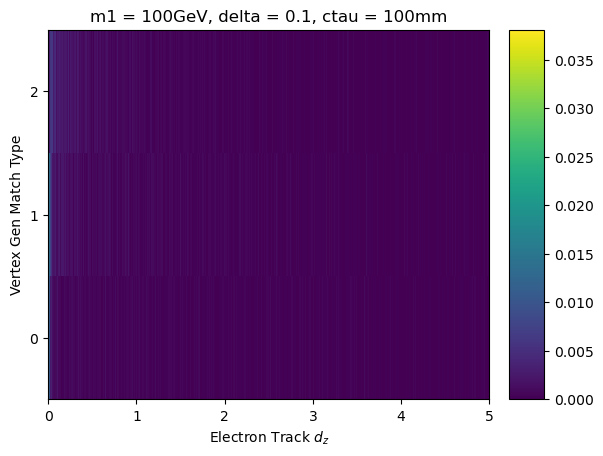

In [137]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_minDz_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_deltaDxy_vs_matchType

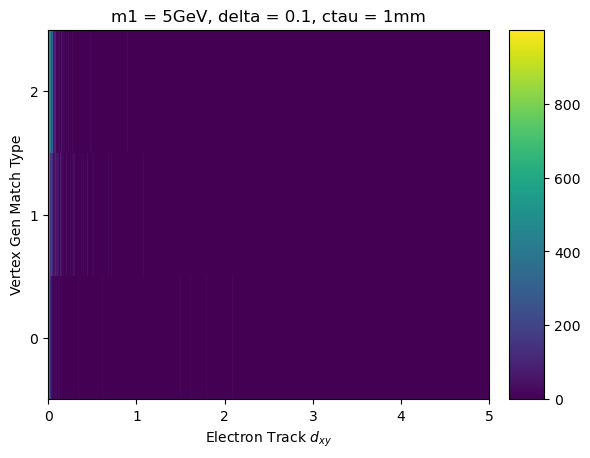

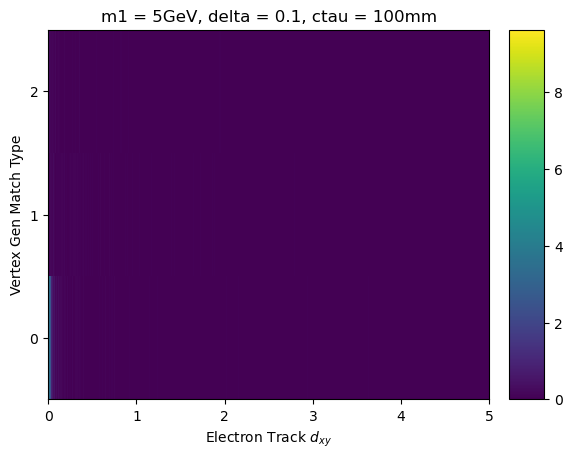

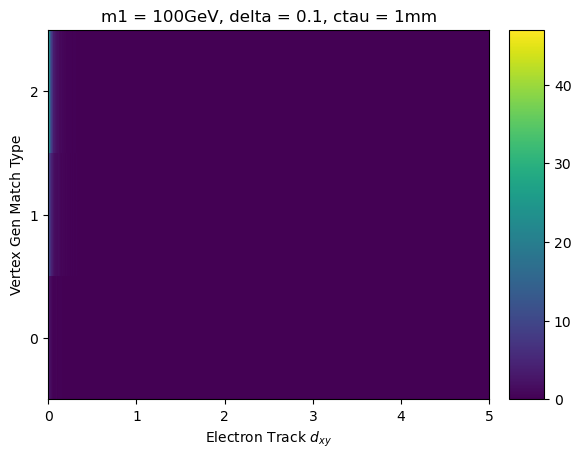

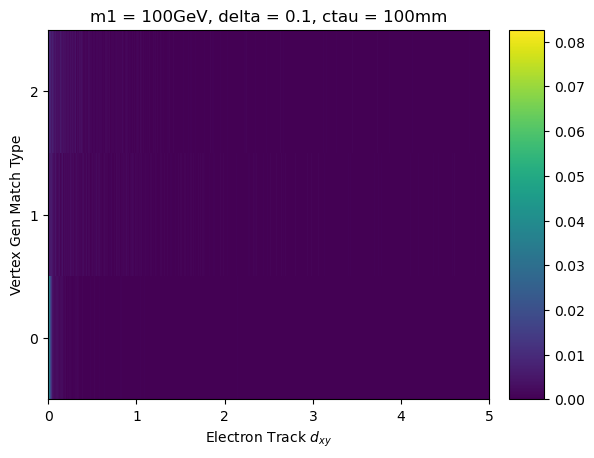

In [138]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_deltaDxy_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_deltaDz_vs_matchType

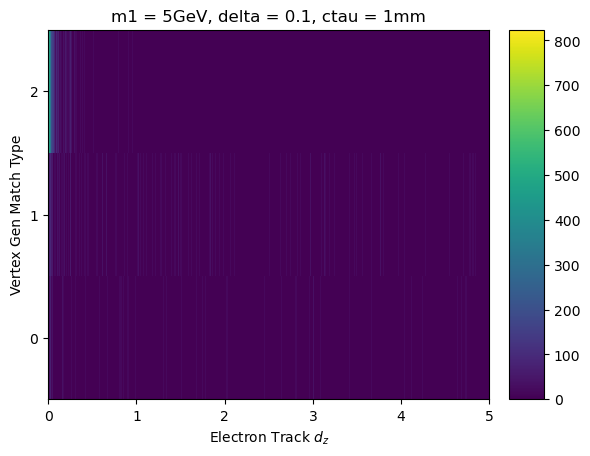

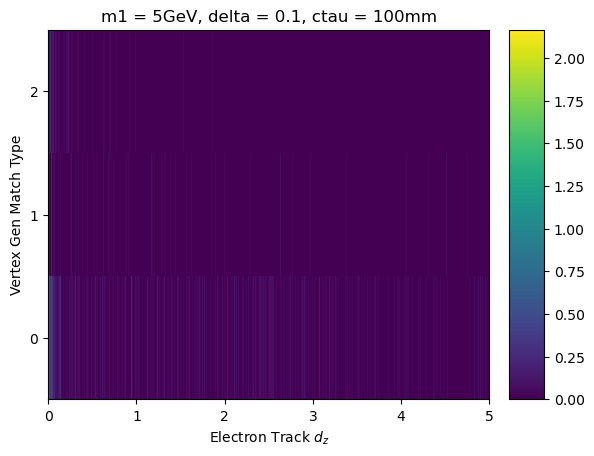

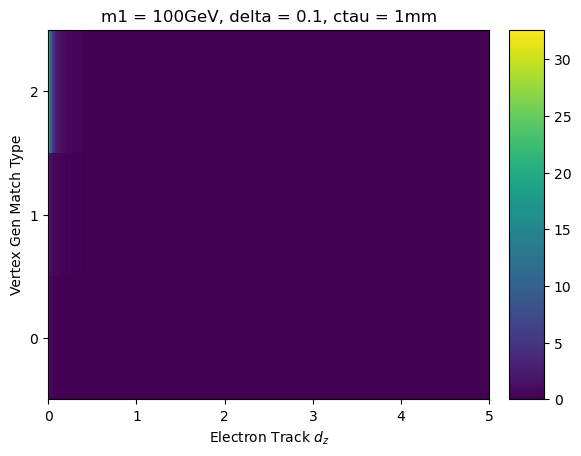

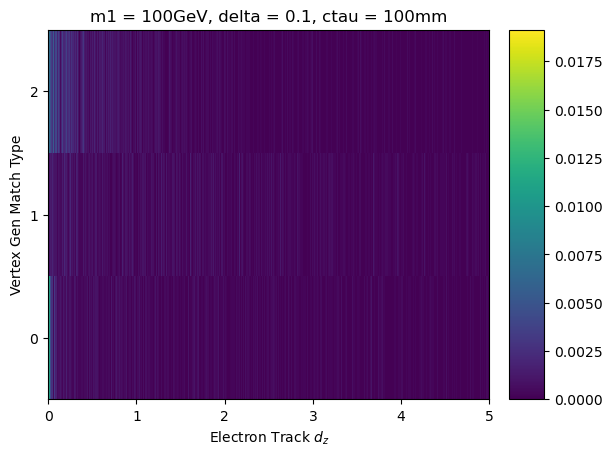

In [139]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_deltaDz_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 10j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_vxySignif_vs_matchType

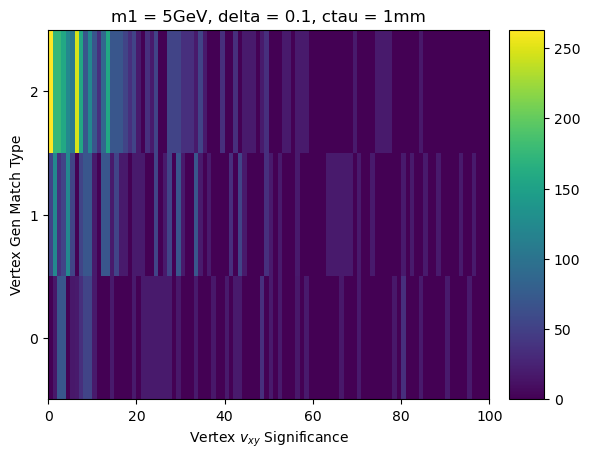

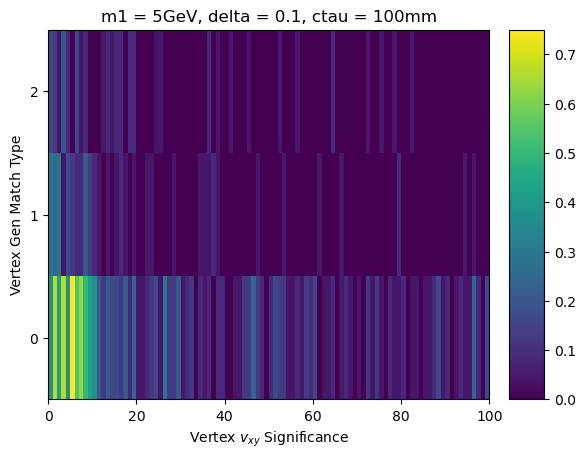

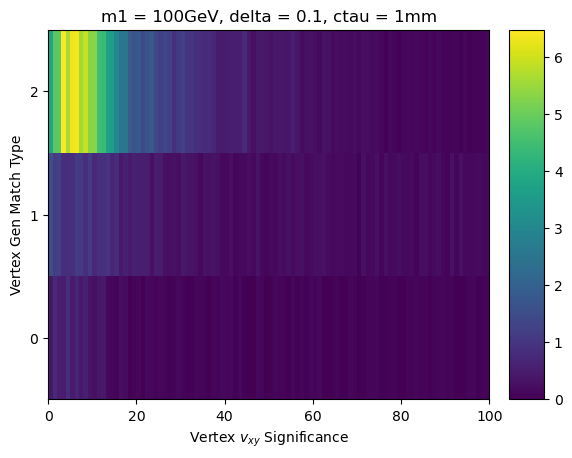

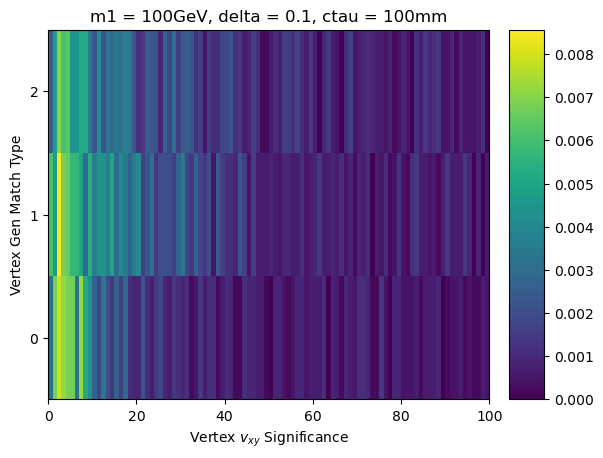

In [140]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_vxySignif_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_chi2_vs_matchType

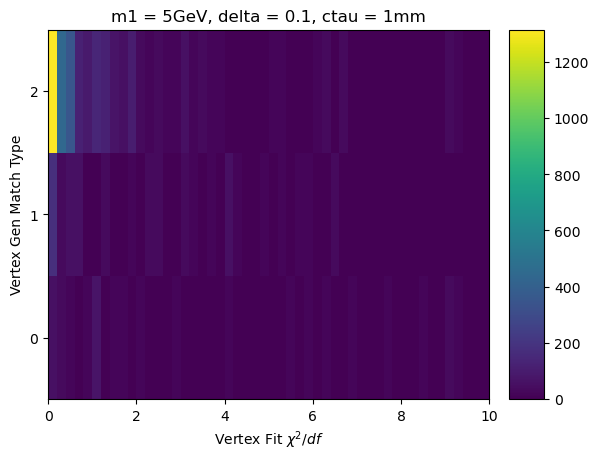

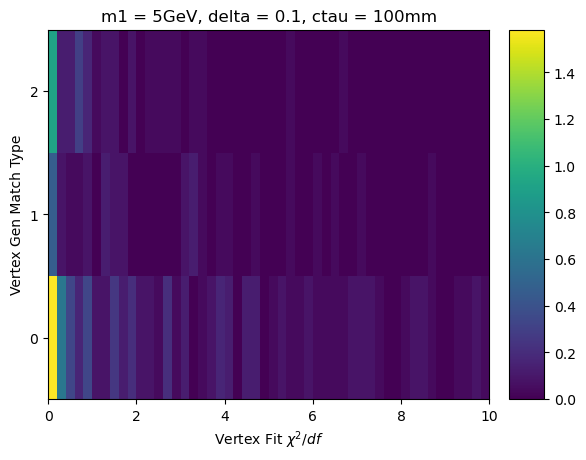

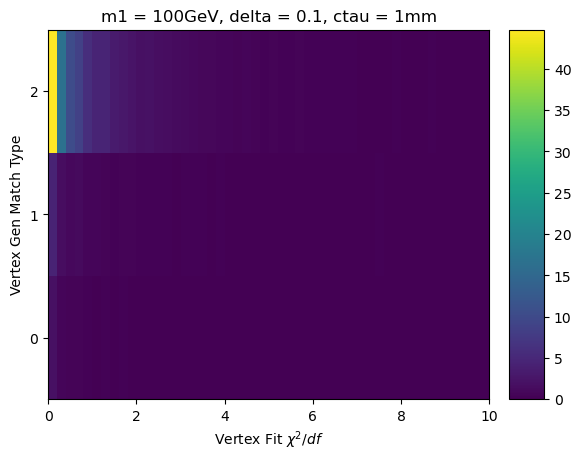

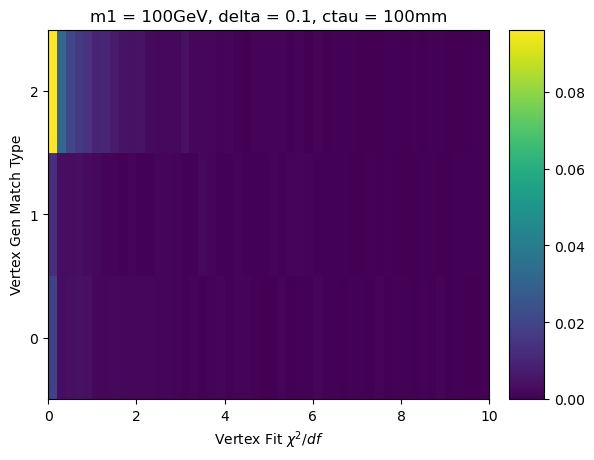

In [141]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_chi2_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': [0,10],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_dR_vs_matchType

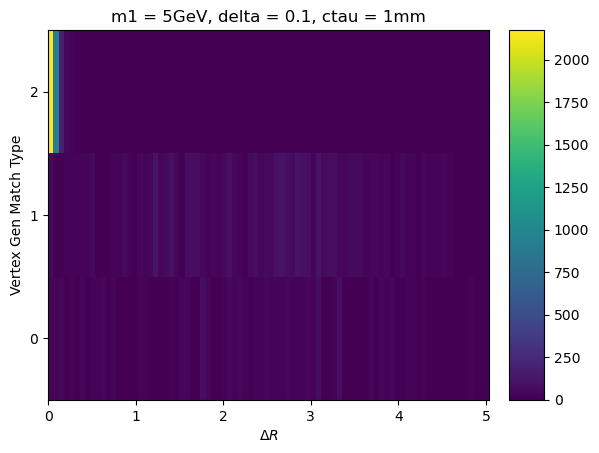

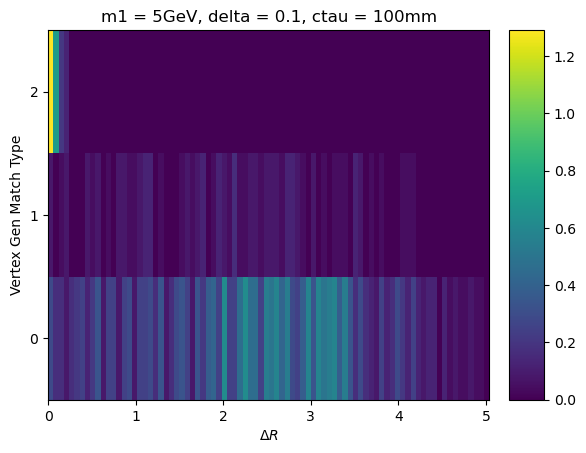

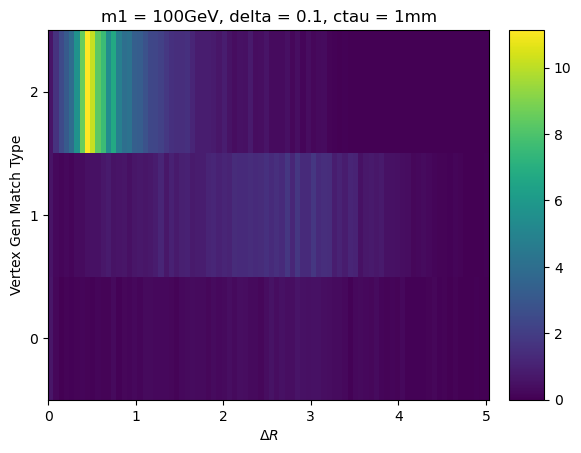

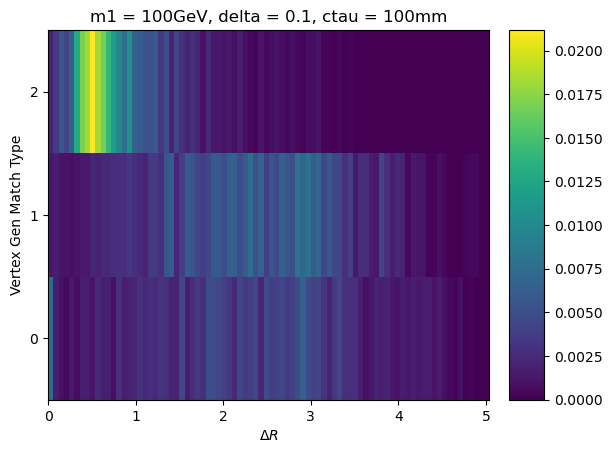

In [142]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dR_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': [0, 5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_dEta_vs_matchType

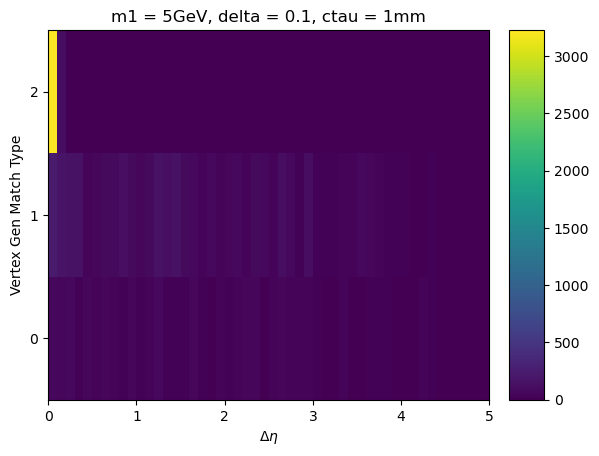

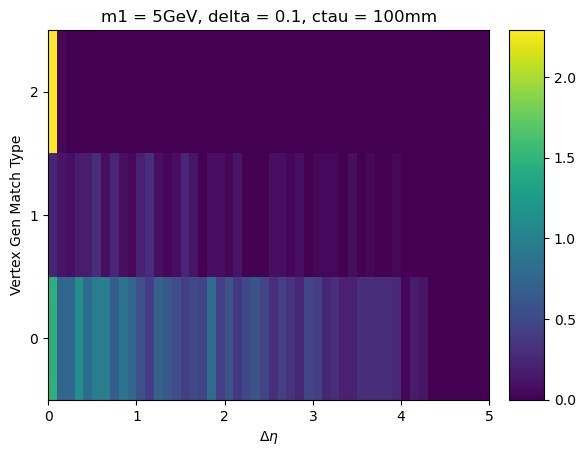

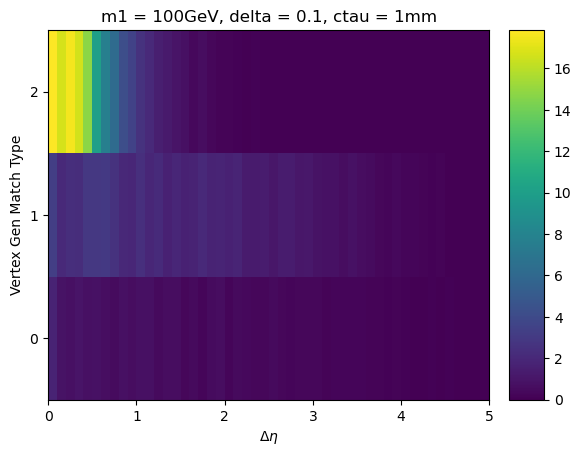

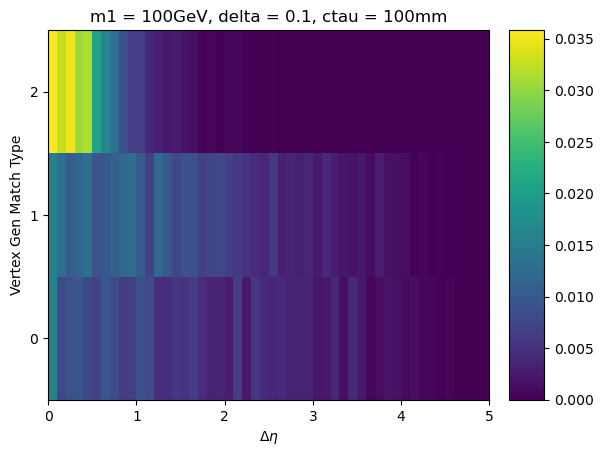

In [143]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dEta_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': [0, 5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_dPhi_vs_matchType

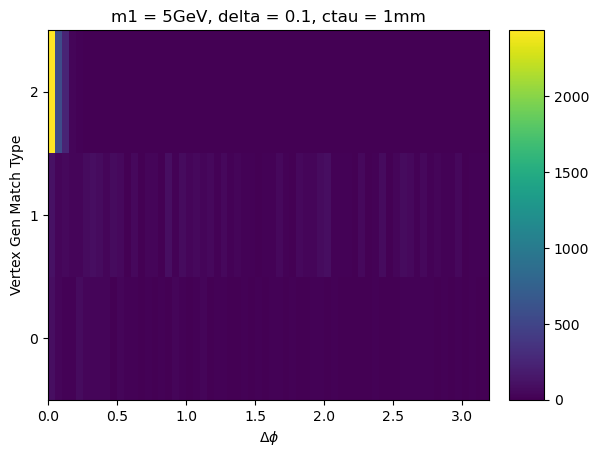

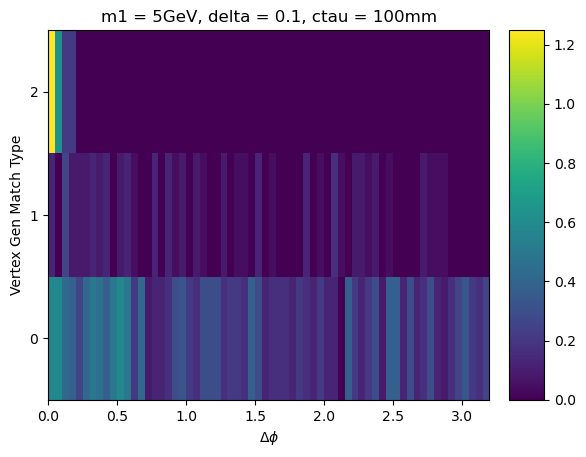

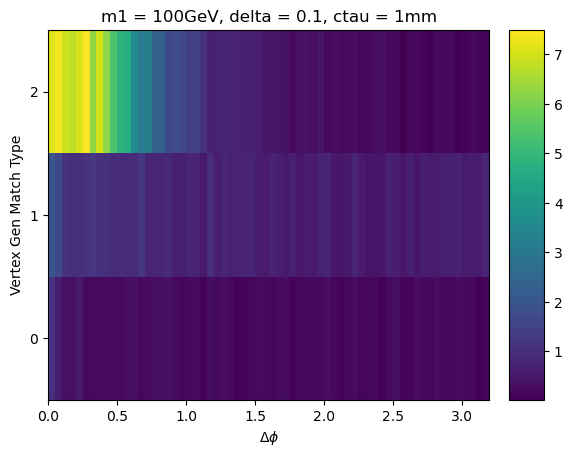

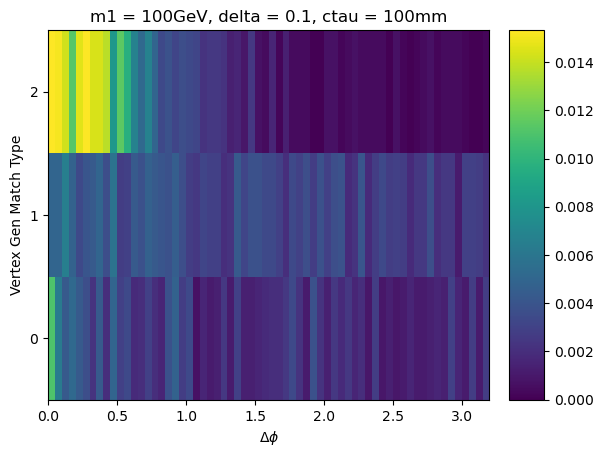

In [144]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_dPhi_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': [0, 5],     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_sign_eta_vs_matchType

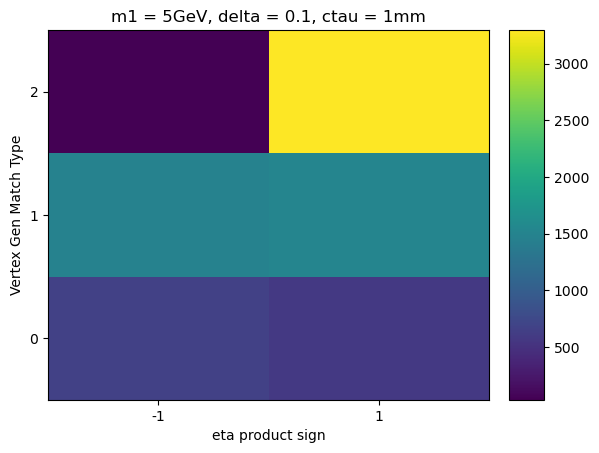

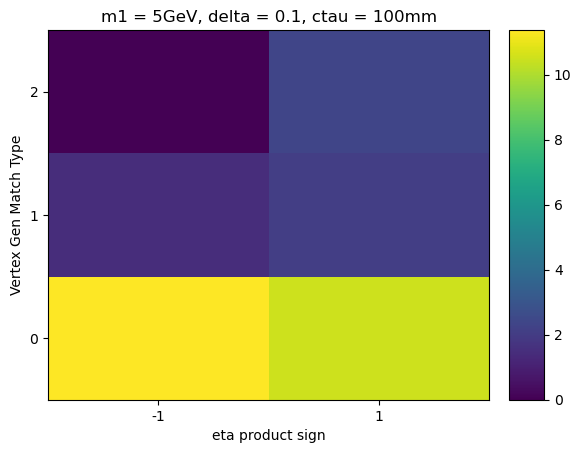

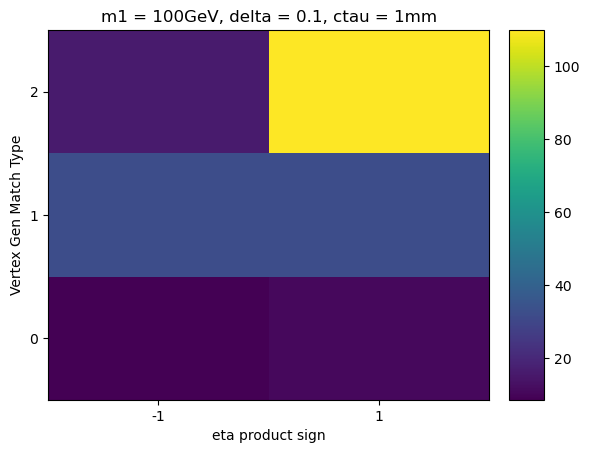

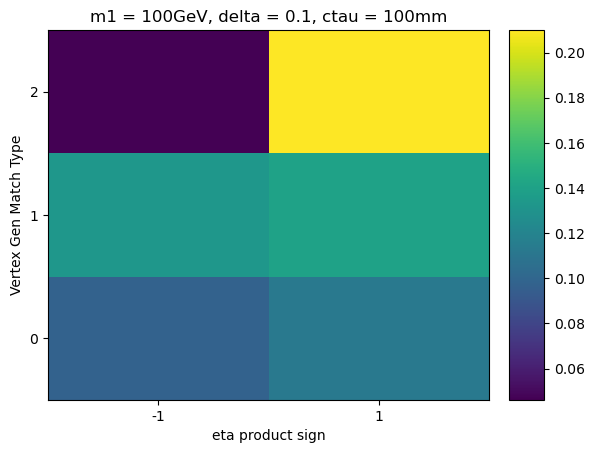

In [145]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_sign_eta_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_pt_vs_matchType

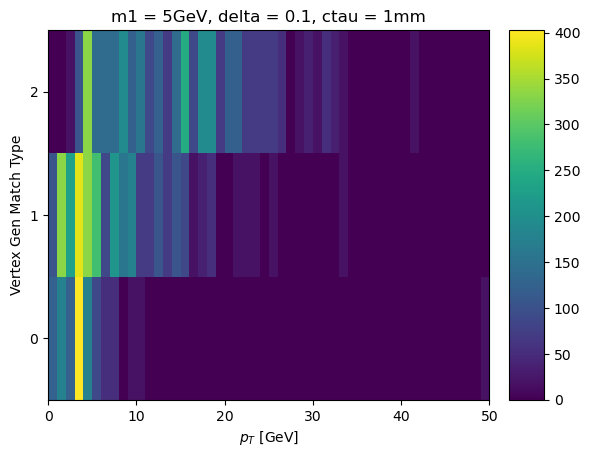

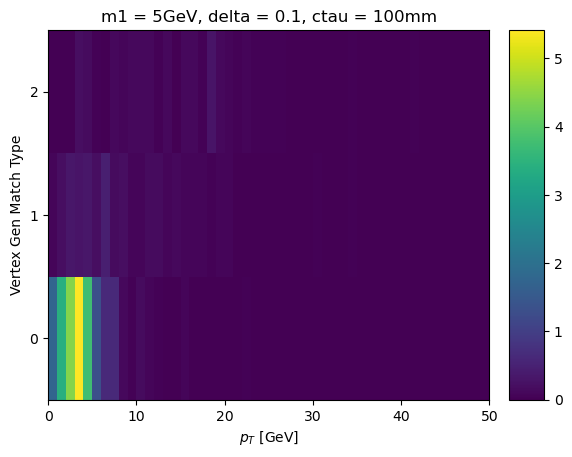

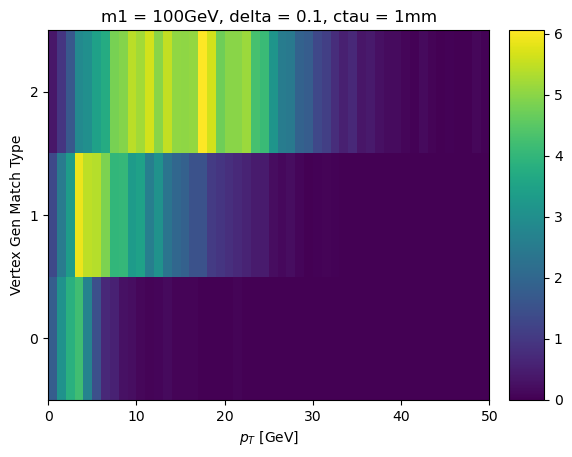

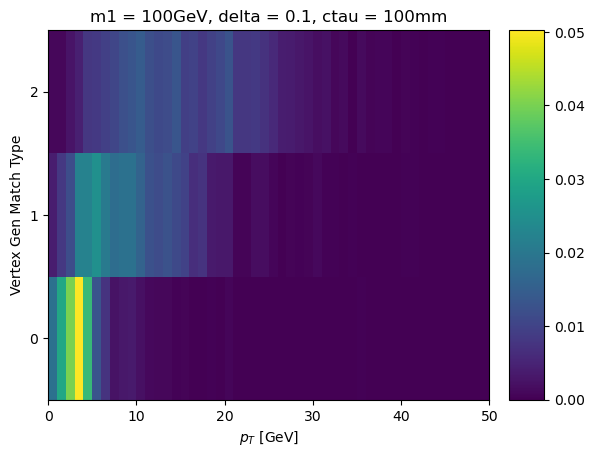

In [146]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_pt_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 2j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_eta_vs_matchType

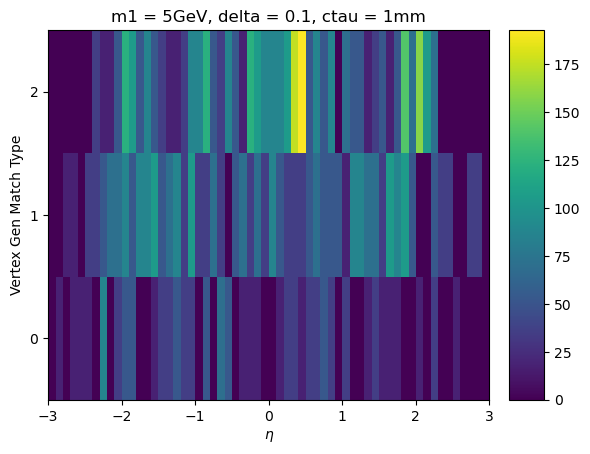

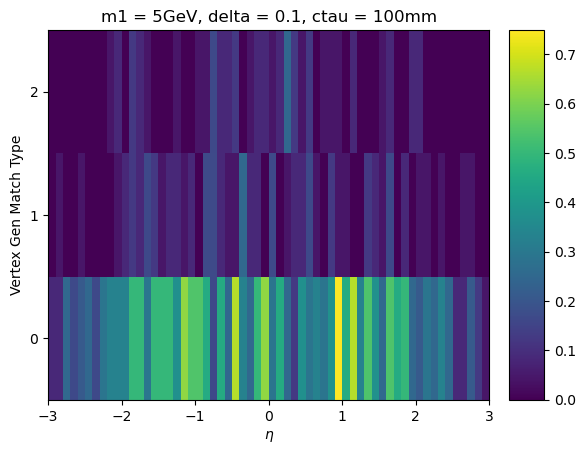

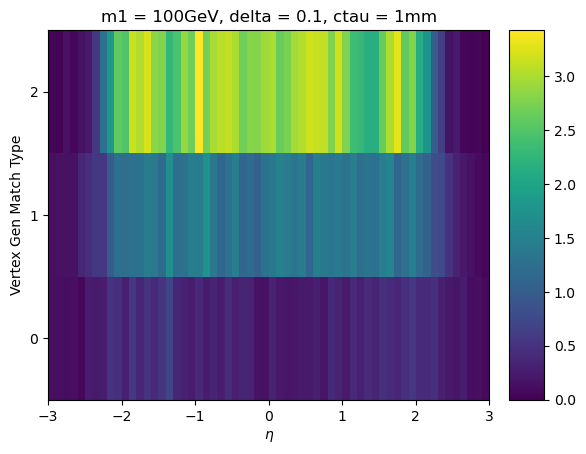

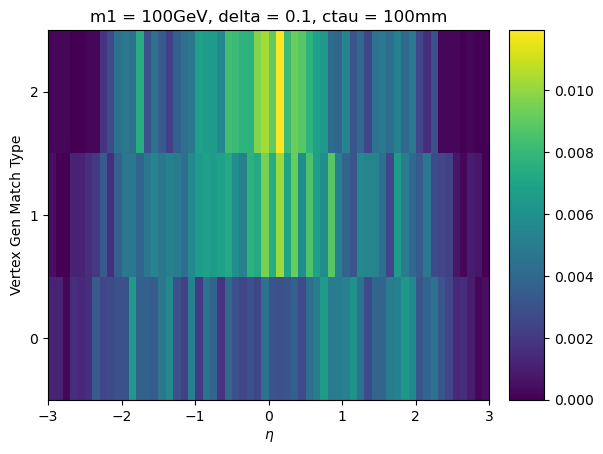

In [147]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_eta_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_phi_vs_matchType

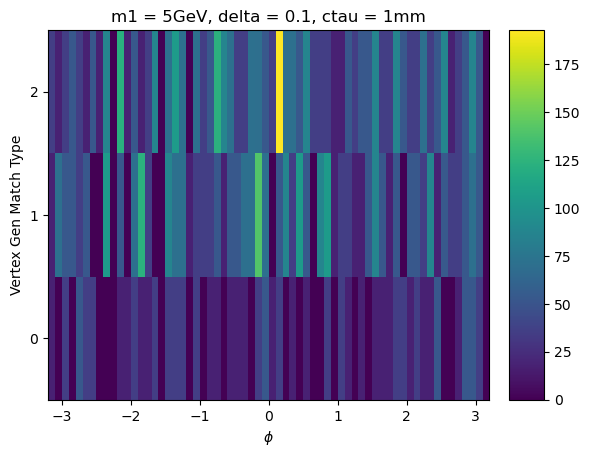

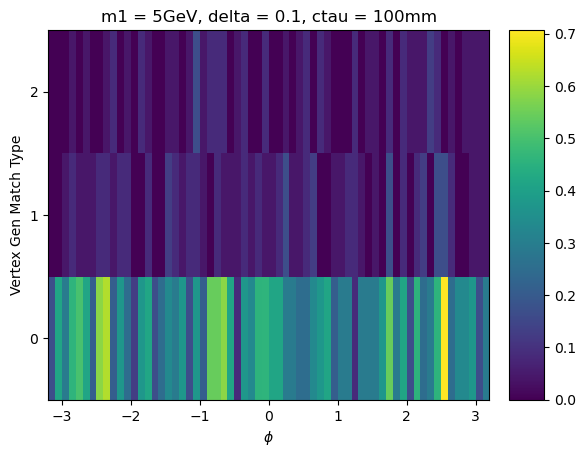

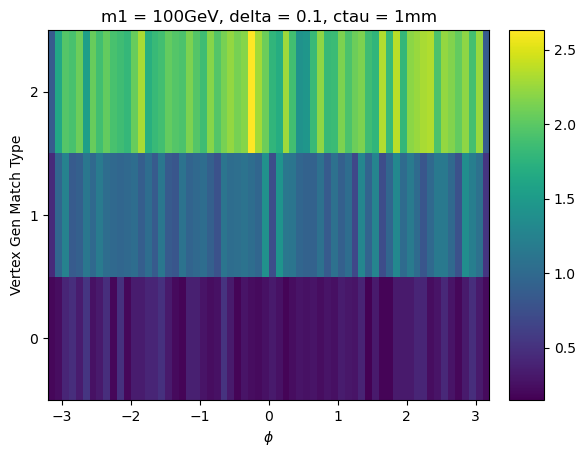

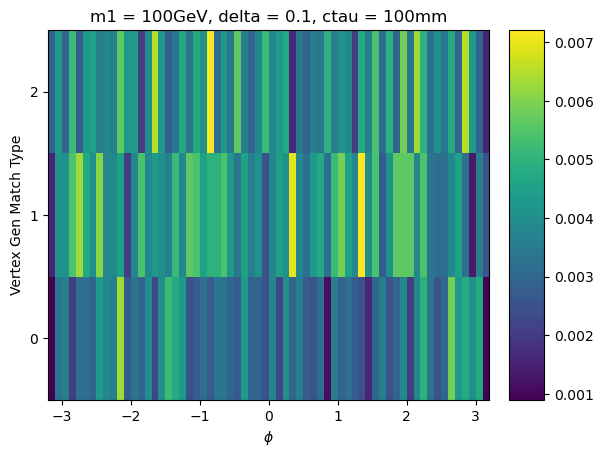

In [148]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_phi_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_mass_vs_matchType

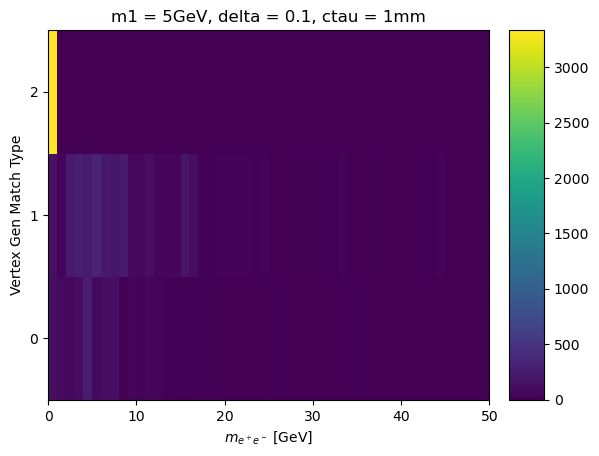

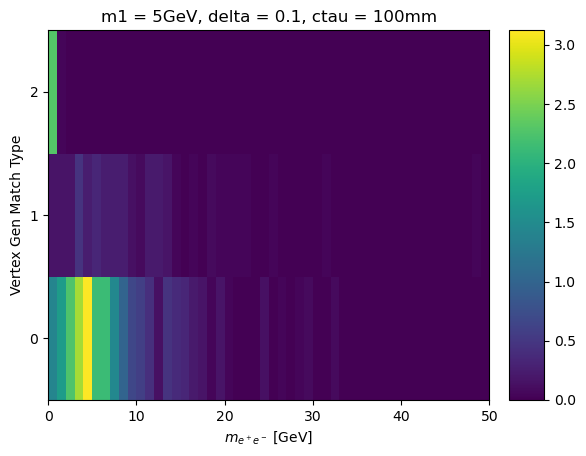

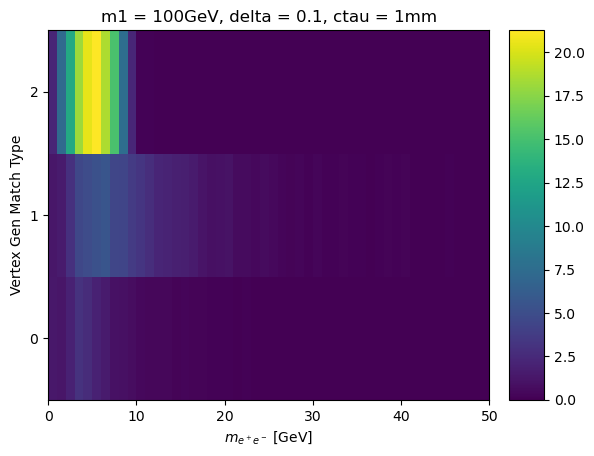

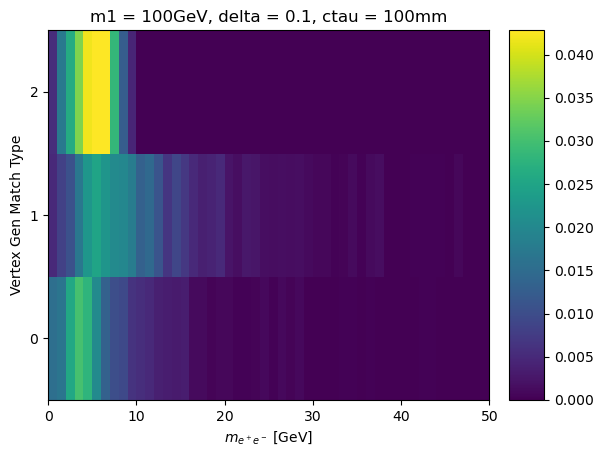

In [149]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_mass_vs_matchType',
    'cut': 'cut9',
}

style_2d_dict = {
    'xrebin': 2j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [5, 100]
deltas = [0.1]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()

### sel_vtx_type_vs_matchType

In [ ]:
# Plot settings
plot_dict = {
    'variable': 'sel_vtx_type_vs_matchType',
    'cut': 'cut9',
}
style_2d_dict = {
    'xrebin': 1j,
    'yrebin': 1j,
    'xlim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]  
    'ylim': None,     # if None, the default will show up; otherwise give as a list, i.e. [0, 10]
    'doLogy': False, 
    'doLogx': False,
    'doLogz': False,
    'xlabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Electron dxy'
    'ylabel': None,   # if None, the default will show up; otherwise give as a string, i.e. 'Efficiency'
    'flow': None,     # overflow
}

m1s = [50]
deltas = [0.2]
ctaus = [1, 100]

for m1 in m1s:
    for delta in deltas:
        for ctau in ctaus:
            fig, ax = plt.subplots()

            utils.plot_signal_2D(ax, sig_histo_best, m1, delta, ctau, plot_dict, style_2d_dict)
        
            plt.title(f'm1 = {m1}GeV, delta = {delta}, ctau = {ctau}mm')
            plt.show()